In [31]:
import pickle
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, Tuple, Optional
from dataclasses import dataclass

from pyutils.pyprint import Print
from pyutils.pylogger import Logger
from pyutils.pyselect import Select
from pyutils.pycut import CutManager
from pyutils.pyplot import Plot
from pyutils.pyvector import Vector

import sys
sys.path.extend(["../../src/utils"])
from io_manager import Load

# Make everything available when using "from preamble import *"
__all__ = ["Logger", "Print", "Load", "Draw"] 

printer = Print()
selector = Select()
logger = Logger()
plotter = Plot()
vector = Vector()

[pyprint] ⭐️ Initialised Print with verbose = False and precision = 1
[pyplot] ⭐️ Initialised Plot with mu2e.mplstyle and verbosity = 1
[pyvector] ⭐️ Initialised Vector with verbosity = 1


In [108]:
@dataclass
class MomentumWindow:
    """Define momentum selection windows for track momentum"""
    name: str
    p_min: Optional[float] = None
    p_max: Optional[float] = None
    
    def apply(self, mom_mag):
        """Apply momentum cuts"""
        if self.p_min is None and self.p_max is None:
            return ak.ones_like(mom_mag, dtype=bool)
        
        mask = ak.ones_like(mom_mag, dtype=bool)
        if self.p_min is not None:
            mask = mask & (mom_mag > self.p_min)
        if self.p_max is not None:
            mask = mask & (mom_mag < self.p_max)
        return mask


class CosmicAna:
    """Pipeline for cosmic ray momentum analysis with livetime weighting"""

    # Livetime for each window (seconds)
    LIVETIMES = {
        "inclusive": {"aw": 35189, "1a": 14954},
        "wide": {"aw": 28048, "1a": 11800},
        "extended": {"aw": 2941, "1a": 1218},
        "signal": {"aw": 383.89, "1a": 159.59},
    }
    
    # Momentum windows (GeV/c) - applied to TRACK momentum at TT_Front
    WINDOWS = {
        "inclusive": MomentumWindow("inclusive"),
        "wide": MomentumWindow("wide", p_min=85, p_max=200),
        "extended": MomentumWindow("extended", p_min=100, p_max=110),
        "signal": MomentumWindow("signal", p_min=103.6, p_max=104.9),
    }
    
    # Plot styling
    DATASET_STYLES = {
        "aw": {"color": "red", "label": "Run-1 (MDC2020aw)"},
        "1a": {"color": "blue", "label": "Run-1a (MDC2025)"},
    }
    
    def __init__(self, data: Dict):
        self.data = data

    @classmethod
    def load_data(cls, base_path="../../output/results"):
        """Load data from default paths"""
        return {
            "1a": Load(f"{base_path}/dev_CRY_onspill-LH_1a_noCRV").load_array_parquet(),
            "aw": Load(f"{base_path}/dev_CRY_onspill-LH_aw_noCRV").load_array_parquet(),
        }
    
    # --- Event selection ---
    def _select_by_window(self, data, window_name: str):
        """
        Select events based on track momentum window at TT_Front
        
        This is the correct approach from your original select_window() function:
        1. Get track momentum at TT_Front
        2. Apply momentum window cuts to select events
        3. Filter all data structures by those cuts
        4. Return filtered data
        
        Returns: filtered data dict with only events passing window cuts
        """
        # Get track momentum at TT_Front surface
        trk_front = selector.select_surface(data["trkfit"], "TT_Front")
        mom_mag = vector.get_mag(data["trkfit"]["trksegs"], "mom")
        mom_mag = mom_mag[trk_front]
        
        # Apply window cuts to track momentum
        window = self.WINDOWS[window_name]
        window_mask = window.apply(mom_mag)
        window_mask = ak.flatten(window_mask, axis=-1)
        
        # Apply mask to select events
        selected_data = {
            "trk": data["trk"][window_mask],
            "trkfit": data["trkfit"][window_mask],
            "trkmc": data["trkmc"][window_mask],
        }
        
        # Keep only events with tracks
        has_trks = ak.any(selected_data["trk"]["trk.pdg"], axis=-1)
        for key in selected_data:
            selected_data[key] = selected_data[key][has_trks]
        
        return selected_data
    
    # --- Parent momentum extraction ---
    def _get_parent_mom(self, parents) -> ak.Array:
        """Extract momentum magnitude from parents"""
        mom_mag = vector.get_mag(parents, "mom")
        mom_mag = ak.firsts(mom_mag, axis=-1)
        mom_mag = ak.flatten(mom_mag, axis=None)
        return mom_mag
    
    def _get_cosmic_parents(self, data, pdg: Optional[int] = None) -> ak.Array:
        """Get cosmic parents (rank == -1)"""
        rank_mask = data["trkmc"]["trkmcsim"]["rank"] == -1
        
        if pdg:
            pdg_mask = data["trkmc"]["trkmcsim"]["pdg"] == pdg
            condition = rank_mask & pdg_mask
        else:
            condition = rank_mask
        
        return data["trkmc"]["trkmcsim"][condition]
    
    def _get_track_parents(self, data, pdg: Optional[int] = None) -> ak.Array:
        """Get track parents (max nhits)"""
        nhits_mask = data["trkmc"]["trkmcsim"]["nhits"] == \
                     ak.max(data["trkmc"]["trkmcsim"]["nhits"], axis=-1)
        
        if pdg:
            pdg_mask = data["trkmc"]["trkmcsim"]["pdg"] == pdg
            condition = nhits_mask & pdg_mask
        else:
            condition = nhits_mask
        
        return data["trkmc"]["trkmcsim"][condition]
    
    def get_cosmic_parent_mom(self, data, pdg: Optional[int] = None) -> ak.Array:
        """Extract cosmic parent momentum magnitudes"""
        cosmic_parents = self._get_cosmic_parents(data, pdg)
        return self._get_parent_mom(cosmic_parents)
    
    def get_track_parent_mom(self, data, pdg: Optional[int] = None) -> ak.Array:
        """Extract track parent momentum magnitudes"""
        track_parents = self._get_track_parents(data, pdg)
        return self._get_parent_mom(track_parents)

    def get_track_mom(self, data) -> ak.Array:
        """Extract track parent momentum magnitudes"""
        # Should already have the downstream electron selected
        # But not the one at the tracker front? 
        at_trk_front = selector.select_surface(data["trkfit"], "TT_Front")
        mom_mag = vector.get_mag(data["trkfit"]["trksegs"][at_trk_front], "mom")
        mom_mag = ak.flatten(mom_mag, axis=None)
        return mom_mag 
    
    def _create_weights(self, n_events: int, livetime: float) -> np.ndarray:
        """Create weights array: 1/livetime for each event"""
        return np.ones(n_events) / livetime
    
    # --- Main pipeline ---
    def run(self, pdg: Optional[int] = None, windows: list = None, 
            convert_to_GeV: bool = True) -> Dict:
        """
        Run full analysis pipeline
        
        Workflow:
        1. For each dataset and window:
        2. Select events based on TRACK momentum at TT_Front passing window cuts
        3. Extract PARENT momenta from selected events
        4. Create livetime weights
        
        Args:
            pdg: Particle PDG code to filter (e.g., 13 for muons)
            windows: List of window names to process (default: all)
            convert_to_GeV: Convert momenta from GeV to GeV
        
        Returns:
            Nested dict: {dataset: {window: {parent_type: {mom, weights}}}}
        """
        if windows is None:
            windows = list(self.WINDOWS.keys())
        
        results = {}
        
        for dataset_name, dataset in self.data.items():
            print(f"\nProcessing dataset: {dataset_name}")
            results[dataset_name] = {}
            
            # Apply each window
            for window_name in windows:
                print(f"\tApplying {window_name} window...")
                
                # Select events based on TRACK momentum at TT_Front
                selected_data = self._select_by_window(dataset, window_name)
                
                # Extract parent momenta from SELECTED events
                # (parent momenta can be any value - not constrained by window)
                cosmic_mom = self.get_cosmic_parent_mom(selected_data, pdg=pdg)
                track_mom = self.get_track_parent_mom(selected_data, pdg=pdg)
                track_reco_mom = self.get_track_mom(selected_data)
                
                # Convert to numpy
                cosmic_mom_np = ak.to_numpy(cosmic_mom)
                track_mom_np = ak.to_numpy(track_mom)
                track_reco_mom_np = ak.to_numpy(track_reco_mom)
                
                # Optional: convert GeV -> GeV
                if convert_to_GeV:
                    cosmic_mom_np = cosmic_mom_np * 1e-3
                    track_mom_np = track_mom_np * 1e-3
                    # track_reco_mom_np = track_reco_mom_np * 1e-3
                
                # Get livetime for this window/dataset
                livetime = self.LIVETIMES[window_name][dataset_name]
                
                # Create weights: 1/livetime per event
                cosmic_weights = self._create_weights(len(cosmic_mom_np), livetime)
                track_weights = self._create_weights(len(track_mom_np), livetime)
                track_reco_weights = self._create_weights(len(track_reco_mom_np), livetime)
                
                results[dataset_name][window_name] = {
                    "cosmic_parent": {
                        "mom": cosmic_mom_np,
                        "weights": cosmic_weights,
                        "n_events": len(cosmic_mom_np),
                    },
                    "track_parent": {
                        "mom": track_mom_np,
                        "weights": track_weights,
                        "n_events": len(track_mom_np),
                    },
                    "track_reco": {
                        "mom": track_reco_mom_np,
                        "weights": track_reco_weights,
                        "n_events": len(track_reco_mom_np),
                    },
                    "livetime": livetime,
                }
        
        return results

    @classmethod 
    def _format_label(cls, label):
        #  "cosmic_parent" -> "Cosmic parent"
        #  "track_parent" -> "Track parent"
        #  "track_reco" -> "Track reco"
        # Split the string on _ 
        # Capitlize the first word
        # words = label.split("_")
        # result = words[0].capitalize() + " " + words[1]
        return label.replace("_", " ").capitalize() # it just does it for you, love Python

    @classmethod
    def plot_mom_overlays(cls, results, name="cosmic_parent", nbins=160, xrange=(0, 40)): 
        """
        Plot 2x2 grid of momentum overlays for all windows
        
        Args:
            results: Output from run()
            name: "cosmic" or "track"
        """
        plotter = Plot()

        fig, ax = plt.subplots(2, 2, figsize=(2*1.25*6.4, 2*1.25*4.8)) 

        for i, window_name in enumerate(cls.WINDOWS.keys()): 

            mom_1a = results["1a"][window_name][name]["mom"]
            mom_aw = results["aw"][window_name][name]["mom"]
            
            xmin, xmax = xrange # 0, 40

            stats_aw = plotter.get_stats(mom_aw, xmin, xmax)
            stats_1a = plotter.get_stats(mom_1a, xmin, xmax)

            this_ax = ax[i // 2, i % 2]
    
            plotter.plot_1D_overlay(
                { 
                    r"$\mathbf{Run\text{-}1\ (MDC2020aw)}$" + f"\nEntries: {stats_aw[0]}\nMean: {stats_aw[1]:.1f}\nStd Dev: {stats_aw[3]:.1f}": 
                        mom_aw,
                    
                    r"$\mathbf{Run\text{-}1a\ (MDC2025)}$" + f"\nEntries: {stats_1a[0]}\nMean: {stats_1a[1]:.1f}\nStd Dev: {stats_1a[3]:.1f}": 
                        mom_1a,
                },
                nbins=nbins,
                xmin=xmin, # xrange[0], 
                xmax=xmax, # xrange[1],
                # xlabel="Momentum [GeV/c]",
                xlabel=f"{cls._format_label(name)} momentum [GeV/c]",
                ylabel=f"Selected tracks",
                title=f"{window_name.capitalize()} window",
                log_y=True,
                show=False,
                ax=this_ax
            )

            title = f"{window_name.capitalize()} window"
            this_ax.set_title(title, fontsize=18)

        plt.tight_layout() 
        
        out_path = "../../output/images/energy_loss/"
        
        file_name = out_path + f"h1o_{name}_parent_mom.png"
        plt.savefig(file_name, dpi=300, bbox_inches='tight')
        print(f"Wrote {file_name}")
        
        plt.show()

    @classmethod
    def plot_mom_diff_overlays(cls, results, name1="cosmic_parent", name2="track_parent", nbins=1000, xrange=(0, 1)): 
        """
        Plot 2x2 grid of momentum overlays for all windows
        
        Args:
            results: Output from run()
            name: "cosmic" or "track"
        """
        plotter = Plot()

        fig, ax = plt.subplots(2, 2, figsize=(2*1.25*6.4, 2*1.25*4.8)) 

        for i, window_name in enumerate(cls.WINDOWS.keys()): 

            mom_1a = results["1a"][window_name][name1]["mom"] - results["1a"][window_name][name2]["mom"]
            mom_aw = results["aw"][window_name][name1]["mom"] - results["aw"][window_name][name2]["mom"]
            
            xmin, xmax = xrange # 0, 40

            stats_aw = plotter.get_stats(mom_aw, xmin, xmax)
            stats_1a = plotter.get_stats(mom_1a, xmin, xmax)

            this_ax = ax[i // 2, i % 2]
    
            plotter.plot_1D_overlay(
                { 
                    r"$\mathbf{Run\text{-}1\ (MDC2020aw)}$" + f"\nEntries: {stats_aw[0]}\nMean: {stats_aw[1]:.1f}\nStd Dev: {stats_aw[3]:.1f}": 
                        mom_aw,
                    
                    r"$\mathbf{Run\text{-}1a\ (MDC2025)}$" + f"\nEntries: {stats_1a[0]}\nMean: {stats_1a[1]:.1f}\nStd Dev: {stats_1a[3]:.1f}": 
                        mom_1a,
                },
                nbins=nbins,
                xmin=xmin, # xrange[0], 
                xmax=xmax, # xrange[1],
                # xlabel="Momentum [GeV/c]",
                xlabel=f"{cls._format_label(name1)} "+r"$-$"+f" {cls._format_label(name2).lower()} momentum [GeV/c]",
                ylabel=f"Selected tracks",
                title=f"{window_name.capitalize()} window",
                log_y=True,
                show=False,
                ax=this_ax
            )

            title = f"{window_name.capitalize()} window"
            this_ax.set_title(title, fontsize=18)

        plt.tight_layout() 
        
        out_path = "../../output/images/energy_loss/"
        
        file_name = out_path + f"h1o_{name1}_{name2}_mom_diff.png"
        plt.savefig(file_name, dpi=300, bbox_inches='tight')
        print(f"Wrote {file_name}")
        
        plt.show()
        
    @classmethod
    def plot_rate_overlays(cls, results, name="cosmic_parent", nbins=160, xrange=(0, 40)): 
        """
        Plot 2x2 grid of momentum rate overlays (weighted by livetime) for all windows
        
        Y-axis shows rate (events/day) instead of raw counts
        
        Args:
            results: Output from run()
            name: "cosmic" or "track"
            nbins: Number of histogram bins
            xrange: (min, max) momentum range in GeV
        """
        plotter = Plot()
        fig, ax = plt.subplots(2, 2, figsize=(2*1.25*6.4, 2*1.25*4.8)) 
        
        for i, window_name in enumerate(cls.WINDOWS.keys()): 
            mom_1a = results["1a"][window_name][name]["mom"]
            mom_aw = results["aw"][window_name][name]["mom"]
            
            # Get weights for rate calculation
            weights_1a = results["1a"][window_name][name]["weights"]
            weights_aw = results["aw"][window_name][name]["weights"]
            
            xmin, xmax = xrange
            
            # Stats on unweighted data
            stats_aw = plotter.get_stats(mom_aw, xmin, xmax)
            stats_1a = plotter.get_stats(mom_1a, xmin, xmax)
            
            this_ax = ax[i // 2, i % 2]

            plotter.plot_1D_overlay(
                { 
                    r"$\mathbf{Run\text{-}1\ (MDC2020aw)}$" + f"\nEntries: {stats_aw[0]}\nMean: {stats_aw[1]:.1f}\nStd Dev: {stats_aw[3]:.1f}": 
                        mom_aw,
                    
                    r"$\mathbf{Run\text{-}1a\ (MDC2025)}$" + f"\nEntries: {stats_1a[0]}\nMean: {stats_1a[1]:.1f}\nStd Dev: {stats_1a[3]:.1f}": 
                        mom_1a,
                },
                weights=[weights_aw, weights_1a],
                nbins=nbins,
                xmin=xmin,
                xmax=xmax,
                # xlabel="Momentum [GeV/c]",
                 xlabel=f"{cls._format_label(name)} momentum [GeV/c]",
                ylabel=f"Rate [selected tracks / day]",
                # title=f"{window_name.capitalize()} window",
                log_y=True,
                show=False,
                ax=this_ax
            )

            title = f"{window_name.capitalize()} window"
            this_ax.set_title(title, fontsize=18)
        
        plt.tight_layout() 
        
        out_path = "../../output/images/energy_loss/"
        file_name = out_path + f"h1o_{name}_parent_mom_rate.png"
        plt.savefig(file_name) # , dpi=300, bbox_inches='tight')
        print(f"Wrote {file_name}")
        
        plt.show()

    @classmethod
    def plot_rate_ratios(cls, results, name="cosmic_parent", nbins=160, xrange=(0, 40)):
        """
        Plot 2x2 grid with rate overlays and ratio plots underneath each
        
        Each window gets:
        - Top panel: weighted rate overlay (aw vs 1a)
        - Bottom panel: ratio plot (aw/1a)
        
        Args:
            results: Output from run()
            name: "cosmic" or "track"
            nbins: Number of histogram bins
            xrange: (min, max) momentum range in GeV
        """
        from matplotlib.gridspec import GridSpec
        
        fig = plt.figure(figsize=(2*1.5*6.4, 2*1.5*4.8))
        
        # Create 4x4 grid (2x2 windows, each with 2 height units for overlay + ratio)
        # gs = GridSpec(4, 2, figure=fig, height_ratios=[3, 1, 3, 1], hspace=0.05, wspace=0.5)
        # Create grid with spacer row: [overlay, ratio, SPACER, overlay, ratio]
        gs = GridSpec(5, 2, figure=fig, height_ratios=[3, 1, 0.3, 3, 1], 
                    hspace=0.15, wspace=0.25, left=0.08, right=0.98, top=0.96, bottom=0.06)
        
        xmin, xmax = xrange
        
        for i, window_name in enumerate(cls.WINDOWS.keys()):
            # Calculate grid position (skip row 2 which is spacer)
            col = i % 2
            if i < 2:  # Top row windows
                row_base = 0
            else:  # Bottom row windows
                row_base = 3  # Skip spacer at row 2
            
            # Create overlay and ratio subplots
            ax_overlay = fig.add_subplot(gs[row_base, col])
            ax_ratio = fig.add_subplot(gs[row_base + 1, col], sharex=ax_overlay)
            
            # Get data and weights
            mom_1a = results["1a"][window_name][name]["mom"]
            mom_aw = results["aw"][window_name][name]["mom"]
            weights_1a = results["1a"][window_name][name]["weights"]
            weights_aw = results["aw"][window_name][name]["weights"]

            # Calculate total rates (sum of weights)
            total_rate_aw = np.sum(weights_aw)
            total_rate_1a = np.sum(weights_1a)

            # Create weighted histograms
            hist_aw, bins = np.histogram(mom_aw, bins=nbins, range=xrange, weights=weights_aw)
            hist_1a, _ = np.histogram(mom_1a, bins=nbins, range=xrange, weights=weights_1a)
            bin_centers = (bins[:-1] + bins[1:]) / 2
            
            # Overlay plot
            ax_overlay.step(bin_centers, hist_aw, where='mid', color='red', 
                        label=f'Run-1 (MDC2020aw)\nTotal rate: {total_rate_aw:.3f}/day')
            ax_overlay.step(bin_centers, hist_1a, where='mid', color='blue', 
                        label=f'Run-1a (MDC2025)\nTotal rate: {total_rate_1a:.3f}/day')
            ax_overlay.set_ylabel("Rate [selected tracks / day]")
            ax_overlay.set_title(f"{window_name.capitalize()} window", fontsize=18)
            ax_overlay.set_yscale('log')
            ax_overlay.legend()
            ax_overlay.tick_params(labelbottom=False)
            
            # Ratio plot
            ratio = np.divide(hist_aw, hist_1a, where=hist_1a != 0, out=np.ones_like(hist_aw))
            ax_ratio.step(bin_centers, ratio, where='mid', color='black')
            ax_ratio.axhline(y=1, color='gray', linestyle='--', linewidth=1)
            ax_ratio.set_xlabel(f"{cls._format_label(name)} momentum [GeV/c]")
            ax_ratio.set_ylabel("1/1a", loc="center")
            ax_ratio.set_xlim(xmin, xmax)
        
        out_path = "../../output/images/energy_loss/"
        file_name = out_path + f"h1o_{name}_parent_mom_rate_ratio.png"
        plt.savefig(file_name, dpi=300, bbox_inches='tight')
        print(f"Wrote {file_name}")

        plt.show()

    @classmethod
    def analyze_ratio_slopes(cls, results, name="cosmic_parent", nbins=160, xrange=(0, 40), 
                            plot=True, xfit_range=None):
        """
        Analyze the slope of ratio plots (aw/1a) vs momentum
        
        If shielding differences explain the rate difference, we might expect:
        - Flat ratio ~1: Both datasets behave similarly across momentum
        - Positive slope: aw rate increases more at high momentum
        - Negative slope: aw rate increases more at low momentum
        
        Args:
            results: Output from run()
            name: "cosmic" or "track"
            nbins: Number of histogram bins
            xrange: (min, max) momentum range in GeV
            plot: If True, create plot showing fits
            xfit_range: (min, max) momentum range for fit (default: use full xrange)
        
        Returns:
            Dict with slopes, intercepts, and fit statistics for each window
        """
        from scipy import stats
        
        xmin, xmax = xrange
        if xfit_range is None:
            xfit_min, xfit_max = xmin, xmax
        else:
            xfit_min, xfit_max = xfit_range
        
        fit_results = {}
        
        for window_name in cls.WINDOWS.keys():
            # Get data and weights
            mom_1a = results["1a"][window_name][name]["mom"]
            mom_aw = results["aw"][window_name][name]["mom"]
            weights_1a = results["1a"][window_name][name]["weights"]
            weights_aw = results["aw"][window_name][name]["weights"]
            
            # Create weighted histograms
            hist_aw, bins = np.histogram(mom_aw, bins=nbins, range=xrange, weights=weights_aw)
            hist_1a, _ = np.histogram(mom_1a, bins=nbins, range=xrange, weights=weights_1a)
            bin_centers = (bins[:-1] + bins[1:]) / 2
            
            # Calculate uncertainties for weighted histograms
            # For uniform weights w, uncertainty = sqrt(N * w^2) = w * sqrt(N)
            # where N = bin_content / w
            w_aw = weights_aw[0] if len(weights_aw) > 0 else 1
            w_1a = weights_1a[0] if len(weights_1a) > 0 else 1
            
            # Uncertainty on each bin (Poisson errors propagated through weighting)
            err_aw = np.sqrt(hist_aw * w_aw)
            err_1a = np.sqrt(hist_1a * w_1a)
            
            # Calculate ratio
            ratio = np.divide(hist_aw, hist_1a, where=hist_1a != 0, 
                             out=np.nan*np.ones_like(hist_aw))
            
            # Uncertainty on ratio using error propagation: sigma_R = R * sqrt((sigma_A/A)^2 + (sigma_B/B)^2)
            ratio_err = np.abs(ratio) * np.sqrt(
                np.divide(err_aw**2, hist_aw**2, where=hist_aw > 0, out=np.zeros_like(hist_aw)) +
                np.divide(err_1a**2, hist_1a**2, where=hist_1a > 0, out=np.zeros_like(hist_1a))
            )
            
            # Select bins in fit range and with valid data
            fit_mask = (bin_centers >= xfit_min) & (bin_centers <= xfit_max) & \
                       (hist_1a > 0) & (hist_aw > 0) & np.isfinite(ratio)
            
            x_fit = bin_centers[fit_mask]
            y_fit = ratio[fit_mask]
            y_err_fit = ratio_err[fit_mask]
            
            # Linear regression using scipy
            if len(x_fit) > 2:  # Need at least 3 points for meaningful fit
                try:
                    # scipy.stats.linregress returns: slope, intercept, r_value, p_value, std_err
                    linreg = stats.linregress(x_fit, y_fit)
                    
                    slope = linreg.slope
                    intercept = linreg.intercept
                    slope_uncertainty = linreg.stderr
                    r_squared = linreg.rvalue**2
                    p_value = linreg.pvalue
                    
                    # Calculate chi-squared for goodness of fit
                    y_pred = slope * x_fit + intercept
                    residuals = y_fit - y_pred
                    chi2 = np.sum(residuals**2)
                    ndof = len(x_fit) - 2
                    chi2_per_ndof = chi2 / ndof if ndof > 0 else np.nan
                    
                    fit_results[window_name] = {
                        'slope': slope,
                        'slope_uncertainty': slope_uncertainty,
                        'intercept': intercept,
                        'r_squared': r_squared,
                        'p_value': p_value,
                        'chi2_per_ndof': chi2_per_ndof,
                        'bin_centers': bin_centers,
                        'ratio': ratio,
                        'ratio_err': ratio_err,
                        'x_fit': x_fit,
                        'y_fit': y_fit,
                        'y_err_fit': y_err_fit,
                        'fit_line': slope * x_fit + intercept,
                        'n_fit_points': len(x_fit)
                    }
                except Exception as e:
                    print(f"Warning: Fit failed for {window_name}: {e}")
                    fit_results[window_name] = None
            else:
                fit_results[window_name] = None
        
        # Print results
        print("\n" + "="*90)
        print(f"Ratio Slope Analysis: {name} parents")
        print("="*90)
        print(f"Fit range: {xfit_min:.1f} - {xfit_max:.1f} GeV/c")
        print("-"*90)
        print(f"{'Window':<12} {'N pts':<8} {'Slope':<20} {'Intercept':<10} {'R²':<8} {'p-value':<10}")
        print("-"*90)
        
        for window_name, result in fit_results.items():
            if result is not None:
                slope_str = f"{result['slope']:.4e} ± {result['slope_uncertainty']:.2e}"
                print(f"{window_name:<12} {result['n_fit_points']:<8} {slope_str:<20} "
                      f"{result['intercept']:<10.3f} {result['r_squared']:<8.4f} {result['p_value']:<10.3e}")
            else:
                print(f"{window_name:<12} {'Insufficient data or fit failed'}")
        print("="*90)
        
        # Interpretation
        print("\nInterpretation:")
        print("- Slope ≈ 0 (with high p-value): Ratio is flat → both datasets scale similarly")
        print("- Slope > 0 (significant): Ratio increases with momentum")
        print("- Slope < 0 (significant): Ratio decreases with momentum")
        print("- R² close to 1: Linear model fits data well")
        print("- p-value < 0.05: Slope is statistically significant")
        print()
        
        # Optional: Create plot
        if plot:
            fig, axes = plt.subplots(2, 2, figsize=(2*6.4, 2*4.8))
            
            for i, window_name in enumerate(cls.WINDOWS.keys()):
                ax = axes[i // 2, i % 2]
                result = fit_results[window_name]
                
                if result is not None:
                    # Plot ratio data with error bars
                    ax.errorbar(result['bin_centers'], result['ratio'], yerr=result['ratio_err'],
                               fmt='o', color='black', markersize=4, capsize=2, 
                               linewidth=0, elinewidth=1, label='Data', alpha=0.7)
                    
                    # Plot fit
                    significance = "***" if result['p_value'] < 0.001 else \
                                  "**" if result['p_value'] < 0.01 else \
                                  "*" if result['p_value'] < 0.05 else "n.s."
                    
                    ax.plot(result['x_fit'], result['fit_line'], 'r-', linewidth=2,
                           label=f"Fit: y = ({result['slope']:.2e} ± {result['slope_uncertainty']:.2e})x + {result['intercept']:.2f}\n"
                                 r"$\chi^{2}/\text{ndf} = $" + f"{result['chi2_per_ndof']:.3f}, p = {result['p_value']:.2e}")
                    
                    # Horizontal line at 1
                    ax.axhline(y=1, color='gray', linestyle='--', linewidth=1.5)
                    
                    ax.set_xlabel(f"{cls._format_label(name)} momentum [GeV/c]"),
                    ax.set_ylabel("Ratio of selection rates (1/1a)")
                    ax.set_title(f"{window_name.capitalize()} window")
                    ax.set_xlim(xmin, xmax)
                    ax.legend()
                else:
                    ax.text(0.5, 0.5, 'Insufficient data\nor fit failed', 
                           ha='center', va='center', transform=ax.transAxes)
                    ax.set_title(f"{window_name.capitalize()} window")
            
            plt.tight_layout()
            
            out_path = "../../output/images/energy_loss/"
            file_name = out_path + f"h1o_{name}_ratio_slope_analysis.png"
            plt.savefig(file_name, dpi=300, bbox_inches='tight')
            print(f"Saved plot: {file_name}")
            
            plt.show()
        
        return fit_results

    @classmethod
    def plot_shielding_test(cls, results, window_name="inclusive", nbins=40, xrange=(0, 40)):
        """
        THE definitive plot: Does shielding explain the rate difference?
        
        Compares NORMALIZED cosmic parent momentum shapes.
        If shielding is responsible, the shielded dataset should be
        enriched in high-momentum cosmic parents (low-energy ones absorbed).
        
        Returns: ratio of normalized distributions
        """
        import matplotlib.pyplot as plt
        from matplotlib.gridspec import GridSpec
        
        fig = plt.figure(figsize=(10, 8))
        gs = GridSpec(2, 1, height_ratios=[3, 1], hspace=0.05)
        ax_main = fig.add_subplot(gs[0])
        ax_ratio = fig.add_subplot(gs[1], sharex=ax_main)
        
        # Get cosmic parent momenta
        mom_1a = results["1a"][window_name]["cosmic_parent"]["mom"]
        mom_aw = results["aw"][window_name]["cosmic_parent"]["mom"]
        
        # Create histograms
        hist_aw, bins = np.histogram(mom_aw, bins=nbins, range=xrange)
        hist_1a, _ = np.histogram(mom_1a, bins=nbins, range=xrange)
        bin_centers = (bins[:-1] + bins[1:]) / 2
        bin_width = bins[1] - bins[0]
        
        # NORMALIZE to unit area (this is the key!)
        norm_aw = hist_aw / (np.sum(hist_aw) * bin_width)
        norm_1a = hist_1a / (np.sum(hist_1a) * bin_width)
        
        # Poisson errors on normalized histograms
        err_aw = np.sqrt(hist_aw) / (np.sum(hist_aw) * bin_width)
        err_1a = np.sqrt(hist_1a) / (np.sum(hist_1a) * bin_width)
        
        # Main plot: normalized shapes
        ax_main.step(bin_centers, norm_aw, where='mid', color='red', linewidth=2,
                     label=f'Run-1 (MDC2020aw) - N={len(mom_aw)}')
        ax_main.step(bin_centers, norm_1a, where='mid', color='blue', linewidth=2,
                     label=f'Run-1a (MDC2025) - N={len(mom_1a)}')
        ax_main.fill_between(bin_centers, norm_aw - err_aw, norm_aw + err_aw, 
                             alpha=0.3, color='red', step='mid')
        ax_main.fill_between(bin_centers, norm_1a - err_1a, norm_1a + err_1a, 
                             alpha=0.3, color='blue', step='mid')
        
        ax_main.set_ylabel("Normalized probability density", fontsize=12)
        ax_main.set_title(f"Shielding Test: Cosmic Parent Momentum Shape\n({window_name} window)", 
                          fontsize=14)
        ax_main.legend(fontsize=11)
        ax_main.set_yscale('log')
        ax_main.tick_params(labelbottom=False)
        
        # Ratio plot: shape comparison
        # aw/1a - if aw has MORE shielding, expect ratio > 1 at high p
        ratio = np.divide(norm_aw, norm_1a, where=norm_1a > 0, 
                          out=np.ones_like(norm_aw))
        ratio_err = ratio * np.sqrt(
            np.divide(err_aw**2, norm_aw**2, where=norm_aw > 0, out=np.zeros_like(norm_aw)) +
            np.divide(err_1a**2, norm_1a**2, where=norm_1a > 0, out=np.zeros_like(norm_1a))
        )
        
        ax_ratio.errorbar(bin_centers, ratio, yerr=ratio_err, fmt='ko', 
                          markersize=5, capsize=2)
        ax_ratio.axhline(y=1, color='gray', linestyle='--', linewidth=1.5)
        ax_ratio.set_xlabel("Cosmic parent momentum [GeV/c]", fontsize=12)
        ax_ratio.set_ylabel("Shape ratio\n(aw/1a)", fontsize=11)
        ax_ratio.set_ylim(0.5, 1.5)
        
        # Fit a line to quantify the trend
        from scipy import stats
        valid = (norm_1a > 0) & (norm_aw > 0)
        if np.sum(valid) > 3:
            slope, intercept, r, p, se = stats.linregress(bin_centers[valid], ratio[valid])
            x_fit = np.array([xrange[0], xrange[1]])
            ax_ratio.plot(x_fit, slope*x_fit + intercept, 'r-', linewidth=2,
                         label=f'Slope: {slope:.4f} ± {se:.4f}\np-value: {p:.3f}')
            ax_ratio.legend(loc='upper left', fontsize=10)
        
        # Add interpretation box
        textstr = ("Interpretation:\n"
                   "• Flat ratio (slope≈0) → NOT shielding\n"  
                   "• Rising ratio → aw enriched in high-p\n"
                   "  (consistent with more shielding)")
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
        ax_main.text(0.98, 0.98, textstr, transform=ax_main.transAxes, fontsize=9,
                     verticalalignment='top', horizontalalignment='right', bbox=props)
        
        plt.tight_layout()
        
        out_path = "../../output/images/energy_loss/"
        file_name = out_path + f"shielding_test_{window_name}.png"
        plt.savefig(file_name, dpi=300, bbox_inches='tight')
        print(f"Wrote {file_name}")
        
        plt.show()
        
        return slope, p

    @classmethod
    def plot_energy_loss_test(cls, results, window_name="inclusive", nbins=50, xrange=(0, 15)):
        """
        Complementary shielding test: Compare energy loss distributions.
        
        Energy loss = cosmic_parent_mom - track_parent_mom
        (energy deposited in material between cosmic ray origin and tracker)
        
        If shielding differs:
        - More shielding → larger energy losses → distribution shifts RIGHT
        - Shape may also change (e.g., longer tail)
        """
        import matplotlib.pyplot as plt
        from matplotlib.gridspec import GridSpec
        from scipy import stats
        
        fig = plt.figure(figsize=(12, 9))
        gs = GridSpec(2, 2, height_ratios=[3, 1], hspace=0.08, wspace=0.25)
        
        # --- LEFT COLUMN: Absolute comparison ---
        ax_abs = fig.add_subplot(gs[0, 0])
        ax_abs_ratio = fig.add_subplot(gs[1, 0], sharex=ax_abs)
        
        # Calculate energy loss
        eloss_1a = results["1a"][window_name]["cosmic_parent"]["mom"] - \
                   results["1a"][window_name]["track_parent"]["mom"]
        eloss_aw = results["aw"][window_name]["cosmic_parent"]["mom"] - \
                   results["aw"][window_name]["track_parent"]["mom"]
        
        # Convert to numpy and filter valid (positive energy loss)
        eloss_1a = np.array(eloss_1a)
        eloss_aw = np.array(eloss_aw)
        eloss_1a = eloss_1a[eloss_1a > 0]
        eloss_aw = eloss_aw[eloss_aw > 0]
        
        # Histograms
        hist_aw, bins = np.histogram(eloss_aw, bins=nbins, range=xrange)
        hist_1a, _ = np.histogram(eloss_1a, bins=nbins, range=xrange)
        bin_centers = (bins[:-1] + bins[1:]) / 2
        bin_width = bins[1] - bins[0]
        
        # Normalize
        norm_aw = hist_aw / (np.sum(hist_aw) * bin_width)
        norm_1a = hist_1a / (np.sum(hist_1a) * bin_width)
        err_aw = np.sqrt(hist_aw) / (np.sum(hist_aw) * bin_width)
        err_1a = np.sqrt(hist_1a) / (np.sum(hist_1a) * bin_width)
        
        # Stats
        mean_aw, std_aw = np.mean(eloss_aw), np.std(eloss_aw)
        mean_1a, std_1a = np.mean(eloss_1a), np.std(eloss_1a)
        
        # Plot normalized shapes
        ax_abs.step(bin_centers, norm_aw, where='mid', color='red', linewidth=2,
                    label=f'Run-1 (aw): μ={mean_aw:.2f}, σ={std_aw:.2f} GeV')
        ax_abs.step(bin_centers, norm_1a, where='mid', color='blue', linewidth=2,
                    label=f'Run-1a: μ={mean_1a:.2f}, σ={std_1a:.2f} GeV')
        ax_abs.fill_between(bin_centers, norm_aw - err_aw, norm_aw + err_aw,
                            alpha=0.3, color='red', step='mid')
        ax_abs.fill_between(bin_centers, norm_1a - err_1a, norm_1a + err_1a,
                            alpha=0.3, color='blue', step='mid')
        
        ax_abs.set_ylabel("Normalized probability density", fontsize=12)
        ax_abs.set_title(f"Energy Loss Distribution\n(cosmic parent − track parent)", fontsize=13)
        ax_abs.legend(fontsize=10)
        ax_abs.tick_params(labelbottom=False)
        
        # Ratio
        ratio = np.divide(norm_aw, norm_1a, where=norm_1a > 0, out=np.ones_like(norm_aw))
        ratio_err = ratio * np.sqrt(
            np.divide(err_aw**2, norm_aw**2, where=norm_aw > 0, out=np.zeros_like(norm_aw)) +
            np.divide(err_1a**2, norm_1a**2, where=norm_1a > 0, out=np.zeros_like(norm_1a))
        )
        
        ax_abs_ratio.errorbar(bin_centers, ratio, yerr=ratio_err, fmt='ko', markersize=4, capsize=2)
        ax_abs_ratio.axhline(y=1, color='gray', linestyle='--', linewidth=1.5)
        ax_abs_ratio.set_xlabel("Energy loss [GeV]", fontsize=12)
        ax_abs_ratio.set_ylabel("aw/1a", fontsize=11)
        ax_abs_ratio.set_ylim(0.5, 1.5)
        
        # --- RIGHT COLUMN: KS test and CDF comparison ---
        ax_cdf = fig.add_subplot(gs[0, 1])
        ax_diff = fig.add_subplot(gs[1, 1], sharex=ax_cdf)
        
        # Compute CDFs
        eloss_aw_sorted = np.sort(eloss_aw)
        eloss_1a_sorted = np.sort(eloss_1a)
        cdf_aw = np.arange(1, len(eloss_aw_sorted) + 1) / len(eloss_aw_sorted)
        cdf_1a = np.arange(1, len(eloss_1a_sorted) + 1) / len(eloss_1a_sorted)
        
        # KS test
        ks_stat, ks_pval = stats.ks_2samp(eloss_aw, eloss_1a)
        
        ax_cdf.step(eloss_aw_sorted, cdf_aw, where='post', color='red', linewidth=2,
                    label='Run-1 (aw)')
        ax_cdf.step(eloss_1a_sorted, cdf_1a, where='post', color='blue', linewidth=2,
                    label='Run-1a')
        ax_cdf.set_ylabel("Cumulative probability", fontsize=12)
        ax_cdf.set_title(f"CDF Comparison\nKS test: D={ks_stat:.4f}, p={ks_pval:.2e}", fontsize=13)
        ax_cdf.legend(fontsize=10)
        ax_cdf.set_xlim(xrange)
        ax_cdf.tick_params(labelbottom=False)
        
        # CDF difference on common x-grid
        x_common = np.linspace(xrange[0], xrange[1], 200)
        cdf_aw_interp = np.searchsorted(eloss_aw_sorted, x_common) / len(eloss_aw_sorted)
        cdf_1a_interp = np.searchsorted(eloss_1a_sorted, x_common) / len(eloss_1a_sorted)
        cdf_diff = cdf_aw_interp - cdf_1a_interp
        
        ax_diff.plot(x_common, cdf_diff, 'k-', linewidth=2)
        ax_diff.axhline(y=0, color='gray', linestyle='--', linewidth=1.5)
        ax_diff.fill_between(x_common, cdf_diff, alpha=0.3, 
                             color='green' if np.mean(cdf_diff[x_common < np.median(x_common)]) > 0 else 'orange')
        ax_diff.set_xlabel("Energy loss [GeV]", fontsize=12)
        ax_diff.set_ylabel("CDF(aw) − CDF(1a)", fontsize=11)
        ax_diff.set_xlim(xrange)
        
        # --- Add interpretation box ---
        delta_mean = mean_aw - mean_1a
        interpretation = []
        interpretation.append(f"Δμ = {delta_mean:+.3f} GeV")
        
        if delta_mean > 0.1:
            interpretation.append("aw has MORE energy loss")
            interpretation.append("→ Consistent with MORE shielding")
        elif delta_mean < -0.1:
            interpretation.append("aw has LESS energy loss")
            interpretation.append("→ Consistent with LESS shielding")
        else:
            interpretation.append("Similar energy loss")
            interpretation.append("→ Shielding NOT the main factor")
        
        if ks_pval < 0.05:
            interpretation.append(f"\nKS test: distributions DIFFER (p={ks_pval:.2e})")
        else:
            interpretation.append(f"\nKS test: distributions SIMILAR (p={ks_pval:.2f})")
        
        textstr = "\n".join(interpretation)
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.9)
        ax_cdf.text(0.98, 0.02, textstr, transform=ax_cdf.transAxes, fontsize=10,
                    verticalalignment='bottom', horizontalalignment='right', bbox=props)
        
        plt.suptitle(f"Energy Loss Shielding Test — {window_name.capitalize()} Window", 
                     fontsize=14, fontweight='bold', y=1.01)
        plt.tight_layout()
        
        out_path = "../../output/images/energy_loss/"
        file_name = out_path + f"energy_loss_test_{window_name}.png"
        plt.savefig(file_name, dpi=300, bbox_inches='tight')
        print(f"Wrote {file_name}")
        
        plt.show()
        
        return {
            'mean_aw': mean_aw, 'mean_1a': mean_1a, 'delta_mean': delta_mean,
            'std_aw': std_aw, 'std_1a': std_1a,
            'ks_stat': ks_stat, 'ks_pval': ks_pval
        }
    
    
    @classmethod
    def plot_combined_shielding_summary(cls, results, windows=None):
        """
        The ONE plot that answers: Is shielding responsible?
        
        Shows for each momentum window:
        1. Mean energy loss difference (aw - 1a)
        2. Cosmic parent spectrum shape slope
        3. Statistical significance
        """
        import matplotlib.pyplot as plt
        from scipy import stats
        
        if windows is None:
            windows = list(cls.WINDOWS.keys())
        
        fig, axes = plt.subplots(1, 3, figsize=(14, 5))
        
        # Collect metrics for each window
        metrics = {w: {} for w in windows}
        
        for window_name in windows:
            # Energy loss
            eloss_1a = results["1a"][window_name]["cosmic_parent"]["mom"] - \
                       results["1a"][window_name]["track_parent"]["mom"]
            eloss_aw = results["aw"][window_name]["cosmic_parent"]["mom"] - \
                       results["aw"][window_name]["track_parent"]["mom"]
            
            eloss_1a = np.array(eloss_1a)
            eloss_aw = np.array(eloss_aw)
            eloss_1a = eloss_1a[eloss_1a > 0]
            eloss_aw = eloss_aw[eloss_aw > 0]
            
            metrics[window_name]['delta_eloss'] = np.mean(eloss_aw) - np.mean(eloss_1a)
            metrics[window_name]['delta_eloss_err'] = np.sqrt(
                np.std(eloss_aw)**2/len(eloss_aw) + np.std(eloss_1a)**2/len(eloss_1a)
            )
            
            # Cosmic parent shape (normalized ratio slope)
            mom_1a = results["1a"][window_name]["cosmic_parent"]["mom"]
            mom_aw = results["aw"][window_name]["cosmic_parent"]["mom"]
            
            hist_aw, bins = np.histogram(mom_aw, bins=20, range=(0, 40))
            hist_1a, _ = np.histogram(mom_1a, bins=20, range=(0, 40))
            bin_centers = (bins[:-1] + bins[1:]) / 2
            
            norm_aw = hist_aw / np.sum(hist_aw)
            norm_1a = hist_1a / np.sum(hist_1a)
            
            valid = (norm_1a > 0) & (norm_aw > 0)
            if np.sum(valid) > 3:
                ratio = norm_aw[valid] / norm_1a[valid]
                slope, intercept, r, p, se = stats.linregress(bin_centers[valid], ratio)
                metrics[window_name]['shape_slope'] = slope
                metrics[window_name]['shape_slope_err'] = se
                metrics[window_name]['shape_pval'] = p
            else:
                metrics[window_name]['shape_slope'] = 0
                metrics[window_name]['shape_slope_err'] = 0
                metrics[window_name]['shape_pval'] = 1
            
            # Rate ratio
            rate_aw = results["aw"][window_name]["cosmic_parent"]["n_events"] / \
                      results["aw"][window_name]["livetime"]
            rate_1a = results["1a"][window_name]["cosmic_parent"]["n_events"] / \
                      results["1a"][window_name]["livetime"]
            metrics[window_name]['rate_ratio'] = rate_aw / rate_1a
        
        x = np.arange(len(windows))
        width = 0.6
        
        # Plot 1: Energy loss difference
        ax1 = axes[0]
        delta_eloss = [metrics[w]['delta_eloss'] for w in windows]
        delta_eloss_err = [metrics[w]['delta_eloss_err'] for w in windows]
        colors = ['green' if d > 0 else 'orange' for d in delta_eloss]
        ax1.bar(x, delta_eloss, width, yerr=delta_eloss_err, capsize=5, color=colors, alpha=0.7)
        ax1.axhline(y=0, color='black', linestyle='-', linewidth=1)
        ax1.set_xticks(x)
        ax1.set_xticklabels([w.capitalize() for w in windows], rotation=45, ha='right')
        ax1.set_ylabel("Δ⟨Energy Loss⟩ [GeV]\n(aw − 1a)", fontsize=11)
        ax1.set_title("Energy Loss Difference", fontsize=12)
        ax1.axhspan(0, ax1.get_ylim()[1], alpha=0.1, color='green', label='More shielding in aw')
        ax1.axhspan(ax1.get_ylim()[0], 0, alpha=0.1, color='orange', label='Less shielding in aw')
        
        # Plot 2: Shape slope
        ax2 = axes[1]
        slopes = [metrics[w]['shape_slope']*1000 for w in windows]  # Scale for visibility
        slope_errs = [metrics[w]['shape_slope_err']*1000 for w in windows]
        pvals = [metrics[w]['shape_pval'] for w in windows]
        colors = ['green' if s > 0 and p < 0.05 else 'gray' for s, p in zip(slopes, pvals)]
        ax2.bar(x, slopes, width, yerr=slope_errs, capsize=5, color=colors, alpha=0.7)
        ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)
        ax2.set_xticks(x)
        ax2.set_xticklabels([w.capitalize() for w in windows], rotation=45, ha='right')
        ax2.set_ylabel("Shape Ratio Slope × 10³\n(aw/1a vs momentum)", fontsize=11)
        ax2.set_title("Cosmic Parent Spectrum Shape", fontsize=12)
        
        # Add significance markers
        for i, (s, p) in enumerate(zip(slopes, pvals)):
            if p < 0.001:
                marker = '***'
            elif p < 0.01:
                marker = '**'
            elif p < 0.05:
                marker = '*'
            else:
                marker = 'n.s.'
            y_pos = s + slope_errs[i] + 0.5 if s > 0 else s - slope_errs[i] - 0.5
            ax2.text(i, y_pos, marker, ha='center', fontsize=10)
        
        # Plot 3: Rate ratio
        ax3 = axes[2]
        rate_ratios = [metrics[w]['rate_ratio'] for w in windows]
        ax3.bar(x, rate_ratios, width, color='purple', alpha=0.7)
        ax3.axhline(y=1, color='black', linestyle='--', linewidth=1.5)
        ax3.set_xticks(x)
        ax3.set_xticklabels([w.capitalize() for w in windows], rotation=45, ha='right')
        ax3.set_ylabel("Rate Ratio (aw / 1a)", fontsize=11)
        ax3.set_title("Background Rate Ratio", fontsize=12)
        
        # Overall interpretation
        avg_delta_eloss = np.mean(delta_eloss)
        significant_slopes = sum(1 for w in windows if metrics[w]['shape_pval'] < 0.05 and metrics[w]['shape_slope'] > 0)
        
        conclusion = []
        if avg_delta_eloss > 0.1 and significant_slopes >= 2:
            conclusion.append("✓ CONSISTENT WITH SHIELDING")
            conclusion.append("  - aw shows more energy loss")
            conclusion.append("  - aw enriched in high-p cosmics")
            box_color = 'lightgreen'
        elif avg_delta_eloss < -0.1:
            conclusion.append("✗ INCONSISTENT WITH SHIELDING")
            conclusion.append("  - aw shows LESS energy loss")
            box_color = 'lightsalmon'
        else:
            conclusion.append("? INCONCLUSIVE")
            conclusion.append("  - Small/mixed effects")
            conclusion.append("  - May need more statistics")
            box_color = 'lightyellow'
        
        fig.text(0.5, -0.02, "\n".join(conclusion), ha='center', fontsize=12,
                 bbox=dict(boxstyle='round', facecolor=box_color, alpha=0.8))
        
        plt.suptitle("Shielding Hypothesis Test Summary", fontsize=14, fontweight='bold')
        plt.tight_layout()
        
        out_path = "../../output/images/energy_loss/"
        file_name = out_path + "shielding_summary.png"
        plt.savefig(file_name, dpi=300, bbox_inches='tight')
        print(f"Wrote {file_name}")
        
        plt.show()
        
        return metrics

    @classmethod
    def test_shielding_consistency(cls, results, reference_window="inclusive", test_window="signal", 
                                    nbins=20, xrange=(0, 40), n_bootstrap=1000):
        """
        THE definitive test: Is the signal region consistent with shielding?
        
        Approach:
        1. Measure the shape slope in the high-stats inclusive window
        2. Ask: "If shielding explains inclusive, what would we expect in signal?"
        3. Bootstrap the signal region to get uncertainty
        4. Test if signal is consistent with inclusive extrapolation
        """
        import matplotlib.pyplot as plt
        from matplotlib.gridspec import GridSpec
        from scipy import stats
        
        fig = plt.figure(figsize=(14, 10))
        gs = GridSpec(2, 2, hspace=0.3, wspace=0.25)
        
        def get_normalized_ratio(mom_aw, mom_1a, nbins, xrange):
            """Get normalized histogram ratio and slope"""
            hist_aw, bins = np.histogram(mom_aw, bins=nbins, range=xrange)
            hist_1a, _ = np.histogram(mom_1a, bins=nbins, range=xrange)
            bin_centers = (bins[:-1] + bins[1:]) / 2
            
            # Normalize
            norm_aw = hist_aw / np.sum(hist_aw) if np.sum(hist_aw) > 0 else hist_aw
            norm_1a = hist_1a / np.sum(hist_1a) if np.sum(hist_1a) > 0 else hist_1a
            
            # Ratio
            valid = (norm_1a > 0) & (norm_aw > 0)
            if np.sum(valid) < 3:
                return bin_centers, np.ones_like(bin_centers), 0, np.inf, 1.0
            
            ratio = np.divide(norm_aw, norm_1a, where=valid, out=np.ones_like(norm_aw))
            
            # Fit
            slope, intercept, r, p, se = stats.linregress(bin_centers[valid], ratio[valid])
            
            return bin_centers, ratio, slope, se, p
        
        # --- Get reference (inclusive) slope ---
        mom_aw_ref = results["aw"][reference_window]["cosmic_parent"]["mom"]
        mom_1a_ref = results["1a"][reference_window]["cosmic_parent"]["mom"]
        _, _, slope_ref, slope_ref_err, p_ref = get_normalized_ratio(
            mom_aw_ref, mom_1a_ref, nbins, xrange
        )
        
        # --- Get test (signal) slope ---
        mom_aw_test = results["aw"][test_window]["cosmic_parent"]["mom"]
        mom_1a_test = results["1a"][test_window]["cosmic_parent"]["mom"]
        bin_centers, ratio_test, slope_test, slope_test_err, p_test = get_normalized_ratio(
            mom_aw_test, mom_1a_test, nbins, xrange
        )
        
        # --- Bootstrap the signal region to get true uncertainty ---
        bootstrap_slopes = []
        n_aw = len(mom_aw_test)
        n_1a = len(mom_1a_test)
        
        for _ in range(n_bootstrap):
            # Resample with replacement
            idx_aw = np.random.choice(n_aw, size=n_aw, replace=True)
            idx_1a = np.random.choice(n_1a, size=n_1a, replace=True)
            
            mom_aw_boot = np.array(mom_aw_test)[idx_aw]
            mom_1a_boot = np.array(mom_1a_test)[idx_1a]
            
            _, _, slope_boot, _, _ = get_normalized_ratio(mom_aw_boot, mom_1a_boot, nbins, xrange)
            bootstrap_slopes.append(slope_boot)
        
        bootstrap_slopes = np.array(bootstrap_slopes)
        slope_test_bootstrap_err = np.std(bootstrap_slopes)
        slope_test_95ci = np.percentile(bootstrap_slopes, [2.5, 97.5])
        
        # --- Key test: Is signal slope consistent with inclusive slope? ---
        # Null hypothesis: signal slope = inclusive slope
        # Test statistic: (slope_test - slope_ref) / sqrt(err_test^2 + err_ref^2)
        combined_err = np.sqrt(slope_test_bootstrap_err**2 + slope_ref_err**2)
        z_score = (slope_test - slope_ref) / combined_err
        p_consistent = 2 * (1 - stats.norm.cdf(np.abs(z_score)))  # Two-tailed
        
        # --- Also: what fraction of bootstrap samples have slope >= reference slope? ---
        frac_consistent = np.mean(bootstrap_slopes >= slope_ref)
        
        # ============ PLOTTING ============
        
        # Panel 1: Reference (inclusive) window
        ax1 = fig.add_subplot(gs[0, 0])
        bc_ref, ratio_ref, _, _, _ = get_normalized_ratio(mom_aw_ref, mom_1a_ref, nbins, xrange)
        
        # Need to recalculate for plotting
        hist_aw, bins = np.histogram(mom_aw_ref, bins=nbins, range=xrange)
        hist_1a, _ = np.histogram(mom_1a_ref, bins=nbins, range=xrange)
        norm_aw = hist_aw / np.sum(hist_aw)
        norm_1a = hist_1a / np.sum(hist_1a)
        valid = (norm_1a > 0) & (norm_aw > 0)
        ratio_ref_plot = np.divide(norm_aw, norm_1a, where=valid, out=np.ones_like(norm_aw))
        
        ax1.scatter(bc_ref[valid], ratio_ref_plot[valid], color='blue', s=50, zorder=3)
        x_fit = np.array([xrange[0], xrange[1]])
        ax1.plot(x_fit, slope_ref * x_fit + (1 - slope_ref * np.mean(bc_ref)), 'b-', linewidth=2,
                 label=f'Slope: {slope_ref:.4f} ± {slope_ref_err:.4f}')
        ax1.axhline(y=1, color='gray', linestyle='--')
        ax1.set_xlabel("Cosmic parent momentum [GeV/c]")
        ax1.set_ylabel("Normalized shape ratio (aw/1a)")
        ax1.set_title(f"Reference: {reference_window.capitalize()} Window\n(N_aw={len(mom_aw_ref)}, N_1a={len(mom_1a_ref)})")
        ax1.legend()
        ax1.set_ylim(0.5, 1.5)
        
        # Panel 2: Test (signal) window with bootstrap uncertainty
        ax2 = fig.add_subplot(gs[0, 1])
        
        hist_aw, bins = np.histogram(mom_aw_test, bins=nbins, range=xrange)
        hist_1a, _ = np.histogram(mom_1a_test, bins=nbins, range=xrange)
        norm_aw = hist_aw / np.sum(hist_aw) if np.sum(hist_aw) > 0 else hist_aw
        norm_1a = hist_1a / np.sum(hist_1a) if np.sum(hist_1a) > 0 else hist_1a
        valid = (norm_1a > 0) & (norm_aw > 0)
        ratio_test_plot = np.divide(norm_aw, norm_1a, where=valid, out=np.ones_like(norm_aw))
        
        # Error bars from Poisson stats
        err_ratio = ratio_test_plot * np.sqrt(
            np.divide(1, hist_aw, where=hist_aw > 0, out=np.zeros_like(hist_aw, dtype=float)) +
            np.divide(1, hist_1a, where=hist_1a > 0, out=np.zeros_like(hist_1a, dtype=float))
        )
        
        ax2.errorbar(bin_centers[valid], ratio_test_plot[valid], yerr=err_ratio[valid],
                     fmt='o', color='red', markersize=6, capsize=3, zorder=3)
        
        # Show measured slope
        intercept_test = 1 - slope_test * np.mean(bin_centers)
        ax2.plot(x_fit, slope_test * x_fit + intercept_test, 'r-', linewidth=2,
                 label=f'Measured: {slope_test:.4f} ± {slope_test_bootstrap_err:.4f}')
        
        # Show reference slope for comparison
        intercept_ref = 1 - slope_ref * np.mean(bin_centers)
        ax2.plot(x_fit, slope_ref * x_fit + intercept_ref, 'b--', linewidth=2, alpha=0.7,
                 label=f'Reference (inclusive): {slope_ref:.4f}')
        
        ax2.axhline(y=1, color='gray', linestyle='--')
        ax2.set_xlabel("Cosmic parent momentum [GeV/c]")
        ax2.set_ylabel("Normalized shape ratio (aw/1a)")
        ax2.set_title(f"Test: {test_window.capitalize()} Window\n(N_aw={len(mom_aw_test)}, N_1a={len(mom_1a_test)})")
        ax2.legend()
        ax2.set_ylim(0.5, 1.5)
        
        # Panel 3: Bootstrap distribution
        ax3 = fig.add_subplot(gs[1, 0])
        ax3.hist(bootstrap_slopes, bins=50, density=True, alpha=0.7, color='gray',
                 label=f'Bootstrap (n={n_bootstrap})')
        ax3.axvline(slope_test, color='red', linewidth=2, label=f'Measured: {slope_test:.4f}')
        ax3.axvline(slope_ref, color='blue', linewidth=2, linestyle='--', 
                    label=f'Reference: {slope_ref:.4f}')
        ax3.axvline(0, color='black', linewidth=1, linestyle=':')
        
        # Shade 95% CI
        ax3.axvspan(slope_test_95ci[0], slope_test_95ci[1], alpha=0.3, color='red',
                    label=f'95% CI: [{slope_test_95ci[0]:.4f}, {slope_test_95ci[1]:.4f}]')
        
        ax3.set_xlabel("Shape ratio slope")
        ax3.set_ylabel("Density")
        ax3.set_title("Bootstrap Distribution of Signal Region Slope")
        ax3.legend(fontsize=9)
        
        # Panel 4: THE ANSWER
        ax4 = fig.add_subplot(gs[1, 1])
        ax4.axis('off')
        
        # Build the answer text
        lines = []
        lines.append("═" * 50)
        lines.append("SHIELDING CONSISTENCY TEST")
        lines.append("═" * 50)
        lines.append("")
        lines.append(f"Reference ({reference_window}):  slope = {slope_ref:+.4f} ± {slope_ref_err:.4f}")
        lines.append(f"Test ({test_window}):       slope = {slope_test:+.4f} ± {slope_test_bootstrap_err:.4f}")
        lines.append("")
        lines.append(f"Difference: Δslope = {slope_test - slope_ref:+.4f}")
        lines.append(f"Z-score: {z_score:.2f}")
        lines.append(f"P-value (two-tailed): {p_consistent:.3f}")
        lines.append("")
        lines.append(f"Bootstrap: {frac_consistent*100:.1f}% of signal samples")
        lines.append(f"           have slope ≥ reference slope")
        lines.append("")
        lines.append("─" * 50)
        
        # The verdict
        if p_consistent > 0.05:
            verdict = "✓ CONSISTENT WITH SHIELDING"
            verdict_detail = [
                "The signal region slope is NOT significantly",
                "different from the inclusive slope.",
                "",
                "The apparent negative slope is likely",
                "a statistical fluctuation from low N.",
                "",
                f"With only {len(mom_aw_test)} + {len(mom_1a_test)} events,",
                "we cannot distinguish shielding from noise."
            ]
            box_color = 'lightgreen'
        else:
            verdict = "✗ INCONSISTENT WITH SHIELDING"
            verdict_detail = [
                "The signal region slope is significantly",
                "different from the inclusive slope.",
                "",
                "This suggests the rate difference in",
                "the signal region may have a different",
                "cause than shielding."
            ]
            box_color = 'lightsalmon'
        
        lines.append("")
        lines.append(verdict)
        lines.append("")
        lines.extend(verdict_detail)
        lines.append("─" * 50)
        
        text = "\n".join(lines)
        ax4.text(0.5, 0.5, text, transform=ax4.transAxes, fontsize=11,
                 verticalalignment='center', horizontalalignment='center',
                 fontfamily='monospace',
                 bbox=dict(boxstyle='round', facecolor=box_color, alpha=0.8))
        
        plt.suptitle("Can Shielding Explain the Signal Region Rate Difference?", 
                     fontsize=14, fontweight='bold')
        
        out_path = "../../output/images/energy_loss/"
        file_name = out_path + f"shielding_consistency_{test_window}_vs_{reference_window}.png"
        plt.savefig(file_name, dpi=300, bbox_inches='tight')
        print(f"Wrote {file_name}")
        
        plt.show()
        
        return {
            'slope_ref': slope_ref,
            'slope_ref_err': slope_ref_err,
            'slope_test': slope_test,
            'slope_test_bootstrap_err': slope_test_bootstrap_err,
            'slope_test_95ci': slope_test_95ci,
            'z_score': z_score,
            'p_consistent': p_consistent,
            'frac_consistent': frac_consistent,
            'is_consistent': p_consistent > 0.05
        }

    @classmethod
    def power_analysis_shielding(cls, results, reference_window="inclusive", test_window="signal",
                                  nbins=20, xrange=(0, 40), n_simulations=500,
                                  target_powers=[0.80, 0.90, 0.95]):
        """
        Power analysis: How many events to distinguish shielding from no-shielding?
        
        Question: If the true slope equals the inclusive slope (+0.0027),
        how many events do we need to reject "slope = 0" at 95% confidence?
        
        Method:
        1. Use inclusive data as template for "true" distribution shapes
        2. Simulate signal-sized samples at various N
        3. For each N, measure slope and test if we can reject H0: slope=0
        4. Power = fraction of simulations that correctly reject H0
        """
        import matplotlib.pyplot as plt
        from matplotlib.gridspec import GridSpec
        from scipy import stats
        
        # Get reference distributions (use these as "truth")
        mom_aw_ref = np.array(results["aw"][reference_window]["cosmic_parent"]["mom"])
        mom_1a_ref = np.array(results["1a"][reference_window]["cosmic_parent"]["mom"])
        
        # Current signal region stats
        n_aw_current = len(results["aw"][test_window]["cosmic_parent"]["mom"])
        n_1a_current = len(results["1a"][test_window]["cosmic_parent"]["mom"])
        n_total_current = n_aw_current + n_1a_current
        
        # Ratio of aw to 1a in signal region (preserve this)
        aw_fraction = n_aw_current / n_total_current
        
        # Reference slope (what we're trying to detect)
        def measure_slope(mom_aw, mom_1a):
            hist_aw, bins = np.histogram(mom_aw, bins=nbins, range=xrange)
            hist_1a, _ = np.histogram(mom_1a, bins=nbins, range=xrange)
            bin_centers = (bins[:-1] + bins[1:]) / 2
            
            norm_aw = hist_aw / np.sum(hist_aw) if np.sum(hist_aw) > 0 else hist_aw
            norm_1a = hist_1a / np.sum(hist_1a) if np.sum(hist_1a) > 0 else hist_1a
            
            valid = (norm_1a > 0) & (norm_aw > 0)
            if np.sum(valid) < 3:
                return 0, np.inf, 1.0
            
            ratio = np.divide(norm_aw, norm_1a, where=valid, out=np.ones_like(norm_aw))
            slope, intercept, r, p, se = stats.linregress(bin_centers[valid], ratio[valid])
            
            return slope, se, p
        
        slope_ref, se_ref, _ = measure_slope(mom_aw_ref, mom_1a_ref)
        print(f"Reference slope (inclusive): {slope_ref:.4f} ± {se_ref:.4f}")
        
        # Test range of sample sizes
        n_total_values = np.array([200, 400, 655, 1000, 1500, 2000, 3000, 5000, 7500, 10000, 15000, 20000])
        
        results_power = {
            'n_total': n_total_values,
            'power_vs_zero': [],      # Power to reject slope=0
            'power_vs_negative': [],  # Power to reject slope<0
            'mean_slope': [],
            'mean_se': [],
            'slope_95ci_width': [],
        }
        
        print(f"\nRunning power analysis ({n_simulations} simulations per sample size)...")
        
        for n_total in n_total_values:
            n_aw = int(n_total * aw_fraction)
            n_1a = n_total - n_aw
            
            slopes = []
            p_values = []
            ses = []
            
            for _ in range(n_simulations):
                # Sample from reference distributions (this assumes shielding IS the cause)
                idx_aw = np.random.choice(len(mom_aw_ref), size=n_aw, replace=True)
                idx_1a = np.random.choice(len(mom_1a_ref), size=n_1a, replace=True)
                
                mom_aw_sim = mom_aw_ref[idx_aw]
                mom_1a_sim = mom_1a_ref[idx_1a]
                
                slope, se, p = measure_slope(mom_aw_sim, mom_1a_sim)
                slopes.append(slope)
                ses.append(se)
                
                # One-tailed test: can we reject slope ≤ 0?
                if se > 0 and se < np.inf:
                    z = slope / se
                    p_one_tailed = 1 - stats.norm.cdf(z)
                    p_values.append(p_one_tailed)
                else:
                    p_values.append(1.0)
            
            slopes = np.array(slopes)
            p_values = np.array(p_values)
            ses = np.array(ses)
            
            # Power = fraction of simulations where we reject H0 at α=0.05
            power_vs_zero = np.mean(p_values < 0.05)
            power_vs_negative = np.mean(slopes > 0)  # Fraction with correct sign
            
            results_power['power_vs_zero'].append(power_vs_zero)
            results_power['power_vs_negative'].append(power_vs_negative)
            results_power['mean_slope'].append(np.mean(slopes))
            results_power['mean_se'].append(np.mean(ses[ses < np.inf]))
            results_power['slope_95ci_width'].append(2 * 1.96 * np.mean(ses[ses < np.inf]))
            
            print(f"  N={n_total:>5}: power={power_vs_zero:.2f}, mean_slope={np.mean(slopes):.4f}, "
                  f"mean_se={np.mean(ses[ses<np.inf]):.4f}")
        
        # Convert to arrays
        for key in results_power:
            results_power[key] = np.array(results_power[key])
        
        # Find N needed for target powers
        n_required = {}
        for target in target_powers:
            idx = np.where(results_power['power_vs_zero'] >= target)[0]
            if len(idx) > 0:
                n_required[target] = results_power['n_total'][idx[0]]
            else:
                n_required[target] = ">20000"
        
        # ============ PLOTTING ============
        fig = plt.figure(figsize=(14, 10))
        gs = GridSpec(2, 2, hspace=0.3, wspace=0.25)
        
        # Panel 1: Power curve
        ax1 = fig.add_subplot(gs[0, 0])
        ax1.plot(results_power['n_total'], results_power['power_vs_zero'], 'b-o', 
                 linewidth=2, markersize=8, label='Power to reject slope=0')
        ax1.axhline(y=0.80, color='orange', linestyle='--', linewidth=1.5, label='80% power')
        ax1.axhline(y=0.95, color='red', linestyle='--', linewidth=1.5, label='95% power')
        ax1.axvline(x=n_total_current, color='green', linestyle=':', linewidth=2, 
                    label=f'Current N={n_total_current}')
        
        # Mark current power
        current_power = np.interp(n_total_current, results_power['n_total'], 
                                   results_power['power_vs_zero'])
        ax1.scatter([n_total_current], [current_power], color='green', s=150, zorder=5, 
                    marker='*', edgecolors='black')
        
        ax1.set_xlabel("Total events (N_aw + N_1a)", fontsize=12)
        ax1.set_ylabel("Statistical power", fontsize=12)
        ax1.set_title("Power to Detect Shielding Effect", fontsize=13)
        ax1.set_ylim(0, 1.05)
        ax1.set_xlim(0, max(results_power['n_total']) * 1.05)
        ax1.legend(loc='lower right')
        ax1.grid(True, alpha=0.3)
        
        # Panel 2: Expected precision vs N
        ax2 = fig.add_subplot(gs[0, 1])
        ax2.plot(results_power['n_total'], results_power['slope_95ci_width'], 'r-s',
                 linewidth=2, markersize=8)
        ax2.axhline(y=slope_ref, color='blue', linestyle='--', linewidth=1.5,
                    label=f'Reference slope = {slope_ref:.4f}')
        ax2.axhline(y=2*slope_ref, color='blue', linestyle=':', alpha=0.5,
                    label=f'2× reference slope')
        ax2.axvline(x=n_total_current, color='green', linestyle=':', linewidth=2)
        
        ax2.set_xlabel("Total events", fontsize=12)
        ax2.set_ylabel("95% CI width on slope", fontsize=12)
        ax2.set_title("Measurement Precision vs Sample Size", fontsize=13)
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # Panel 3: Slope distribution at different N
        ax3 = fig.add_subplot(gs[1, 0])
        
        # Simulate slope distributions for a few key N values
        n_show = [655, 2000, 5000, 10000]
        colors = ['green', 'orange', 'blue', 'purple']
        
        for n_total, color in zip(n_show, colors):
            n_aw = int(n_total * aw_fraction)
            n_1a = n_total - n_aw
            
            slopes_dist = []
            for _ in range(n_simulations):
                idx_aw = np.random.choice(len(mom_aw_ref), size=n_aw, replace=True)
                idx_1a = np.random.choice(len(mom_1a_ref), size=n_1a, replace=True)
                slope, _, _ = measure_slope(mom_aw_ref[idx_aw], mom_1a_ref[idx_1a])
                slopes_dist.append(slope)
            
            ax3.hist(slopes_dist, bins=30, density=True, alpha=0.4, color=color,
                     label=f'N={n_total}')
        
        ax3.axvline(x=0, color='black', linewidth=2, linestyle='-', label='H0: slope=0')
        ax3.axvline(x=slope_ref, color='blue', linewidth=2, linestyle='--', 
                    label=f'True: {slope_ref:.4f}')
        ax3.set_xlabel("Measured slope", fontsize=12)
        ax3.set_ylabel("Density", fontsize=12)
        ax3.set_title("Slope Distribution at Different Sample Sizes", fontsize=13)
        ax3.legend(fontsize=9)
        
        # Panel 4: Summary
        ax4 = fig.add_subplot(gs[1, 1])
        ax4.axis('off')
        
        lines = []
        lines.append("═" * 50)
        lines.append("POWER ANALYSIS SUMMARY")
        lines.append("═" * 50)
        lines.append("")
        lines.append(f"Effect size (inclusive slope): {slope_ref:+.4f}")
        lines.append(f"Current sample size: {n_total_current}")
        lines.append(f"Current power: {current_power:.1%}")
        lines.append("")
        lines.append("─" * 50)
        lines.append("Events needed to detect shielding effect:")
        lines.append("─" * 50)
        for target, n_req in n_required.items():
            if isinstance(n_req, str):
                lines.append(f"  {target:.0%} power: {n_req}")
            else:
                factor = n_req / n_total_current
                lines.append(f"  {target:.0%} power: N = {n_req:,} ({factor:.1f}× current)")
        lines.append("")
        lines.append("─" * 50)
        lines.append("")
        
        # Interpretation
        if current_power < 0.5:
            lines.append("⚠ SEVERELY UNDERPOWERED")
            lines.append("")
            lines.append("You have less than a coin-flip chance")
            lines.append("of detecting the shielding effect,")
            lines.append("even if it's real.")
        elif current_power < 0.8:
            lines.append("⚠ UNDERPOWERED")
            lines.append("")
            lines.append("Standard threshold is 80% power.")
            lines.append("Current data is insufficient for")
            lines.append("a definitive conclusion.")
        else:
            lines.append("✓ ADEQUATELY POWERED")
            lines.append("")
            lines.append("You have sufficient statistics to")
            lines.append("detect the shielding effect if present.")
        
        text = "\n".join(lines)
        ax4.text(0.5, 0.5, text, transform=ax4.transAxes, fontsize=11,
                 verticalalignment='center', horizontalalignment='center',
                 fontfamily='monospace',
                 bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.9))
        
        plt.suptitle("How Many Events to Distinguish Shielding from No Effect?",
                     fontsize=14, fontweight='bold')
        
        out_path = "../../output/images/energy_loss/"
        file_name = out_path + f"power_analysis_shielding.png"
        plt.savefig(file_name, dpi=300, bbox_inches='tight')
        print(f"\nWrote {file_name}")
        
        plt.show()
        
        return results_power, n_required
    
    @classmethod
    def test_shielding_prediction(cls, results, delta_E_MeV=500, windows=None):
        """
        THE definitive test: Does 500 MeV of energy loss explain the 50% rate change?
        
        Physics:
        - Concrete shielding adds ~500 MeV energy loss for muons
        - Cosmic rays must have this extra energy to produce the same tracks
        - This shifts the effective threshold, reducing the rate
        
        Test:
        1. Take the 1a (no shielding) cosmic parent distribution
        2. Apply a 500 MeV threshold shift (simulate shielding effect)
        3. Predict the rate reduction
        4. Compare to observed aw/1a rate ratio
        
        If predicted ≈ observed → shielding explains the difference ✓
        """
        import matplotlib.pyplot as plt
        from matplotlib.gridspec import GridSpec
        
        if windows is None:
            windows = list(cls.WINDOWS.keys())
        
        delta_E_GeV = delta_E_MeV / 1000  # Convert to GeV
        
        fig = plt.figure(figsize=(14, 10))
        gs = GridSpec(2, 2, hspace=0.35, wspace=0.3)
        
        summary = {}
        
        for i, window_name in enumerate(windows):
            ax = fig.add_subplot(gs[i // 2, i % 2])
            
            # Get cosmic parent momenta
            mom_1a = np.array(results["1a"][window_name]["cosmic_parent"]["mom"])
            mom_aw = np.array(results["aw"][window_name]["cosmic_parent"]["mom"])
            
            # Get livetimes and calculate observed rates
            lt_1a = results["1a"][window_name]["livetime"]
            lt_aw = results["aw"][window_name]["livetime"]
            
            n_1a = len(mom_1a)
            n_aw = len(mom_aw)
            
            rate_1a = n_1a / lt_1a
            rate_aw = n_aw / lt_aw
            observed_ratio = rate_aw / rate_1a
            
            # --- PREDICTION: What rate ratio does 500 MeV shielding predict? ---
            # 
            # Logic: If shielding adds ΔE energy loss, then cosmic rays that 
            # previously had momentum P now need momentum P + ΔE to produce
            # the same track.
            #
            # Equivalently: the effective minimum cosmic parent momentum shifts up by ΔE.
            #
            # Method: Count what fraction of 1a events have cosmic parent momentum
            # above (threshold + ΔE), where threshold = current minimum.
            
            # The minimum cosmic parent momentum that produces a track (from 1a data)
            # This is approximately the low edge of the distribution
            p_min_1a = np.percentile(mom_1a, 5)  # Use 5th percentile as effective threshold
            
            # With shielding, cosmic parents need this extra energy
            p_min_with_shielding = p_min_1a + delta_E_GeV
            
            # Predicted survival fraction: what fraction of 1a events would 
            # still pass if we required +500 MeV more cosmic parent momentum?
            predicted_survival = np.mean(mom_1a > p_min_with_shielding)
            predicted_ratio = predicted_survival  # Rate ratio = survival fraction
            
            # Alternative method: directly shift 1a distribution and compare
            # Shift 1a momenta down by ΔE (equivalent to raising threshold)
            mom_1a_shifted = mom_1a - delta_E_GeV
            
            # What fraction of shifted distribution is still above the original threshold?
            # This gives the predicted rate after shielding
            original_threshold = np.percentile(mom_1a, 2)  # ~minimum
            predicted_survival_v2 = np.mean(mom_1a_shifted > original_threshold)
            
            # Store results
            summary[window_name] = {
                'n_1a': n_1a,
                'n_aw': n_aw,
                'rate_1a': rate_1a,
                'rate_aw': rate_aw,
                'observed_ratio': observed_ratio,
                'predicted_ratio': predicted_survival,
                'p_min_1a': p_min_1a,
                'mean_mom_1a': np.mean(mom_1a),
                'mean_mom_aw': np.mean(mom_aw),
            }
            
            # --- PLOTTING ---
            
            # Histogram both distributions
            bins = np.linspace(0, 40, 41)
            bin_centers = (bins[:-1] + bins[1:]) / 2
            
            hist_1a, _ = np.histogram(mom_1a, bins=bins)
            hist_aw, _ = np.histogram(mom_aw, bins=bins)
            
            # Normalize to rate (events/day)
            hist_1a_rate = hist_1a / lt_1a
            hist_aw_rate = hist_aw / lt_aw
            
            # Also show 1a shifted by -ΔE (prediction for what aw should look like)
            hist_1a_shifted, _ = np.histogram(mom_1a - delta_E_GeV, bins=bins)
            
            # Scale shifted 1a to match its reduced total
            scale_factor = np.sum(hist_1a_shifted) / np.sum(hist_1a) if np.sum(hist_1a) > 0 else 1
            hist_1a_shifted_rate = hist_1a_shifted / lt_1a
            
            # Plot
            ax.step(bin_centers, hist_1a_rate, where='mid', color='blue', linewidth=2,
                    label=f'1a (no shielding): {rate_1a:.3f}/day')
            ax.step(bin_centers, hist_aw_rate, where='mid', color='red', linewidth=2,
                    label=f'aw (with shielding): {rate_aw:.3f}/day')
            ax.step(bin_centers, hist_1a_shifted_rate, where='mid', color='blue', 
                    linewidth=2, linestyle='--', alpha=0.7,
                    label=f'1a shifted by {delta_E_MeV} MeV (prediction)')
            
            # Mark the threshold region
            ax.axvline(x=p_min_1a, color='blue', linestyle=':', alpha=0.5)
            ax.axvline(x=p_min_with_shielding, color='red', linestyle=':', alpha=0.5)
            
            ax.set_xlabel("Cosmic parent momentum [GeV/c]", fontsize=11)
            ax.set_ylabel("Rate [events/day/GeV]", fontsize=11)
            ax.set_title(f"{window_name.capitalize()} window", fontsize=12)
            ax.set_yscale('log')
            ax.legend(fontsize=9, loc='upper right')
            ax.set_xlim(0, 40)
            
            # Add comparison text
            text = (f"Observed ratio: {observed_ratio:.2f}\n"
                    f"Predicted ratio: {predicted_survival:.2f}\n"
                    f"Match: {'✓' if abs(observed_ratio - predicted_survival) < 0.15 else '✗'}")
            
            # Color box based on match quality
            match_quality = abs(observed_ratio - predicted_survival)
            if match_quality < 0.1:
                box_color = 'lightgreen'
            elif match_quality < 0.2:
                box_color = 'lightyellow'
            else:
                box_color = 'lightsalmon'
                
            ax.text(0.03, 0.97, text, transform=ax.transAxes, fontsize=10,
                    verticalalignment='top', horizontalalignment='left',
                    bbox=dict(boxstyle='round', facecolor=box_color, alpha=0.9))
        
        plt.suptitle(f"Does {delta_E_MeV} MeV Energy Loss Explain the Rate Difference?",
                     fontsize=14, fontweight='bold')
        
        out_path = "../../output/images/energy_loss/"
        file_name = out_path + f"shielding_prediction_test_{delta_E_MeV}MeV.png"
        plt.savefig(file_name, dpi=300, bbox_inches='tight')
        print(f"Wrote {file_name}")
        
        plt.show()
        
        # Print summary table
        print("\n" + "=" * 80)
        print(f"SHIELDING PREDICTION TEST: Does {delta_E_MeV} MeV explain the rate difference?")
        print("=" * 80)
        print(f"{'Window':<12} {'N_1a':<8} {'N_aw':<8} {'Observed':<12} {'Predicted':<12} {'Match?':<10}")
        print("-" * 80)
        
        for window_name, data in summary.items():
            obs = data['observed_ratio']
            pred = data['predicted_ratio']
            match = '✓ YES' if abs(obs - pred) < 0.15 else '✗ NO'
            print(f"{window_name:<12} {data['n_1a']:<8} {data['n_aw']:<8} "
                  f"{obs:<12.3f} {pred:<12.3f} {match:<10}")
        
        print("=" * 80)
        
        # Overall verdict
        avg_obs = np.mean([s['observed_ratio'] for s in summary.values()])
        avg_pred = np.mean([s['predicted_ratio'] for s in summary.values()])
        
        print(f"\nAverage observed ratio:  {avg_obs:.3f}")
        print(f"Average predicted ratio: {avg_pred:.3f}")
        print(f"Difference: {abs(avg_obs - avg_pred):.3f}")
        
        if abs(avg_obs - avg_pred) < 0.1:
            print("\n✓ EXCELLENT AGREEMENT: Shielding fully explains the rate difference")
        elif abs(avg_obs - avg_pred) < 0.2:
            print("\n~ REASONABLE AGREEMENT: Shielding is likely the dominant effect")
        else:
            print("\n✗ POOR AGREEMENT: Other factors beyond shielding are significant")
        
        return summary
    
    
    @classmethod
    def scan_shielding_energy_loss(cls, results, window_name="inclusive", 
                                    delta_E_range_MeV=(0, 2000), n_points=50):
        """
        Scan over energy loss values to find what ΔE best explains the rate difference.
        
        This answers: "What energy loss would be needed to explain the observed rate?"
        Then compare to the expected ~500 MeV for 1m of concrete.
        """
        import matplotlib.pyplot as plt
        
        mom_1a = np.array(results["1a"][window_name]["cosmic_parent"]["mom"])
        mom_aw = np.array(results["aw"][window_name]["cosmic_parent"]["mom"])
        
        lt_1a = results["1a"][window_name]["livetime"]
        lt_aw = results["aw"][window_name]["livetime"]
        
        rate_1a = len(mom_1a) / lt_1a
        rate_aw = len(mom_aw) / lt_aw
        observed_ratio = rate_aw / rate_1a
        
        # Scan energy loss values
        delta_E_values = np.linspace(delta_E_range_MeV[0], delta_E_range_MeV[1], n_points) / 1000  # GeV
        predicted_ratios = []
        
        p_threshold = np.percentile(mom_1a, 5)  # Effective threshold
        
        for delta_E in delta_E_values:
            # Fraction surviving after requiring extra energy
            survival = np.mean(mom_1a > (p_threshold + delta_E))
            predicted_ratios.append(survival)
        
        predicted_ratios = np.array(predicted_ratios)
        
        # Find best-fit energy loss
        idx_best = np.argmin(np.abs(predicted_ratios - observed_ratio))
        best_delta_E_MeV = delta_E_values[idx_best] * 1000
        
        # Find uncertainty (where prediction crosses observed ± some tolerance)
        tolerance = 0.05
        idx_low = np.where(predicted_ratios > observed_ratio + tolerance)[0]
        idx_high = np.where(predicted_ratios < observed_ratio - tolerance)[0]
        
        delta_E_low = delta_E_values[idx_low[-1]] * 1000 if len(idx_low) > 0 else 0
        delta_E_high = delta_E_values[idx_high[0]] * 1000 if len(idx_high) > 0 else delta_E_range_MeV[1]
        
        # Plot
        fig, ax = plt.subplots(figsize=(10, 6))
        
        ax.plot(delta_E_values * 1000, predicted_ratios, 'b-', linewidth=2, 
                label='Predicted rate ratio')
        ax.axhline(y=observed_ratio, color='red', linewidth=2, linestyle='--',
                   label=f'Observed ratio: {observed_ratio:.3f}')
        ax.axhspan(observed_ratio - tolerance, observed_ratio + tolerance, 
                   alpha=0.2, color='red', label=f'±{tolerance} tolerance')
        
        # Mark expected 500 MeV
        ax.axvline(x=500, color='green', linewidth=2, linestyle=':',
                   label='Expected: 500 MeV (1m concrete)')
        
        # Mark best fit
        ax.axvline(x=best_delta_E_MeV, color='purple', linewidth=2, linestyle='-',
                   label=f'Best fit: {best_delta_E_MeV:.0f} MeV')
        
        ax.fill_betweenx([0, 1], delta_E_low, delta_E_high, alpha=0.2, color='purple')
        
        ax.set_xlabel("Energy loss ΔE [MeV]", fontsize=12)
        ax.set_ylabel("Predicted rate ratio (aw / 1a)", fontsize=12)
        ax.set_title(f"What Energy Loss Explains the Rate Difference?\n({window_name.capitalize()} window)",
                     fontsize=14)
        ax.legend(loc='upper right')
        ax.set_xlim(delta_E_range_MeV)
        ax.set_ylim(0, 1.1)
        ax.grid(True, alpha=0.3)
        
        # Add result text
        text = (f"Observed rate ratio: {observed_ratio:.3f}\n"
                f"Best-fit ΔE: {best_delta_E_MeV:.0f} MeV\n"
                f"Expected ΔE: 500 MeV\n\n")
        
        if abs(best_delta_E_MeV - 500) < 200:
            text += "✓ CONSISTENT with ~1m concrete"
            box_color = 'lightgreen'
        elif best_delta_E_MeV < 500:
            text += f"Rate reduction is LARGER than\nexpected from 500 MeV loss"
            box_color = 'lightyellow'
        else:
            text += f"Rate reduction is SMALLER than\nexpected from 500 MeV loss"
            box_color = 'lightyellow'
        
        ax.text(0.02, 0.02, text, transform=ax.transAxes, fontsize=11,
                verticalalignment='bottom', horizontalalignment='left',
                bbox=dict(boxstyle='round', facecolor=box_color, alpha=0.9))
        
        out_path = "../../output/images/energy_loss/"
        file_name = out_path + f"shielding_energy_scan_{window_name}.png"
        plt.savefig(file_name, dpi=300, bbox_inches='tight')
        print(f"Wrote {file_name}")
        
        plt.show()
        
        print(f"\n{'='*60}")
        print(f"ENERGY LOSS SCAN: {window_name} window")
        print(f"{'='*60}")
        print(f"Observed rate ratio: {observed_ratio:.3f}")
        print(f"Best-fit energy loss: {best_delta_E_MeV:.0f} MeV")
        print(f"Uncertainty range: {delta_E_low:.0f} - {delta_E_high:.0f} MeV")
        print(f"Expected (1m concrete): ~500 MeV")
        print(f"{'='*60}")
        
        return {
            'observed_ratio': observed_ratio,
            'best_fit_MeV': best_delta_E_MeV,
            'range_MeV': (delta_E_low, delta_E_high),
            'delta_E_values': delta_E_values * 1000,
            'predicted_ratios': predicted_ratios
        }

    @classmethod
    def test_shielding_quantitative(cls, results, delta_E_MeV=500, window_name="inclusive",
                                     n_bootstrap=1000):
        """
        Rigorous statistical test: Is observed rate ratio consistent with shielding prediction?
        
        Properly propagates uncertainties from:
        1. Poisson statistics on event counts (observed ratio uncertainty)
        2. Finite sample size of reference distribution (prediction uncertainty)
        
        Returns p-value for the null hypothesis: "500 MeV shielding explains the rate difference"
        """
        import matplotlib.pyplot as plt
        from matplotlib.gridspec import GridSpec
        from scipy import stats
        
        delta_E_GeV = delta_E_MeV / 1000
        
        # Get data
        mom_1a = np.array(results["1a"][window_name]["cosmic_parent"]["mom"])
        mom_aw = np.array(results["aw"][window_name]["cosmic_parent"]["mom"])
        
        lt_1a = results["1a"][window_name]["livetime"]
        lt_aw = results["aw"][window_name]["livetime"]
        
        n_1a = len(mom_1a)
        n_aw = len(mom_aw)
        
        # --- OBSERVED RATIO WITH UNCERTAINTY ---
        rate_1a = n_1a / lt_1a
        rate_aw = n_aw / lt_aw
        observed_ratio = rate_aw / rate_1a
        
        # Poisson uncertainty on counts → uncertainty on ratio
        # σ(N) = sqrt(N), propagate through ratio
        sigma_observed = observed_ratio * np.sqrt(1/n_aw + 1/n_1a)
        
        # --- PREDICTED RATIO WITH UNCERTAINTY (Bootstrap) ---
        p_threshold = np.percentile(mom_1a, 5)  # Effective threshold
        
        # Point estimate
        predicted_ratio = np.mean(mom_1a > (p_threshold + delta_E_GeV))
        
        # Bootstrap for uncertainty
        bootstrap_predictions = []
        for _ in range(n_bootstrap):
            # Resample 1a distribution
            idx = np.random.choice(n_1a, size=n_1a, replace=True)
            mom_1a_boot = mom_1a[idx]
            
            # Recalculate threshold and prediction
            p_thresh_boot = np.percentile(mom_1a_boot, 5)
            pred_boot = np.mean(mom_1a_boot > (p_thresh_boot + delta_E_GeV))
            bootstrap_predictions.append(pred_boot)
        
        bootstrap_predictions = np.array(bootstrap_predictions)
        sigma_predicted = np.std(bootstrap_predictions)
        pred_95ci = np.percentile(bootstrap_predictions, [2.5, 97.5])
        
        # --- STATISTICAL TEST ---
        # Null hypothesis: observed ratio = predicted ratio (shielding explains it)
        # Test statistic: z = (observed - predicted) / sqrt(σ_obs² + σ_pred²)
        
        combined_sigma = np.sqrt(sigma_observed**2 + sigma_predicted**2)
        z_score = (observed_ratio - predicted_ratio) / combined_sigma
        p_value = 2 * (1 - stats.norm.cdf(np.abs(z_score)))  # Two-tailed
        
        # Tension in sigma
        tension_sigma = np.abs(z_score)
        
        # --- ALSO: What energy loss range is consistent with data? ---
        # Scan and find where prediction crosses observed ± 1σ, 2σ
        delta_E_scan = np.linspace(0, 3000, 100) / 1000  # GeV
        pred_scan = []
        for dE in delta_E_scan:
            pred_scan.append(np.mean(mom_1a > (p_threshold + dE)))
        pred_scan = np.array(pred_scan)
        
        # Find energy loss consistent with observed ratio
        def find_crossing(target):
            idx = np.argmin(np.abs(pred_scan - target))
            return delta_E_scan[idx] * 1000  # MeV
        
        best_fit_MeV = find_crossing(observed_ratio)
        upper_1sigma_MeV = find_crossing(observed_ratio + sigma_observed)
        lower_1sigma_MeV = find_crossing(observed_ratio - sigma_observed)
        
        # --- PLOTTING ---
        fig = plt.figure(figsize=(14, 10))
        gs = GridSpec(2, 2, hspace=0.3, wspace=0.3)
        
        # Panel 1: Observed vs Predicted with error bars
        ax1 = fig.add_subplot(gs[0, 0])
        
        x_pos = [0, 1]
        values = [predicted_ratio, observed_ratio]
        errors = [sigma_predicted, sigma_observed]
        colors = ['steelblue', 'coral']
        labels = [f'Predicted\n({delta_E_MeV} MeV)', 'Observed']
        
        bars = ax1.bar(x_pos, values, yerr=errors, capsize=10, color=colors, 
                       width=0.5, edgecolor='black', linewidth=1.5)
        
        ax1.set_xticks(x_pos)
        ax1.set_xticklabels(labels, fontsize=12)
        ax1.set_ylabel("Rate ratio (aw / 1a)", fontsize=12)
        ax1.set_title("Observed vs Predicted Rate Ratio", fontsize=13)
        ax1.set_ylim(0, 1.1)
        
        # Add values on bars
        for i, (v, e) in enumerate(zip(values, errors)):
            ax1.text(i, v + e + 0.03, f'{v:.3f} ± {e:.3f}', ha='center', fontsize=11)
        
        # Panel 2: Bootstrap distribution of prediction
        ax2 = fig.add_subplot(gs[0, 1])
        
        ax2.hist(bootstrap_predictions, bins=40, density=True, alpha=0.7, 
                 color='steelblue', edgecolor='black', label='Bootstrap predictions')
        ax2.axvline(predicted_ratio, color='blue', linewidth=2, linestyle='-',
                    label=f'Predicted: {predicted_ratio:.3f}')
        ax2.axvline(observed_ratio, color='red', linewidth=2, linestyle='--',
                    label=f'Observed: {observed_ratio:.3f}')
        ax2.axvspan(observed_ratio - sigma_observed, observed_ratio + sigma_observed,
                    alpha=0.3, color='red', label=f'Observed ±1σ')
        
        ax2.set_xlabel("Rate ratio", fontsize=12)
        ax2.set_ylabel("Density", fontsize=12)
        ax2.set_title("Prediction Uncertainty (Bootstrap)", fontsize=13)
        ax2.legend(fontsize=9)
        
        # Panel 3: Energy loss scan with confidence band
        ax3 = fig.add_subplot(gs[1, 0])
        
        ax3.plot(delta_E_scan * 1000, pred_scan, 'b-', linewidth=2, label='Predicted ratio')
        ax3.axhline(observed_ratio, color='red', linewidth=2, linestyle='--',
                    label=f'Observed: {observed_ratio:.3f}')
        ax3.fill_between(delta_E_scan * 1000, 
                         np.ones_like(delta_E_scan) * (observed_ratio - sigma_observed),
                         np.ones_like(delta_E_scan) * (observed_ratio + sigma_observed),
                         alpha=0.3, color='red', label='Observed ±1σ')
        ax3.fill_between(delta_E_scan * 1000,
                         np.ones_like(delta_E_scan) * (observed_ratio - 2*sigma_observed),
                         np.ones_like(delta_E_scan) * (observed_ratio + 2*sigma_observed),
                         alpha=0.15, color='red', label='Observed ±2σ')
        
        ax3.axvline(delta_E_MeV, color='green', linewidth=2, linestyle=':',
                    label=f'Expected: {delta_E_MeV} MeV')
        ax3.axvline(best_fit_MeV, color='purple', linewidth=2,
                    label=f'Best fit: {best_fit_MeV:.0f} MeV')
        
        # Shade the 1σ allowed region
        ax3.axvspan(upper_1sigma_MeV, lower_1sigma_MeV, alpha=0.2, color='purple',
                    label=f'1σ range: {upper_1sigma_MeV:.0f}-{lower_1sigma_MeV:.0f} MeV')
        
        ax3.set_xlabel("Energy loss ΔE [MeV]", fontsize=12)
        ax3.set_ylabel("Predicted rate ratio", fontsize=12)
        ax3.set_title("Energy Loss Constraint", fontsize=13)
        ax3.set_xlim(0, 2500)
        ax3.set_ylim(0.5, 1.05)
        ax3.legend(fontsize=8, loc='lower left')
        ax3.grid(True, alpha=0.3)
        
        # Panel 4: Results summary
        ax4 = fig.add_subplot(gs[1, 1])
        ax4.axis('off')
        
        lines = []
        lines.append("═" * 50)
        lines.append("STATISTICAL TEST RESULTS")
        lines.append("═" * 50)
        lines.append("")
        lines.append(f"Observed ratio:  {observed_ratio:.4f} ± {sigma_observed:.4f}")
        lines.append(f"Predicted ratio: {predicted_ratio:.4f} ± {sigma_predicted:.4f}")
        lines.append(f"  (for ΔE = {delta_E_MeV} MeV)")
        lines.append("")
        lines.append("─" * 50)
        lines.append(f"Difference: {observed_ratio - predicted_ratio:+.4f}")
        lines.append(f"Combined σ: {combined_sigma:.4f}")
        lines.append(f"Tension:    {tension_sigma:.2f}σ")
        lines.append(f"P-value:    {p_value:.3f}")
        lines.append("─" * 50)
        lines.append("")
        lines.append(f"Best-fit ΔE:  {best_fit_MeV:.0f} MeV")
        lines.append(f"1σ range:     {upper_1sigma_MeV:.0f} - {lower_1sigma_MeV:.0f} MeV")
        lines.append(f"Expected:     {delta_E_MeV} MeV")
        lines.append("")
        lines.append("─" * 50)
        
        # Verdict
        if p_value > 0.05:
            verdict = "✓ CONSISTENT"
            detail = f"{delta_E_MeV} MeV shielding is consistent\nwith observed rate (p={p_value:.2f})"
            box_color = 'lightgreen'
        elif p_value > 0.01:
            verdict = "~ MILD TENSION"
            detail = f"{tension_sigma:.1f}σ tension with {delta_E_MeV} MeV\n(p={p_value:.3f})"
            box_color = 'lightyellow'
        else:
            verdict = "✗ INCONSISTENT"
            detail = f"{delta_E_MeV} MeV alone cannot explain\nthe rate difference (p={p_value:.4f})"
            box_color = 'lightsalmon'
        
        lines.append("")
        lines.append(verdict)
        lines.append(detail)
        
        text = "\n".join(lines)
        ax4.text(0.5, 0.5, text, transform=ax4.transAxes, fontsize=11,
                 verticalalignment='center', horizontalalignment='center',
                 fontfamily='monospace',
                 bbox=dict(boxstyle='round', facecolor=box_color, alpha=0.9))
        
        plt.suptitle(f"Is {delta_E_MeV} MeV Shielding Consistent with the Data?",
                     fontsize=14, fontweight='bold')
        
        out_path = "../../output/images/energy_loss/"
        file_name = out_path + f"shielding_statistical_test_{window_name}.png"
        plt.savefig(file_name, dpi=300, bbox_inches='tight')
        print(f"Wrote {file_name}")
        
        plt.show()
        
        # Print summary
        print("\n" + "=" * 65)
        print(f"STATISTICAL TEST: Is {delta_E_MeV} MeV consistent with observed rate?")
        print("=" * 65)
        print(f"Observed ratio:     {observed_ratio:.4f} ± {sigma_observed:.4f}  (Poisson)")
        print(f"Predicted ratio:    {predicted_ratio:.4f} ± {sigma_predicted:.4f}  (Bootstrap)")
        print("-" * 65)
        print(f"Tension:            {tension_sigma:.2f}σ")
        print(f"P-value:            {p_value:.4f}")
        print("-" * 65)
        print(f"Best-fit ΔE:        {best_fit_MeV:.0f} MeV")
        print(f"1σ allowed range:   {upper_1sigma_MeV:.0f} - {lower_1sigma_MeV:.0f} MeV")
        print(f"Expected (concrete): {delta_E_MeV} MeV")
        print("-" * 65)
        
        if delta_E_MeV >= upper_1sigma_MeV and delta_E_MeV <= lower_1sigma_MeV:
            print(f"✓ {delta_E_MeV} MeV is WITHIN the 1σ allowed range")
        elif p_value > 0.05:
            print(f"✓ {delta_E_MeV} MeV is consistent at 95% CL (p={p_value:.2f})")
        else:
            print(f"✗ {delta_E_MeV} MeV is EXCLUDED at {(1-p_value)*100:.0f}% CL")
        
        print("=" * 65)
        
        return {
            'observed_ratio': observed_ratio,
            'sigma_observed': sigma_observed,
            'predicted_ratio': predicted_ratio,
            'sigma_predicted': sigma_predicted,
            'z_score': z_score,
            'tension_sigma': tension_sigma,
            'p_value': p_value,
            'best_fit_MeV': best_fit_MeV,
            'range_1sigma_MeV': (upper_1sigma_MeV, lower_1sigma_MeV),
            'is_consistent': p_value > 0.05,
        }
    

[Load] ✅ Initialised with out_path=../../output/results/dev_CRY_onspill-LH_1a_noCRV
[Load] ✅ Successfully loaded ak.Array from ../../output/results/dev_CRY_onspill-LH_1a_noCRV/events.parquet
[Load] ✅ Initialised with out_path=../../output/results/dev_CRY_onspill-LH_aw_noCRV
[Load] ✅ Successfully loaded ak.Array from ../../output/results/dev_CRY_onspill-LH_aw_noCRV/events.parquet
[pyprint] ⭐️ Initialised Print with verbose = False and precision = 1
[pyprint] ⭐️ Printing 1 event(s)...

-------------------------------------------------------------------------------------
evt.run: 1430
evt.subrun: 22
evt.event: 315183
crv.crvcoincs.time: [849]
crv.crvcoincs.timeStart: [869]
crv.crvcoincs.timeEnd: [982]
crv.crvcoincs.nHits: [16]
crv.crvcoincs.pos.fCoordinates.fZ: [-5.85e+03]
dev.thru_trk: [True, True, True, True]
dev.is_reco_electron: [True, False, False, False]
dev.one_reco_electron: True
dev.is_downstream_seg: [[True, True, True, True, True, True, False, False], ..., [False, ..., False]]


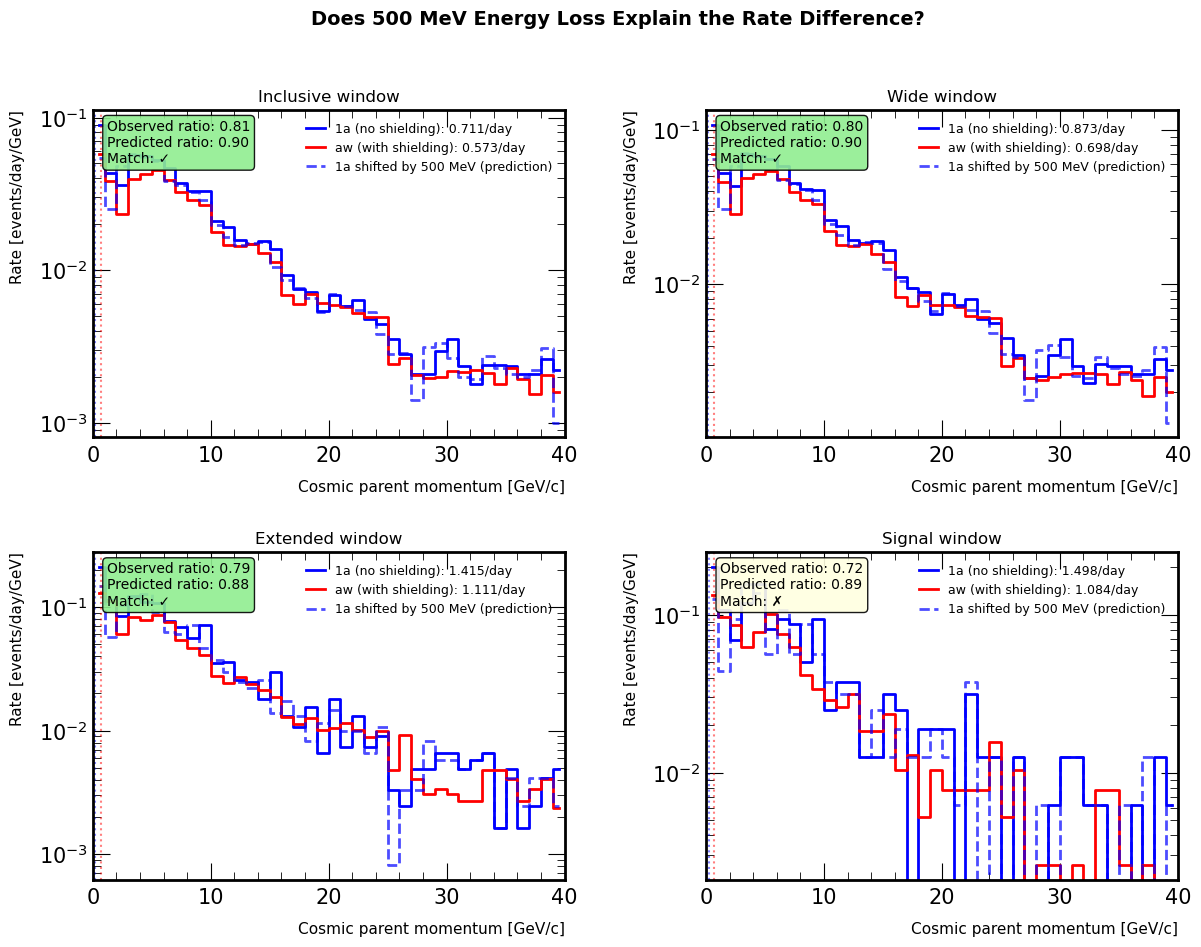


SHIELDING PREDICTION TEST: Does 500 MeV explain the rate difference?
Window       N_1a     N_aw     Observed     Predicted    Match?    
--------------------------------------------------------------------------------
inclusive    10626    20154    0.806        0.896        ✓ YES     
wide         10303    19574    0.799        0.898        ✓ YES     
extended     1723     3267     0.785        0.885        ✓ YES     
signal       239      416      0.724        0.891        ✗ NO      

Average observed ratio:  0.779
Average predicted ratio: 0.892
Difference: 0.114

~ REASONABLE AGREEMENT: Shielding is likely the dominant effect
Wrote ../../output/images/energy_loss/shielding_energy_scan_inclusive.png


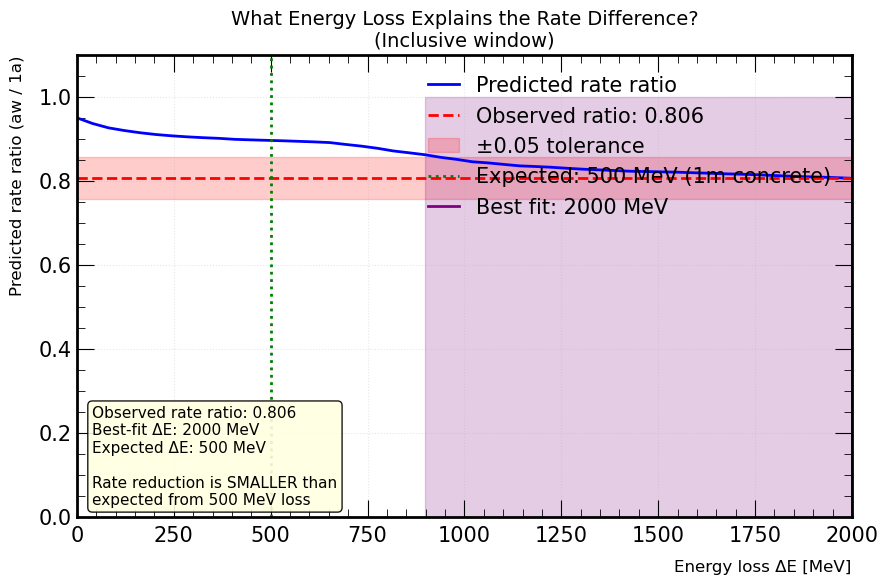


ENERGY LOSS SCAN: inclusive window
Observed rate ratio: 0.806
Best-fit energy loss: 2000 MeV
Uncertainty range: 898 - 2000 MeV
Expected (1m concrete): ~500 MeV
Wrote ../../output/images/energy_loss/shielding_statistical_test_inclusive.png


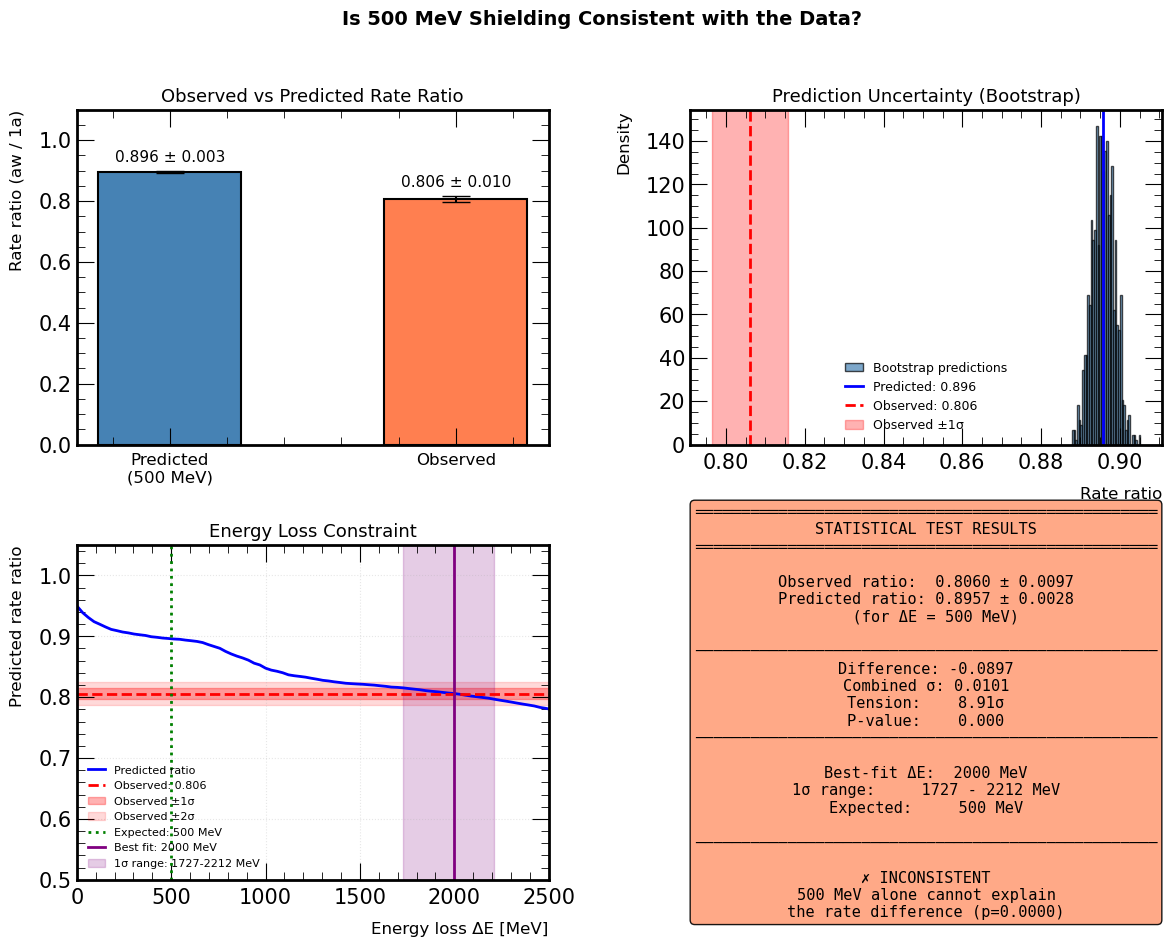


STATISTICAL TEST: Is 500 MeV consistent with observed rate?
Observed ratio:     0.8060 ± 0.0097  (Poisson)
Predicted ratio:    0.8957 ± 0.0028  (Bootstrap)
-----------------------------------------------------------------
Tension:            8.91σ
P-value:            0.0000
-----------------------------------------------------------------
Best-fit ΔE:        2000 MeV
1σ allowed range:   1727 - 2212 MeV
Expected (concrete): 500 MeV
-----------------------------------------------------------------
✗ 500 MeV is EXCLUDED at 100% CL
500 MeV predicts rate ratio: 0.896
Observed rate ratio: 0.806
Shielding contribution: 53%


In [109]:
if __name__ == "__main__":
    # Load and run
    data = CosmicAna.load_data()

    Print().print_n_events(data["1a"])
    
    analyzer = CosmicAna(data)
    
    # Run pipeline (pdg=None for all particles, or pdg=13 for muons only)
    print("Running analysis pipeline...")
    results = analyzer.run(pdg=None)
    
    # Print summary
    print("\n" + "="*60)
    print("Analysis Summary")
    print("="*60)
    for dataset in results:
        for window in results[dataset]:
            n_cosmic = results[dataset][window]["cosmic_parent"]["n_events"]
            n_track = results[dataset][window]["track_parent"]["n_events"]
            livetime = results[dataset][window]["livetime"]
            print(f"{dataset:>3} | {window:>9} | Cosmic: {n_cosmic:>5} | Track: {n_track:>5} | Livetime: {livetime:>8.2f}s")
    
    # Plot cosmic parents
    # print("\nPlotting cosmic parent momenta...")
    # CosmicAna.plot_mom_overlays(results)
    # CosmicAna.plot_mom_overlays(results, "track_parent")
    # CosmicAna.plot_mom_overlays(results, "track_reco", nbins=150, xrange=(50,200))

    # print("\nPlotting momentum difference...")
    # CosmicAna.plot_mom_diff_overlays(results, "cosmic_parent", "track_parent", nbins=160, xrange=(0,20))
    # # CosmicAna.plot_mom_diff_overlays(results, "cosmic_parent", "track_parent", nbins=80, xrange=(0,10))
    # # CosmicAna.plot_mom_diff_overlays(results, "cosmic_parent", "track_parent", nbins=25, xrange=(0,5))
    # # print("\nPlotting rate overlays...")
    # CosmicAna.plot_rate_overlays(results)

    # # print("\nPlotting rate ratio overlays...")
    # CosmicAna.plot_rate_ratios(results) 

    # print("\nPlotting rate ratio overlays...")
    # CosmicAna.analyze_ratio_slopes(results, nbins=8) 

    # # CosmicAna.plot_shielding_test(results) 
    # # CosmicAna.plot_shielding_test(results, window_name="signal") 

    # # CosmicAna.plot_energy_loss_test(results, window_name="signal") 

    # # CosmicAna.plot_combined_shielding_summary(results)

    # # CosmicAna.test_shielding_consistency(results)

    # # CosmicAna.power_analysis_shielding(results)
    
    # CosmicAna.plot_shielding_test(results) 
    # CosmicAna.plot_shielding_test(results) 

    # summary = CosmicAna.test_shielding_prediction(results, delta_E_MeV=500)
    # Test 1: Does 500 MeV explain the rate difference?
    summary = CosmicAna.test_shielding_prediction(results, delta_E_MeV=500)
    
    # Test 2: What energy loss WOULD explain the rate difference?
    scan = CosmicAna.scan_shielding_energy_loss(results, window_name="inclusive")

    result = CosmicAna.test_shielding_quantitative(results, delta_E_MeV=500, n_bootstrap=1000)

    # decomp = CosmicAna.plot_rate_decomposition(results, scan, delta_E_expected_MeV=500)

        # What rate ratio does 500 MeV predict?
    # From your scan, you can interpolate:
    idx_500 = np.argmin(np.abs(scan['delta_E_values'] - 500))
    predicted_ratio_500MeV = scan['predicted_ratios'][idx_500]
    
    print(f"500 MeV predicts rate ratio: {predicted_ratio_500MeV:.3f}")
    print(f"Observed rate ratio: 0.806")
    print(f"Shielding contribution: {(1 - predicted_ratio_500MeV) / (1 - 0.806) * 100:.0f}%")
    

In [42]:
# from typing import Dict, Tuple, Optional
# from dataclasses import dataclass
# import numpy as np
# import matplotlib.pyplot as plt

# @dataclass
# class MomentumWindow:
#     """Define momentum selection windows for track momentum"""
#     name: str
#     p_min: Optional[float] = None
#     p_max: Optional[float] = None


# class CosmicAna:
#     """Pipeline for cosmic ray momentum analysis with livetime weighting"""

#     # Livetime for each window (seconds)
#     LIVETIMES = {
#         "inclusive": {"aw": 35189, "1a": 14954},
#         "wide": {"aw": 28048, "1a": 11800},
#         "extended": {"aw": 2941, "1a": 1218},
#         "signal": {"aw": 383.89, "1a": 159.59},
#     }
    
#     # Momentum windows (GeV/c) - applied to TRACK momentum at TT_Front
#     WINDOWS = {
#         "inclusive": MomentumWindow("inclusive"),  # No cuts
#         "wide": MomentumWindow("wide", p_min=85, p_max=200),
#         "extended": MomentumWindow("extended", p_min=100, p_max=110),
#         "signal": MomentumWindow("signal", p_min=103.6, p_max=104.9),
#     }
    
#     # Plot styling
#     DATASET_STYLES = {
#         "aw": {"color": "red", "label": "Run-1 (MDC2020aw)"},
#         "1a": {"color": "blue", "label": "Run-1a (MDC2025)"},
#     }
    
#     def __init__(self, data: Dict):
#         self.data = data

#     @classmethod
#     def load_data(cls, base_path="../../output/results"):
#         """Load data from default paths"""
#         return {
#             "1a": Load(f"{base_path}/dev_CRY_onspill-LH_1a_noCRV").load_array_parquet(),
#             "aw": Load(f"{base_path}/dev_CRY_onspill-LH_aw_noCRV").load_array_parquet(),
#         }
    
#     # --- Event selection ---
#     def _select_by_window(self, data, window_name: str):
#         """
#         Select events based on track momentum window at TT_Front
#         Returns: filtered data with only events passing window cuts
#         """
#         # Get track momentum at TT_Front surface
#         trk_front = selector.select_surface(data["trkfit"], "TT_Front")
#         mom_mag = vector.get_mag(data["trkfit"]["trksegs"], "mom")
#         mom_mag = mom_mag[trk_front]
        
#         # Apply window cuts to track momentum
#         window = self.WINDOWS[window_name]
#         if window.p_min is None and window.p_max is None:
#             # Inclusive: no cuts
#             window_mask = ak.ones_like(mom_mag, dtype=bool)
#         else:
#             window_mask = ak.ones_like(mom_mag, dtype=bool)
#             if window.p_min is not None:
#                 window_mask = window_mask & (mom_mag > window.p_min)
#             if window.p_max is not None:
#                 window_mask = window_mask & (mom_mag < window.p_max)
        
#         window_mask = ak.flatten(window_mask, axis=-1)
        
#         # Apply mask to select events
#         selected_data = {
#             "trk": data["trk"][window_mask],
#             "trkfit": data["trkfit"][window_mask],
#             "trkmc": data["trkmc"][window_mask],
#         }
        
#         # Keep only events with tracks
#         has_trks = ak.any(selected_data["trk"]["trk.pdg"], axis=-1)
#         for key in selected_data:
#             selected_data[key] = selected_data[key][has_trks]
        
#         return selected_data
    
#     # --- Parent momentum extraction ---
#     def _get_parent_mom(self, parents) -> ak.Array:
#         """Extract momentum magnitude from parents"""
#         mom_mag = vector.get_mag(parents, "mom")
#         mom_mag = ak.firsts(mom_mag, axis=-1)
#         mom_mag = ak.flatten(mom_mag, axis=None)
#         return mom_mag
    
#     def _get_cosmic_parents(self, data, pdg: Optional[int] = None) -> ak.Array:
#         """Get cosmic parents (rank == -1)"""
#         rank_mask = data["trkmc"]["trkmcsim"]["rank"] == -1
        
#         if pdg:
#             pdg_mask = data["trkmc"]["trkmcsim"]["pdg"] == pdg
#             condition = rank_mask & pdg_mask
#         else:
#             condition = rank_mask
        
#         return data["trkmc"]["trkmcsim"][condition]
    
#     def _get_track_parents(self, data, pdg: Optional[int] = None) -> ak.Array:
#         """Get track parents (max nhits)"""
#         nhits_mask = data["trkmc"]["trkmcsim"]["nhits"] == \
#                      ak.max(data["trkmc"]["trkmcsim"]["nhits"], axis=-1)
        
#         if pdg:
#             pdg_mask = data["trkmc"]["trkmcsim"]["pdg"] == pdg
#             condition = nhits_mask & pdg_mask
#         else:
#             condition = nhits_mask
        
#         return data["trkmc"]["trkmcsim"][condition]
    
#     def get_cosmic_parent_mom(self, data, pdg: Optional[int] = None) -> ak.Array:
#         """Extract cosmic parent momentum magnitudes"""
#         cosmic_parents = self._get_cosmic_parents(data, pdg)
#         return self._get_parent_mom(cosmic_parents)
    
#     def get_track_parent_mom(self, data, pdg: Optional[int] = None) -> ak.Array:
#         """Extract track parent momentum magnitudes"""
#         track_parents = self._get_track_parents(data, pdg)
#         return self._get_parent_mom(track_parents)
    
#     def _create_weights(self, n_events: int, livetime: float) -> np.ndarray:
#         """Create weights array: 1/livetime for each event"""
#         return np.ones(n_events) / livetime
    
#     # --- Main pipeline ---
#     def run(self, pdg: Optional[int] = None, windows: list = None, 
#             convert_to_GeV: bool = True) -> Dict:
#         """
#         Run full analysis pipeline
        
#         Workflow:
#         1. For each dataset and window:
#         2. Select events based on track momentum at TT_Front passing window cuts
#         3. Extract parent momenta from selected events
#         4. Create livetime weights
        
#         Args:
#             pdg: Particle PDG code to filter (e.g., 13 for muons)
#             windows: List of window names to process (default: all)
#             convert_to_GeV: Convert momenta from GeV to GeV
        
#         Returns:
#             Nested dict: {dataset: {window: {parent_type: {mom, weights}}}}
#         """
#         if windows is None:
#             windows = list(self.WINDOWS.keys())
        
#         results = {}
        
#         for dataset_name, dataset in self.data.items():
#             print(f"\nProcessing dataset: {dataset_name}")
#             results[dataset_name] = {}
            
#             # Apply each window
#             for window_name in windows:
#                 print(f"  - Applying {window_name} window...")
                
#                 # Select events based on track momentum at TT_Front
#                 selected_data = self._select_by_window(dataset, window_name)
                
#                 # Extract parent momenta from selected events
#                 cosmic_mom = self.get_cosmic_parent_mom(selected_data, pdg=pdg)
#                 track_mom = self.get_track_parent_mom(selected_data, pdg=pdg)
                
#                 # Convert to numpy
#                 cosmic_mom_np = ak.to_numpy(cosmic_mom)
#                 track_mom_np = ak.to_numpy(track_mom)
                
#                 # Optional: convert GeV -> GeV
#                 if convert_to_GeV:
#                     cosmic_mom_np = cosmic_mom_np * 1e-3
#                     track_mom_np = track_mom_np * 1e-3
                
#                 # Get livetime for this window/dataset
#                 livetime = self.LIVETIMES[window_name][dataset_name]
                
#                 # Create weights: 1/livetime per event
#                 cosmic_weights = self._create_weights(len(cosmic_mom_np), livetime)
#                 track_weights = self._create_weights(len(track_mom_np), livetime)
                
#                 results[dataset_name][window_name] = {
#                     "cosmic": {
#                         "mom": cosmic_mom_np,
#                         "weights": cosmic_weights,
#                         "n_events": len(cosmic_mom_np),
#                     },
#                     "track": {
#                         "mom": track_mom_np,
#                         "weights": track_weights,
#                         "n_events": len(track_mom_np),
#                     },
#                     "livetime": livetime,
#                 }
        
#         return results
    
#     # --- Plotting methods ---
#     def plot_window_comparison(self, results: Dict, window: str, parent_type: str,
#                                bins: int = 20, mom_range: Tuple[float, float] = (0, 40),
#                                log_scale: bool = True, ax: Optional[plt.Axes] = None) -> plt.Axes:
#         """
#         Plot momentum comparison for one window
        
#         Args:
#             results: Output from run()
#             window: Window name (e.g., "signal")
#             parent_type: "cosmic" or "track"
#             bins: Number of histogram bins
#             mom_range: (min, max) momentum range in GeV
#             log_scale: Use log scale for y-axis
#             ax: Matplotlib axes (creates new if None)
        
#         Returns:
#             Matplotlib axes object
#         """
#         if ax is None:
#             fig, ax = plt.subplots(figsize=(8, 6))
        
#         # Plot each dataset
#         for dataset_name in ["aw", "1a"]:  # Order matters for legend
#             data = results[dataset_name][window][parent_type]
#             style = self.DATASET_STYLES[dataset_name]
            
#             ax.hist(data["mom"], bins=bins, range=mom_range, 
#                    weights=data["weights"], histtype='step',
#                    label=style["label"], color=style["color"], linewidth=1.5)
        
#         # Styling
#         parent_label = "Cosmic" if parent_type == "cosmic" else "Track"
#         ax.set_xlabel('Momentum [GeV/c]', fontsize=12)
#         ax.set_ylabel('Selected tracks / day', fontsize=12)
#         ax.set_title(f'{parent_label} Parent Momentum - {window.capitalize()} Window', 
#                     fontsize=13)
        
#         if log_scale:
#             ax.set_yscale('log')
        
#         ax.legend(fontsize=10)
#         ax.grid(alpha=0.3)
        
#         return ax
    
#     def plot_all_windows(self, results: Dict, parent_type: str = "cosmic",
#                         bins: int = 20, mom_range: Tuple[float, float] = (0, 40),
#                         log_scale: bool = True, save_path: Optional[str] = None):
#         """
#         Create 2x2 grid of plots for all momentum windows
        
#         Args:
#             results: Output from run()
#             parent_type: "cosmic" or "track"
#             bins: Number of histogram bins
#             mom_range: (min, max) momentum range in GeV
#             log_scale: Use log scale for y-axis
#             save_path: Optional path to save figure
#         """
#         fig, axes = plt.subplots(2, 2, figsize=(14, 10))
#         axes = axes.flatten()
        
#         windows = ["inclusive", "wide", "extended", "signal"]
        
#         for idx, window in enumerate(windows):
#             self.plot_window_comparison(
#                 results, window, parent_type,
#                 bins=bins, mom_range=mom_range, 
#                 log_scale=log_scale, ax=axes[idx]
#             )
        
#         plt.tight_layout()
        
#         if save_path:
#             plt.savefig(save_path, dpi=300, bbox_inches='tight')
#             print(f"Saved plot to {save_path}")
        
#         plt.show()
    
#     def plot_all(self, results: Dict, bins: int = 20, 
#                 mom_range: Tuple[float, float] = (0, 40),
#                 log_scale: bool = True, save_dir: Optional[str] = None):
#         """
#         Create all plots (cosmic + track parents, all windows)
        
#         Args:
#             results: Output from run()
#             bins: Number of histogram bins
#             mom_range: (min, max) momentum range in GeV
#             log_scale: Use log scale for y-axis
#             save_dir: Optional directory to save figures
#         """
#         for parent_type in ["cosmic", "track"]:
#             save_path = None
#             if save_dir:
#                 save_path = f"{save_dir}/{parent_type}_parent_comparison.png"
            
#             self.plot_all_windows(
#                 results, parent_type, bins=bins, 
#                 mom_range=mom_range, log_scale=log_scale,
#                 save_path=save_path
#             )


# # --- Usage ---
# if __name__ == "__main__":
#     # Load and run
#     data = CosmicAna.load_data()
#     analyzer = CosmicAna(data)
    
#     # Run pipeline (pdg=13 for muons)
#     print("Running analysis pipeline...")
#     results = analyzer.run(pdg=13)
    
#     # Print summary
#     print("\n" + "="*60)
#     print("Analysis Summary")
#     print("="*60)
#     for dataset in results:
#         for window in results[dataset]:
#             n_cosmic = results[dataset][window]["cosmic"]["n_events"]
#             n_track = results[dataset][window]["track"]["n_events"]
#             livetime = results[dataset][window]["livetime"]
#             print(f"{dataset:>3} | {window:>9} | Cosmic: {n_cosmic:>5} | Track: {n_track:>5} | Livetime: {livetime:>8.2f}s")
    
#     # Plot single window (your exact example)
#     print("\nCreating single window plot...")
#     fig, ax = plt.subplots()
#     mom_aw = results["aw"]["signal"]["cosmic"]["mom"]
#     mom_1a = results["1a"]["signal"]["cosmic"]["mom"]
#     weights_aw = results["aw"]["signal"]["cosmic"]["weights"]
#     weights_1a = results["1a"]["signal"]["cosmic"]["weights"]
    
#     ax.hist(mom_aw, bins=20, range=(0, 40), weights=weights_aw, 
#             histtype='step', label='Run-1 (MDC2020aw)', color='red')
#     ax.hist(mom_1a, bins=20, range=(0, 40), weights=weights_1a, 
#             histtype='step', label='Run-1a (MDC2025)', color='blue')
#     ax.set_xlabel('Cosmic parent momentum [GeV/c]')
#     ax.set_ylabel('Selected tracks / day')
#     ax.set_yscale('log')
#     ax.legend()
#     plt.show()
    
#     # Plot all windows for cosmic parents
#     print("\nCreating 2x2 grid for cosmic parents...")
#     analyzer.plot_all_windows(results, parent_type="cosmic")
    
#     # Plot all windows for track parents
#     print("\nCreating 2x2 grid for track parents...")
#     analyzer.plot_all_windows(results, parent_type="track")
    
#     # Or plot everything at once
#     # analyzer.plot_all(results, save_dir="./plots")

In [5]:
# import pickle
# import awkward as ak
# import numpy as np
# import matplotlib.pyplot as plt
# from typing import Dict, Tuple, Optional
# from dataclasses import dataclass

# from pyutils.pyprint import Print
# from pyutils.pylogger import Logger
# from pyutils.pyselect import Select
# from pyutils.pycut import CutManager
# from pyutils.pyplot import Plot
# from pyutils.pyvector import Vector

# import sys
# sys.path.extend(["../../src/utils"])
# from io_manager import Load

# # Make everything available when using "from preamble import *"
# __all__ = ["Logger", "Print", "Load", "Draw"] 


# printer = Print()
# selector = Select()
# logger = Logger()
# plotter = Plot()
# vector = Vector()


# @dataclass
# class MomentumWindow:
#     """Define momentum selection windows"""
#     name: str
#     p_min: Optional[float] = None
#     p_max: Optional[float] = None
    
#     def apply(self, mom_mag):
#         """Apply momentum cuts"""
#         if self.p_min is None and self.p_max is None:
#             return ak.ones_like(mom_mag, dtype=bool)
        
#         mask = ak.ones_like(mom_mag, dtype=bool)
#         if self.p_min is not None:
#             mask = mask & (mom_mag > self.p_min)
#         if self.p_max is not None:
#             mask = mask & (mom_mag < self.p_max)
#         return mask


# class CosmicAna:
#     """Pipeline for cosmic ray momentum analysis with livetime weighting"""

#     # Livetime for each window (seconds)
#     LIVETIMES = {
#         "inclusive": {"aw": 35189, "1a": 14954},
#         "wide": {"aw": 28048, "1a": 11800},
#         "extended": {"aw": 2941, "1a": 1218},
#         "signal": {"aw": 383.89, "1a": 159.59},
#     }
    
#     # Momentum windows (GeV/c)
#     WINDOWS = {
#         "inclusive": MomentumWindow("inclusive"),
#         "wide": MomentumWindow("wide", p_min=85, p_max=200),
#         "extended": MomentumWindow("extended", p_min=100, p_max=110),
#         "signal": MomentumWindow("signal", p_min=103.6, p_max=104.9),
#     }
    
#     # Plot styling
#     DATASET_STYLES = {
#         "aw": {"color": "red", "label": "Run-1 (MDC2020aw)"},
#         "1a": {"color": "blue", "label": "Run-1a (MDC2025)"},
#     }
    
#     def __init__(self, data: Dict):
#         self.data = data

#     @classmethod
#     def load_data(cls, base_path="../../output/results"):
#         """Load data from default paths"""
#         return {
#             "1a": Load(f"{base_path}/dev_CRY_onspill-LH_1a_noCRV").load_array_parquet(),
#             "aw": Load(f"{base_path}/dev_CRY_onspill-LH_aw_noCRV").load_array_parquet(),
#         }
    
#     # --- Core extraction methods ---
#     def _get_parent_mom(self, parents) -> ak.Array:
#         """Extract momentum magnitude from parents"""
#         mom_mag = vector.get_mag(parents, "mom")
#         mom_mag = ak.firsts(mom_mag, axis=-1)
#         mom_mag = ak.flatten(mom_mag, axis=None)
#         return mom_mag
    
#     def _get_cosmic_parents(self, data, pdg: Optional[int] = None) -> ak.Array:
#         """Get cosmic parents (rank == -1)"""
#         rank_mask = data["trkmc"]["trkmcsim"]["rank"] == -1
        
#         if pdg:
#             pdg_mask = data["trkmc"]["trkmcsim"]["pdg"] == pdg
#             condition = rank_mask & pdg_mask
#         else:
#             condition = rank_mask
        
#         return data["trkmc"]["trkmcsim"][condition]
    
#     def _get_track_parents(self, data, pdg: Optional[int] = None) -> ak.Array:
#         """Get track parents (max nhits)"""
#         nhits_mask = data["trkmc"]["trkmcsim"]["nhits"] == \
#                      ak.max(data["trkmc"]["trkmcsim"]["nhits"], axis=-1)
        
#         if pdg:
#             pdg_mask = data["trkmc"]["trkmcsim"]["pdg"] == pdg
#             condition = nhits_mask & pdg_mask
#         else:
#             condition = nhits_mask
        
#         return data["trkmc"]["trkmcsim"][condition]
    
#     def get_cosmic_parent_mom(self, data, pdg: Optional[int] = None) -> ak.Array:
#         """Extract cosmic parent momentum magnitudes"""
#         cosmic_parents = self._get_cosmic_parents(data, pdg)
#         return self._get_parent_mom(cosmic_parents)
    
#     def get_track_parent_mom(self, data, pdg: Optional[int] = None) -> ak.Array:
#         """Extract track parent momentum magnitudes"""
#         track_parents = self._get_track_parents(data, pdg)
#         return self._get_parent_mom(track_parents)
    
#     # --- Window selection ---
#     def apply_window_selection(self, mom_array: ak.Array, window_name: str) -> ak.Array:
#         """Apply momentum window cuts"""
#         window = self.WINDOWS[window_name]
#         mask = window.apply(mom_array)
#         return mom_array[mask]
    
#     def _create_weights(self, n_events: int, livetime: float) -> np.ndarray:
#         """Create weights array: 1/livetime for each event"""
#         return np.ones(n_events) / livetime
    
#     # --- Main pipeline ---
#     def run(self, pdg: Optional[int] = None, windows: list = None, 
#             convert_to_GeV: bool = True) -> Dict:

#         if windows is None:
#             windows = list(self.WINDOWS.keys())
        
#         results = {}
        
#         for dataset_name, dataset in self.data.items():
#             print(f"\nProcessing dataset: {dataset_name}")
#             results[dataset_name] = {}
            
#             # Extract all momenta (before window cuts)
#             cosmic_mom_all = self.get_cosmic_parent_mom(dataset, pdg=pdg)
#             track_mom_all = self.get_track_parent_mom(dataset, pdg=pdg)
            
#             # Apply each window
#             for window_name in windows:
#                 print(f"\tApplying {window_name} window...")
                
#                 # Apply window cuts
#                 cosmic_mom = self.apply_window_selection(cosmic_mom_all, window_name)
#                 track_mom = self.apply_window_selection(track_mom_all, window_name)
                
#                 # Convert to numpy
#                 cosmic_mom_np = ak.to_numpy(cosmic_mom)
#                 track_mom_np = ak.to_numpy(track_mom)
                
#                 # Optional: convert GeV -> GeV
#                 if convert_to_GeV:
#                     cosmic_mom_np = cosmic_mom_np * 1e-3
#                     track_mom_np = track_mom_np * 1e-3
                
#                 # Get livetime for this window/dataset
#                 livetime = self.LIVETIMES[window_name][dataset_name]
                
#                 # Create weights: 1/livetime per event
#                 cosmic_weights = self._create_weights(len(cosmic_mom_np), livetime)
#                 track_weights = self._create_weights(len(track_mom_np), livetime)
                
#                 results[dataset_name][window_name] = {
#                     "cosmic": {
#                         "mom": cosmic_mom_np,
#                         "weights": cosmic_weights,
#                         "n_events": len(cosmic_mom_np),
#                     },
#                     "track": {
#                         "mom": track_mom_np,
#                         "weights": track_weights,
#                         "n_events": len(track_mom_np),
#                     },
#                     "livetime": livetime,
#                 }
        
#         return results
    
#     # # --- Plotting methods ---
#     # def plot_window_comparison(self, results: Dict, window: str, parent_type: str,
#     #                            bins: int = 20, mom_range: Tuple[float, float] = (0, 40),
#     #                            log_scale: bool = True, ax: Optional[plt.Axes] = None) -> plt.Axes:
#     #     if ax is None:
#     #         fig, ax = plt.subplots() # figsize=(8, 6))
        
#     #     # Plot each dataset
#     #     for dataset_name in ["aw", "1a"]:  # Order matters for legend
#     #         data = results[dataset_name][window][parent_type]
#     #         # style = self.DATASET_STYLES[dataset_name]

#     #         Plot().plot_1D_overlay(
                
            
#     #         # ax.hist(data["mom"], bins=bins, range=mom_range, 
#     #         #        weights=data["weights"], histtype='step',
#     #         #        label=style["label"], color=style["color"]) # , linewidth=1.5)
        
#     #     # Styling
#     #     parent_label = "Cosmic" if parent_type == "cosmic" else "Track"
#     #     ax.set_xlabel('Momentum [GeV/c]') # , fontsize=12)
#     #     ax.set_ylabel('Selected tracks / day') # , fontsize=12)
#     #     ax.set_title(f'{parent_label} parent momentum ({window} window)')
        
#     #     if log_scale:
#     #         ax.set_yscale('log')
        
#     #     ax.legend() # fontsize=10)
#     #     ax.grid() # alpha=0.3)
        
#     #     return ax
    
#     # def plot_all_windows(self, results: Dict, parent_type: str = "cosmic",
#     #                     bins: int = 20, mom_range: Tuple[float, float] = (0, 40),
#     #                     log_scale: bool = True, save_path: Optional[str] = None):
#     #     """
#     #     Create 2x2 grid of plots for all momentum windows
        
#     #     Args:
#     #         results: Output from run()
#     #         parent_type: "cosmic" or "track"
#     #         bins: Number of histogram bins
#     #         mom_range: (min, max) momentum range in GeV
#     #         log_scale: Use log scale for y-axis
#     #         save_path: Optional path to save figure
#     #     """
#     #     fig, axes = plt.subplots(2, 2, figsize=(2*6.4, 2*4.8))
#     #     axes = axes.flatten()
        
#     #     windows = ["inclusive", "wide", "extended", "signal"]
        
#     #     for idx, window in enumerate(windows):
#     #         self.plot_window_comparison(
#     #             results, window, parent_type,
#     #             bins=bins, mom_range=mom_range, 
#     #             log_scale=log_scale, ax=axes[idx]
#     #         )
        
#     #     plt.tight_layout()
        
#     #     if save_path:
#     #         plt.savefig(save_path) # , dpi=300, bbox_inches='tight')
#     #         print(f"Saved plot to {save_path}")
        
#     #     plt.show()
    
#     # def plot_all(self, results: Dict, bins: int = 20, 
#     #             mom_range: Tuple[float, float] = (0, 40),
#     #             log_scale: bool = True, save_dir: Optional[str] = None):
#     #     """
#     #     Create all plots (cosmic + track parents, all windows)
        
#     #     Args:
#     #         results: Output from run()
#     #         bins: Number of histogram bins
#     #         mom_range: (min, max) momentum range in GeV
#     #         log_scale: Use log scale for y-axis
#     #         save_dir: Optional directory to save figures
#     #     """
#     #     for parent_type in ["cosmic", "track"]:
#     #         save_path = None
#     #         if save_dir:
#     #             save_path = f"{save_dir}/{parent_type}_parent_comparison.png"
            
#     #         self.plot_all_windows(
#     #             results, parent_type, bins=bins, 
#     #             mom_range=mom_range, log_scale=log_scale,
#     #             save_path=save_path
#     #         )

# if __name__ == "__main__":
#     # Load and run
#     data = CosmicAna.load_data()
#     analyzer = CosmicAna(data)
    
#     # Run pipeline (pdg=13 for muons)
#     results = analyzer.run(pdg=13)
    
#     # Plot single window
#     fig, ax = plt.subplots()
#     analyzer.plot_window_comparison(results, window="signal", parent_type="cosmic", ax=ax)
#     plt.show()
    
#     # Plot all windows for cosmic parents
#     analyzer.plot_all_windows(results, parent_type="cosmic", save_path="cosmic_comparison.png")
    
#     # Plot everything (cosmic + track, all windows)
#     analyzer.plot_all(results, save_dir="../../output/images/energy_loss/")
    
#     # Custom plot with your exact parameters
#     fig, ax = plt.subplots()
#     mom_aw = results["aw"]["signal"]["cosmic"]["mom"]
#     mom_1a = results["1a"]["signal"]["cosmic"]["mom"]
#     weights_aw = results["aw"]["signal"]["cosmic"]["weights"]
#     weights_1a = results["1a"]["signal"]["cosmic"]["weights"]
    
#     ax.hist(mom_aw, bins=20, range=(0, 40), weights=weights_aw, 
#             histtype='step', label='Run-1 (MDC2020aw)', color='red')
#     ax.hist(mom_1a, bins=20, range=(0, 40), weights=weights_1a, 
#             histtype='step', label='Run-1a (MDC2025)', color='blue')
#     ax.set_xlabel('Cosmic parent momentum [GeV/c]')
#     ax.set_ylabel('Selected tracks / day')
#     ax.set_yscale('log')
#     ax.legend()
#     plt.show()

In [6]:
# Need to be able to produce ONE object which contains cosmic parent and track parent momenta across all windows AND has each event contributes 1/livetime instead of 1

In [7]:
# from typing import Dict, Tuple, Optional
# from dataclasses import dataclass

# @dataclass
# class MomentumWindow:
#     """Define momentum selection windows"""
#     name: str
#     p_min: Optional[float] = None
#     p_max: Optional[float] = None
    
#     def apply(self, mom_mag):
#         """Apply momentum cuts"""
#         if self.p_min is None and self.p_max is None:
#             return ak.ones_like(mom_mag, dtype=bool)  # inclusive: no cuts
        
#         mask = ak.ones_like(mom_mag, dtype=bool)
#         if self.p_min is not None:
#             mask = mask & (mom_mag > self.p_min)
#         if self.p_max is not None:
#             mask = mask & (mom_mag < self.p_max)
#         return mask


# class CosmicAna:
#     """Pipeline for cosmic ray momentum analysis across selection windows"""

#     # Livetime for each window (seconds)
#     LIVETIMES = {
#         "inclusive": {"aw": 35189, "1a": 14954},
#         "wide": {"aw": 28048, "1a": 11800},
#         "extended": {"aw": 2941, "1a": 1218},
#         "signal": {"aw": 383.89, "1a": 159.59},
#     }
    
#     # Momentum windows (GeV/c)
#     WINDOWS = {
#         "inclusive": MomentumWindow("inclusive"),  # No cuts
#         "wide": MomentumWindow("wide", p_min=85, p_max=200),
#         "extended": MomentumWindow("extended", p_min=100, p_max=110),
#         "signal": MomentumWindow("signal", p_min=103.6, p_max=104.9),
#     }
    
#     def __init__(self, data: Dict):
#         self.data = data

#     @classmethod
#     def load_data(cls, base_path="../../output/results"):
#         """Load data from default paths"""
#         return {
#             "1a": Load(f"{base_path}/dev_CRY_onspill-LH_1a_noCRV").load_array_parquet(),
#             "aw": Load(f"{base_path}/dev_CRY_onspill-LH_aw_noCRV").load_array_parquet(),
#         }
    
#     # --- Core extraction methods ---
#     def _get_parent_mom(self, parents) -> ak.Array:
#         """Extract momentum magnitude from parents"""
#         mom_mag = vector.get_mag(parents, "mom")
#         mom_mag = ak.firsts(mom_mag, axis=-1)
#         mom_mag = ak.flatten(mom_mag, axis=None)
#         return mom_mag
    
#     def _get_cosmic_parents(self, data, pdg: Optional[int] = None) -> ak.Array:
#         """Get cosmic parents (rank == -1)"""
#         rank_mask = data["trkmc"]["trkmcsim"]["rank"] == -1
        
#         if pdg:
#             pdg_mask = data["trkmc"]["trkmcsim"]["pdg"] == pdg
#             condition = rank_mask & pdg_mask
#         else:
#             condition = rank_mask
        
#         return data["trkmc"]["trkmcsim"][condition]
    
#     def _get_track_parents(self, data, pdg: Optional[int] = None) -> ak.Array:
#         """Get track parents (max nhits)"""
#         nhits_mask = data["trkmc"]["trkmcsim"]["nhits"] == \
#                      ak.max(data["trkmc"]["trkmcsim"]["nhits"], axis=-1)
        
#         if pdg:
#             pdg_mask = data["trkmc"]["trkmcsim"]["pdg"] == pdg
#             condition = nhits_mask & pdg_mask
#         else:
#             condition = nhits_mask
        
#         return data["trkmc"]["trkmcsim"][condition]
    
#     def get_cosmic_parent_mom(self, data, pdg: Optional[int] = None) -> ak.Array:
#         """Extract cosmic parent momentum magnitudes"""
#         cosmic_parents = self._get_cosmic_parents(data, pdg)
#         return self._get_parent_mom(cosmic_parents)
    
#     def get_track_parent_mom(self, data, pdg: Optional[int] = None) -> ak.Array:
#         """Extract track parent momentum magnitudes"""
#         track_parents = self._get_track_parents(data, pdg)
#         return self._get_parent_mom(track_parents)
    
#     # --- Window selection ---
#     def apply_window_selection(self, mom_array: ak.Array, window_name: str) -> ak.Array:
#         """Apply momentum window cuts"""
#         window = self.WINDOWS[window_name]
#         mask = window.apply(mom_array)
#         return mom_array[mask]
    
#     # --- Main pipeline ---
#     def run(self, pdg: Optional[int] = None, windows: list = None) -> Dict:
#         """
#         Run full analysis pipeline
        
#         Returns nested dict: {dataset: {window: {parent_type: momentum_array}}}
#         """
#         if windows is None:
#             windows = list(self.WINDOWS.keys())
        
#         results = {}
        
#         for dataset_name, dataset in self.data.items():
#             print(f"\nProcessing dataset: {dataset_name}")
#             results[dataset_name] = {}
            
#             # Extract all momenta (before window cuts)
#             cosmic_mom_all = self.get_cosmic_parent_mom(dataset, pdg=pdg)
#             track_mom_all = self.get_track_parent_mom(dataset, pdg=pdg)
            
#             # Apply each window
#             for window_name in windows:
#                 print(f"  - Applying {window_name} window...")
                
#                 cosmic_mom = self.apply_window_selection(cosmic_mom_all, window_name)
#                 track_mom = self.apply_window_selection(track_mom_all, window_name)
                
#                 results[dataset_name][window_name] = {
#                     "cosmic_parent_mom": cosmic_mom,
#                     "track_parent_mom": track_mom,
#                     "n_cosmic": len(cosmic_mom),
#                     "n_track": len(track_mom),
#                     "livetime": self.LIVETIMES[window_name][dataset_name]
#                 }
        
#         return results
    
#     def get_rates(self, results: Dict) -> Dict:
#         """Calculate rates from momentum results"""
#         rates = {}
        
#         for dataset_name, windows in results.items():
#             rates[dataset_name] = {}
            
#             for window_name, data in windows.items():
#                 livetime = data["livetime"]
#                 rates[dataset_name][window_name] = {
#                     "cosmic_rate": data["n_cosmic"] / livetime,
#                     "track_rate": data["n_track"] / livetime,
#                 }
        
#         return rates


# # --- Usage ---
# if __name__ == "__main__":
#     # Load and run
#     data = CosmicAna.load_data()
#     analyzer = CosmicAna(data)
    
#     # Run pipeline (optionally filter by PDG, e.g., muons = 13)
#     results = analyzer.run(pdg=13)
    
#     # Access results
#     print("\n--- Results Structure ---")
#     for dataset in results:
#         for window in results[dataset]:
#             n_cosmic = results[dataset][window]["n_cosmic"]
#             n_track = results[dataset][window]["n_track"]
#             print(f"{dataset}/{window}: {n_cosmic} cosmic, {n_track} track")
    
#     # Get specific momentum array
#     signal_cosmic_1a = results["1a"]["signal"]["cosmic_parent_mom"]
#     print(f"\nSignal window cosmic momenta (1a): {signal_cosmic_1a}")
    
#     # Calculate rates
#     rates = analyzer.get_rates(results)
#     print(f"\nRates: {rates}")

In [8]:
# class CosmicAna():
#     """
#     A bit of a mess here? 
#     Trying to run an analysis pipeline
#     """

#     # Class global: livetimes / window
#     LIVETIMES = {
#             "inclusive": { "aw" : 35189, "1a": 14954},
#             "wide" : { "aw" : 28048, "1a": 11800},
#             "extended" : { "aw" : 2941, "1a": 1218},
#             "signal" : { "aw" : 383.89, "1a": 159.59},
#     }
    
#     def __init__(self, data):
#         self.data = data

#     # def _append_array(self, data, arr, name):
#     #     try:
#     #         if "dev" not in ak.fields(data):
#     #             # Initialise dev field - structure will be determined by first array added
#     #             data = ak.with_field(data, ak.zip({name: arr}, depth_limit=1), "dev")
#     #         else: 
#     #             # Add new field to existing 'dev' record
#     #             new_dev = ak.with_field(data.dev, arr, name)
#     #             data = ak.with_field(data, new_dev, "dev")
#     #         return data
#     #     except Exception as e:
#     #         print("Error appending '{name}' to data array: {e}")
#     #         raise e

#     def _get_parent_mom(self, parents):
#         try:
#             mom_mag = vector.get_mag(parents, "mom")
#             mom_mag = ak.firsts(mom_mag, axis=-1)
#             mom_mag = ak.flatten(mom_mag, axis=None)
#             return mom_mag
#         except Exception as e:
#             print(f"Exception in '_get_parent_mom': {e}")
#             raise e
        
#     def get_cosmic_parent_mom(self, data, pdg=None):
#         try:
#             rank_mask = data["trkmc"]["trkmcsim"]["rank"] == -1
            
#             if pdg:
#                 pdg_mask = data["trkmc"]["trkmcsim"]["pdg"] == pdg 
#                 print(f"pdg {pdg}")
#                 condition = rank_mask & pdg_mask
#             else:
#                 condition = rank_mask 
    
#             cosmic_parents = data["trkmc"]["trkmcsim"][condition]

#             mom_mag = self._get_parent_mom(cosmic_parents)

#             # data = self._append_array(data, mom_mag, "cosmic_parent_mom")

#             # print("Got cosmic parent momenta")

#             return {
#                 "cosmic_parent_mom": mom_mag
#             }
            
#         except Exception as e:
#             print(f"Exception in 'get_cosmic_parent_mom': {e}")

#     def get_track_parent_mom(self, data, pdg=None):
#         try:
#             nhits_mask = data["trkmc"]["trkmcsim"]["nhits"] == ak.max(data["trkmc"]["trkmcsim"]["nhits"], axis=-1)
#             if pdg:
#                 pdg_mask = data["trkmc"]["trkmcsim"]["pdg"] == pdg 
#                 print(f"pdg {pdg}")
#                 condition = nhits_mask & pdg_mask
#             else:
#                 condition = nhits_mask 

#             track_parents = data["trkmc"]["trkmcsim"][condition]

#             return self._get_parent_mom(track_parents)
            
#         except Exception as e:
#             print(f"ERROR in 'get_track_parent_mom': {e}")
#             raise e

#     def select_window():
#         # Wide: 85 < p < 200 GeV/c
#         # Extended: 100 < p < 110 GeV/c
#         # Signal: 103.6 < p < 104.9 GeV/c
        
#         trk_front = selector.select_surface(data["trkfit"], "TT_Front")
#         mom_mag = vector.get_mag(data["trkfit"]["trksegs"], "mom")
#         mom_mag = mom_mag[trk_front]
#         data["mom_mag"] = mom_mag
        
#         within_sig_win = (mom_mag > 103.6) & (mom_mag < 104.9) 
#         within_sig_win = ak.flatten(within_sig_win, axis=-1)
#         data["within_sig_win"] = within_sig_win
        
        
#         data["trk"] = data["trk"][within_sig_win]
#         data["trkfit"] = data["trkfit"][within_sig_win]
#         data["trkmc"] = data["trkmc"][within_sig_win]
    
#         has_trks = ak.any(data["trk"]["trk.pdg"], axis=-1)
#         data = data[has_trks]
#         return data

#     def get_rate_per_mom(self):
#         pass

#     @classmethod
#     def load_data(cls, base_path="../../output/results"):
#         """Load data from default paths"""
#         return {
#             "1a": Load(f"{base_path}/dev_CRY_onspill-LH_1a_noCRV").load_array_parquet(),
#             "aw": Load(f"{base_path}/dev_CRY_onspill-LH_aw_noCRV").load_array_parquet(),
#         }

#     def run(self, data=None, pdg=None):
#         """Run pipeline"""

#         if data is None:
#             data = self.data

#         results = {}
        
#         for name, arr in data.items():
#             print(f"Processing {name}...")
#             results[name] = self.get_cosmic_parent_mom(arr, pdg=pdg)
#             results[name] = self.get_track_parent_mom(arr, pdg=pdg)
            
            
        
#         return results
        
#     # def exectute(self, data, pdg=None):
        
#     #     data = {
#     #         "1a": Load("../../output/results/dev_CRY_onspill-LH_1a_noCRV").load_array_parquet(),
#     #         "aw": Load("../../output/results/dev_CRY_onspill-LH_aw_noCRV").load_array_parquet(),
#     #     }

#     #     print(data)
#     #     for name, arr in data.items():
#     #         print(name, arr)
#     #         # data[name] = self.get_cosmic_parent_mom(arr)
#     #         break
#     #     # result = {}
#     #     # result["
#     #     return data 

#         # Get cosmic parent momentum 
        

# # data = {
# #     "1a": Load("../../output/results/dev_CRY_onspill-LH_1a_noCRV").load_array_parquet(),
# #     "aw": Load("../../output/results/dev_CRY_onspill-LH_aw_noCRV").load_array_parquet(),
# # }

# data = CosmicAna.load_data()
# results = CosmicAna(data).run()

# print(results)

# # cosmic_ana = CosmicAna()
# # results = cosmic_ana.run(data) 

# # print(results)

# # print(cosmic_ana.LIVETIMES)



# # data_1a = Load("../../output/results/dev_CRY_onspill-LH_1a_noCRV").load_array_parquet()
# # trkmcsim = data_1a["trkmc"]["trkmcsim"]

# # # printer.print_n_events(trkmcsim)
# # # Find cosmic parents (rank == -1)
# # rank_mask = trkmcsim["rank"] == -1
# # pdg_mask = trkmcsim["pdg"] == 13
# # condition = rank_mask & pdg_mask
# # cosmic_parents = trkmcsim[condition]

# # # Get momentum 
# # mom_mag = vector.get_mag(cosmic_parents, "mom")
# # mom_mag = ak.firsts(mom_mag, axis=-1)
# # # mom_mag = mom_mag[ak.any(mom_mag, axis=-1)]
# # print(mom_mag)
# # # mom_mag = mom_mag[ak.num(mom_mag, axis=-1) > 0] 
# # # mom_mag = mom_mag[:,0]
# # # print(mom_mag)

# # # trkmcsim["mom_mag"] = mom_mag[:,:,0]
# # # printer.print_n_events(mom_mag)
# # # print(mom_mag)

In [9]:
# print(data["1a"]["dev"]["cosmic_parent_mom"])

In [10]:
# # printer.print_n_events(data_1a)
# def append_array(data, arr, name):
#     """Helper to append arrays/masks to dev field 
#     This is useful for debugging and development
#     Must be trk or trkfit level
#     """
#     try:
#         if "dev" not in ak.fields(data):
#             # Initialise dev field - structure will be determined by first array added
#             data = ak.with_field(data, ak.zip({name: arr}, depth_limit=1), "dev")
#         else: 
#             # Add new field to existing 'dev' record
#             new_dev = ak.with_field(data.dev, arr, name)
#             data = ak.with_field(data, new_dev, "dev")
#         return data
#     except Exception as e:
#         print("Error appending '{name}' to data array: {e}")
#         raise e

In [11]:
# def ana_cosmic_parents(data, pdg=None):
#     """ """
#     try:
#         trkmc = data["trkmc"] # [data["dev"]["select"]]
#         trkmcsim = trkmc["trkmcsim"] # data["trkmc"][data["dev"]["select"]]
        
#         # Find cosmic parents (rank == -1)
#         rank_mask = trkmcsim["rank"] == -1
        
#         if pdg:
#             pdg_mask = trkmcsim["pdg"] == pdg 
#             print(f"pdg {pdg}")
#             condition = rank_mask & pdg_mask
#         else:
#             condition = rank_mask 

#         cosmic_parents = trkmcsim[condition]
        
#         # Get momentum 
#         mom_mag = vector.get_mag(cosmic_parents, "mom")
#         # You can have multiple cosmics parents to the event... 
#         # Not sure how to deal with that
#         mom_mag = ak.firsts(mom_mag, axis=-1)

#         # data = append_array(data, mom_mag, "cosmic_parent_mom")
        
#         # # mom_mag = mom_mag[ak.any(mom_mag, axis=-1)]
#         # # mom_mag = ak.firsts(mom_mag)
#         mom_mag = ak.flatten(mom_mag, axis=None)

#         # # Get energy 
#         # mass = 105.7 # GeV/c^2
#         # energy = np.sqrt(mom_mag**2 + mass**2)

#         # # data = append(array, 
        
#         return mom_mag
        
#     except Exception as e:
#         print(f"ERROR in 'ana_cosmic_parents': {e}")
#         return

# # parent_mom_1a = ana_cosmic_parents(data_1a)
# # parent_mom_aw = ana_cosmic_parents(data_aw)

## Baseline distribution

In [12]:
# def plot_overlay(pdg=None, title="All cosmic parents", file_name="h1o_parent_mom.png"):

#     parent_mom_1a = ana_cosmic_parents(data_1a, pdg)
#     parent_mom_aw = ana_cosmic_parents(data_aw, pdg)

#     xmin, xmax = 0, 40
#     stats_aw = plotter.get_stats(parent_mom_aw, xmin, xmax)
#     stats_1a = plotter.get_stats(parent_mom_1a, xmin, xmax)
    
#     fig, ax = plt.subplots(figsize=(1.25*6.4, 1.25*4.8))
    
#     plotter.plot_1D_overlay(
#         { 
#             r"$\mathbf{Run\text{-}1\ (MDC2020aw)}$" + f"\nEntries: {stats_aw[0]}\nMean: {stats_aw[1]*1e-3:.1f}\nStd Dev: {stats_aw[3]*1e-3:.1f}": 
#                 parent_mom_aw * 1e-3,
            
#             r"$\mathbf{Run\text{-}1a\ (MDC2025)}$" + f"\nEntries: {stats_1a[0]}\nMean: {stats_1a[1]*1e-3:.1f}\nStd Dev: {stats_1a[3]*1e-3:.1f}": 
#                 parent_mom_1a * 1e-3,
#         },
#         nbins=160,
#         xmin=0, 
#         xmax=40,
#         xlabel="Momentum [GeV/c]",
#         ylabel="Cosmic parents of selected tracks",
#         title=title,
#         log_y=True,
#         show=False,
#         ax=ax
#     )
    
#     ax.set_ylim(0, 0.5e4)
#     plt.legend(ncols=2)
    
#     plt.tight_layout() 
    
#     out_path = "../../output/images/energy_loss/"
#     # import os
#     # os.mkdir(out_path, exist_ok=True)
    
#     file_name = out_path + file_name # "h1o_parent_mom.png"
#     plt.savefig(file_name)
#     print(f"Wrote {file_name}")
    
#     plt.show()

# plot_overlay()
# plot_overlay(13, r"$\mu^{-}$ cosmic parents", "h1o_muminus_parent_mom.png")


## Signal region

In [13]:
# # Signal region 
# def select_signal_region(data):
#     # 103.6 < p < 104.9 GeV/c
#     trk_front = selector.select_surface(data["trkfit"], "TT_Front")
#     mom_mag = vector.get_mag(data["trkfit"]["trksegs"], "mom")
#     mom_mag = mom_mag[trk_front]
#     data["mom_mag"] = mom_mag
    
#     within_sig_win = (mom_mag > 103.6) & (mom_mag < 104.9) 
#     within_sig_win = ak.flatten(within_sig_win, axis=-1)
#     data["within_sig_win"] = within_sig_win
    
    
#     data["trk"] = data["trk"][within_sig_win]
#     data["trkfit"] = data["trkfit"][within_sig_win]
#     data["trkmc"] = data["trkmc"][within_sig_win]

#     has_trks = ak.any(data["trk"]["trk.pdg"], axis=-1)
#     data = data[has_trks]
#     return data

# data_aw_sig = select_signal_region(data_aw)
# data_1a_sig = select_signal_region(data_1a)

# def print_stats(data, data_sig, tag):
#     print()
#     print(35*"-")
#     print("Config:", tag)
#     print(35*"-")
#     print(f"Total selected: {len(data)}")
#     print(f"Total within signal region: {len(data_sig)}")
#     print(f"Unvetoed within signal region: {len(data_sig[data_sig["dev"]["unvetoed"]])}")
#     print(35*"-")
#     print()

# print_stats(data_aw, data_aw_sig, "aw")
# print_stats(data_1a, data_1a_sig, "1a")
# # printer.print_n_events(data_1a_sig)

In [14]:
# def plot_overlay(pdg=None, title="All cosmic parents", file_name="h1o_parent_mom.png"):

#     parent_mom_1a = ana_cosmic_parents(data_aw_sig, pdg)
#     parent_mom_aw = ana_cosmic_parents(data_1a_sig, pdg)

#     xmin, xmax = 0, 40
#     stats_aw = plotter.get_stats(parent_mom_aw, xmin, xmax)
#     stats_1a = plotter.get_stats(parent_mom_1a, xmin, xmax)
    
#     fig, ax = plt.subplots(figsize=(1.25*6.4, 1.25*4.8))
    
#     plotter.plot_1D_overlay(
#         { 
#             r"$\mathbf{Run\text{-}1\ (MDC2020aw)}$" + f"\nEntries: {stats_aw[0]}\nMean: {stats_aw[1]*1e-3:.1f}\nStd Dev: {stats_aw[3]*1e-3:.1f}": 
#                 parent_mom_aw * 1e-3,
            
#             r"$\mathbf{Run\text{-}1a\ (MDC2025)}$" + f"\nEntries: {stats_1a[0]}\nMean: {stats_1a[1]*1e-3:.1f}\nStd Dev: {stats_1a[3]*1e-3:.1f}": 
#                 parent_mom_1a * 1e-3,
#         },
#         nbins=80,
#         xmin=0, 
#         xmax=40,
#         xlabel="Momentum [GeV/c]",
#         ylabel="Cosmic parents of selected tracks",
#         title=title,
#         log_y=True,
#         show=False,
#         ax=ax
#     )
    
#     # ax.set_ylim(0, 1.5e1)
#     # plt.legend(ncols=2)
    
#     plt.tight_layout() 
    
#     out_path = "../../output/images/energy_loss/"
#     # import os
#     # os.mkdir(out_path, exist_ok=True)
    
#     file_name = out_path + file_name # "h1o_parent_mom.png"
#     plt.savefig(file_name)
#     print(f"Wrote {file_name}")
    
#     plt.show()

# plot_overlay(None, r"All cosmic parents (signal region)", "h1o_parent_mom_sig.png")
# # plot_overlay(13, r"$\mu^{-}$ cosmic parents (signal region)", "h1o_muminus_parent_mom_sig.png")


In [15]:
# def plot_overlay(pdg=None, title="All cosmic parents", file_name="h1o_parent_mom.png"):

#     parent_mom_1a = ana_cosmic_parents(data_aw_sig, pdg)
#     parent_mom_aw = ana_cosmic_parents(data_1a_sig, pdg)

#     xmin, xmax = 0, 40
#     stats_aw = plotter.get_stats(parent_mom_aw, xmin, xmax)
#     stats_1a = plotter.get_stats(parent_mom_1a, xmin, xmax)
    
#     fig, ax = plt.subplots(figsize=(1.25*6.4, 1.25*4.8))
    
#     plotter.plot_1D_overlay(
#         { 
#             r"$\mathbf{Run\text{-}1\ (MDC2020aw)}$" + f"\nEntries: {stats_aw[0]}\nMean: {stats_aw[1]*1e-3:.1f}\nStd Dev: {stats_aw[3]*1e-3:.1f}": 
#                 parent_mom_aw * 1e-3,
            
#             r"$\mathbf{Run\text{-}1a\ (MDC2025)}$" + f"\nEntries: {stats_1a[0]}\nMean: {stats_1a[1]*1e-3:.1f}\nStd Dev: {stats_1a[3]*1e-3:.1f}": 
#                 parent_mom_1a * 1e-3,
#         },
#         nbins=80,
#         xmin=0, 
#         xmax=2,
#         xlabel="Momentum [GeV/c]",
#         ylabel="Cosmic parents of selected tracks",
#         title=title,
#         log_y=True,
#         show=False,
#         ax=ax
#     )
    
#     # ax.set_ylim(0, 1.5e1)
#     # plt.legend(ncols=2)
    
#     plt.tight_layout() 
    
#     out_path = "../../output/images/energy_loss/"
#     # import os
#     # os.mkdir(out_path, exist_ok=True)
    
#     file_name = out_path + file_name # "h1o_parent_mom.png"
#     plt.savefig(file_name)
#     print(f"Wrote {file_name}")
    
#     plt.show()

# plot_overlay(None, r"All cosmic parents (signal region)", "h1o_parent_mom_sig.png")
# # plot_overlay(13, r"$\mu^{-}$ cosmic parents (signal region)", "h1o_muminus_parent_mom_sig.png")


## Selected track / day (all)

In [16]:
# def selected_track_per_day(pdg=None):

#     time_days_1a = 14954
#     time_days_aw = 35189

#     parent_mom_aw = ana_cosmic_parents(data_1a, pdg)
#     parent_mom_1a = ana_cosmic_parents(data_aw, pdg)
    
#     # Convert to numpy
#     mom_aw = ak.to_numpy(parent_mom_aw) * 1e-3
#     mom_1a = ak.to_numpy(parent_mom_aw) * 1e-3
    
#     # Weights: each event contributes 1/livetime instead of 1
#     weights_aw = np.ones(len(mom_aw)) / time_days_aw
#     weights_1a = np.ones(len(mom_1a)) / time_days_1a
    
#     # Then with matplotlib:
#     fig, ax = plt.subplots()
#     ax.hist(mom_aw, bins=20, range=(0, 40), weights=weights_aw, 
#             histtype='step', label='Run-1 (MDC2020aw)', color='red')
#     ax.hist(mom_1a, bins=20, range=(0, 40), weights=weights_1a, 
#             histtype='step', label='Run-1a (MDC2025)', color='blue')
#     ax.set_xlabel('Cosmic parent momentum [GeV/c]')
#     ax.set_ylabel('Selected tracks / day')
#     ax.set_yscale('log')
#     ax.legend()
#     plt.show()
    
#     print(sum(weights_aw))
#     print(sum(weights_1a))

# selected_track_per_day()

In [17]:
## Selected track / day (sig)

In [18]:
# def selected_track_per_day(pdg=None):

#     time_days_1a_sig = 159.59
#     time_days_aw_sig = 383.89

#     parent_mom_aw = ana_cosmic_parents(data_aw_sig, pdg)
#     parent_mom_1a = ana_cosmic_parents(data_1a_sig, pdg)
    
#     # Convert to numpy
#     mom_aw = ak.to_numpy(parent_mom_aw) * 1e-3
#     mom_1a = ak.to_numpy(parent_mom_1a) * 1e-3
    
#     # Weights: each event contributes 1/livetime instead of 1
#     weights_aw = np.ones(len(mom_aw)) / time_days_aw_sig
#     weights_1a = np.ones(len(mom_1a)) / time_days_1a_sig
    
#     # Then with matplotlib:
#     fig, ax = plt.subplots()
#     ax.hist(mom_aw, bins=20, range=(0, 40), weights=weights_aw, 
#             histtype='step', label='Run-1 (MDC2020aw)', color='red')
#     ax.hist(mom_1a, bins=20, range=(0, 40), weights=weights_1a, 
#             histtype='step', label='Run-1a (MDC2025)', color='blue')
#     ax.set_xlabel('Cosmic parent momentum [GeV/c]')
#     ax.set_ylabel('Selected tracks / day')
#     ax.set_yscale('log')
#     ax.legend()
#     plt.show()
    
#     print(sum(weights_aw))
#     print(sum(weights_1a))

# selected_track_per_day()

In [19]:
# xmin, xmax = 0, 40
# stats_aw = plotter.get_stats(parent_mu_mom_aw, xmin, xmax)
# stats_1a = plotter.get_stats(parent_mu_mom_1a, xmin, xmax)

# fig, ax = plt.subplots(figsize=(1.25*6.4, 1.25*4.8))

# plotter.plot_1D_overlay(
#     { 
#         r"$\mathbf{Run\text{-}1\ (MDC2020aw)}$" + f"\nEntries: {stats_aw[0]}\nMean: {stats_aw[1]*1e-3:.1f}\nStd Dev: {stats_aw[3]*1e-3:.1f}": 
#             parent_mu_mom_aw * 1e-3,
        
#         r"$\mathbf{Run\text{-}1a\ (MDC2025)}$" + f"\nEntries: {stats_1a[0]}\nMean: {stats_1a[1]*1e-3:.1f}\nStd Dev: {stats_1a[3]*1e-3:.1f}": 
#             parent_mu_mom_1a * 1e-3,
#     },
#     nbins=160,
#     xmin=0, 
#     xmax=40,
#     xlabel="Momentum [GeV/c]",
#     ylabel="Cosmic parents of selected tracks",
#     title=r"All cosmic parents",
#     log_y=True,
#     show=False,
#     ax=ax
# )

# ax.set_ylim(0, 0.5e4)
# plt.legend(ncols=2)

# plt.tight_layout()
# #plt.save_fig(


# out_path = "../../output/images/energy_loss/"
# # import os
# # os.mkdir(out_path, exist_ok=True)

# file_name = out_path + "h1o_parent_muminus_mom.png"
# plt.savefig(file_name)
# print(f"Wrote {file_name}")

# plt.show()


In [20]:
# xmin, xmax = 0, 40
# stats_aw = plotter.get_stats(parent_mom_aw, xmin, xmax)
# stats_1a = plotter.get_stats(parent_mom_1a, xmin, xmax)

# fig, ax = plt.subplots(figsize=(1.25*6.4, 1.25*4.8))

# plotter.plot_1D_overlay(
#     { 
#         r"$\mathbf{Run\text{-}1\ (MDC2020aw)}$" + f"\nEntries: {stats_aw[0]}\nMean: {stats_aw[1]*1e-3:.1f}\nStd Dev: {stats_aw[3]*1e-3:.1f}": 
#             parent_mom_aw * 1e-3,
        
#         r"$\mathbf{Run\text{-}1a\ (MDC2025)}$" + f"\nEntries: {stats_1a[0]}\nMean: {stats_1a[1]*1e-3:.1f}\nStd Dev: {stats_1a[3]*1e-3:.1f}": 
#             parent_mom_1a * 1e-3,
#     },
#     nbins=160,
#     xmin=0, 
#     xmax=40,
#     xlabel="Momentum [GeV/c]",
#     ylabel="Cosmic parents of selected tracks",
#     title=r"All cosmic parents",
#     log_y=True,
#     show=False,
#     ax=ax
# )

# ax.set_ylim(0, 0.5e4)
# plt.legend(ncols=2)

# plt.tight_layout()
# #plt.save_fig(


# out_path = "../../output/images/energy_loss/"
# # import os
# # os.mkdir(out_path, exist_ok=True)

# file_name = out_path + "h1o_parent_mom.png"
# plt.savefig(file_name)
# print(f"Wrote {file_name}")

# plt.show()


In [21]:
# xmin, xmax = 0, 40
# stats_aw = plotter.get_stats(cosmic_parents_aw["mom"], xmin, xmax)
# stats_1a = plotter.get_stats(cosmic_parents_1a["mom"], xmin, xmax)

# print(stats_aw)

In [22]:
# xmin, xmax = 0, 40
# stats_aw = plotter.get_stats(cosmic_parents_aw["mom"], xmin, xmax)
# stats_1a = plotter.get_stats(cosmic_parents_1a["mom"], xmin, xmax)

# fig, ax = plt.subplots(figsize=(1.25*6.4, 1.25*4.8))

# plotter.plot_1D_overlay(
#     { 
#         r"$\mathbf{Run\text{-}1\ (MDC2020aw)}$" + f"\nEntries: {stats_aw[0]}\nMean: {stats_aw[1]*1e-3:.1f}\nStd Dev: {stats_aw[3]*1e-3:.1f}": 
#             cosmic_parents_aw["mom"] * 1e-3,
        
#         r"$\mathbf{Run\text{-}1a\ (MDC2025)}$" + f"\nEntries: {stats_1a[0]}\nMean: {stats_1a[1]*1e-3:.1f}\nStd Dev: {stats_1a[3]*1e-3:.1f}": 
#             cosmic_parents_1a["mom"] * 1e-3,
#     },
#     nbins=160,
#     xmin=0, 
#     xmax=40,
#     xlabel="Momentum [GeV/c]",
#     ylabel="Cosmic parents of selected tracks",
#     title=r"Cosmic $\mu^{-}$",
#     log_y=True,
#     show=False,
#     ax=ax
# )

# ax.set_ylim(0, 0.5e4)
# plt.legend(ncols=2)

# plt.tight_layout()
# #plt.save_fig(


# out_path = "../../output/images/energy_loss/"
# # import os
# # os.mkdir(out_path, exist_ok=True)

# file_name = out_path + "h1o_parent_mu_minus_mom.png"
# plt.savefig(file_name)
# print(f"Wrote {file_name}")

# plt.show()


In [23]:
# # Normalise full distribution? 
# # I guess this corrects for livetime? 
# # What's the integral? 
# # cosmic_parents_aw["mom"] * 1e-3

# time_days_1a = 14954
# time_days_aw = 35189

# rate_aw = len(cosmic_parents_aw["mom"]) / time_days_aw
# rate_1a = len(cosmic_parents_1a["mom"]) / time_days_1a
# # print(norm_mom_aw)

# print(f"Run-1 (aw): {rate_aw:.3f} events/day")
# print(f"Run-1a:     {rate_1a:.3f} events/day")
# print(f"Rate ratio (1a/aw): {rate_1a/rate_aw:.2f}")

# xmin, xmax = 0, 40
# stats_aw = plotter.get_stats(norm_mom_aw, xmin, xmax)
# stats_1a = plotter.get_stats(norm_mom_1a, xmin, xmax)

# fig, ax = plt.subplots(figsize=(1.25*6.4, 1.25*4.8))

# plotter.plot_1D_overlay(
#     { 
#         r"$\mathbf{Run\text{-}1\ (MDC2020aw)}$" + f"\nEntries: {stats_aw[0]}\nMean: {stats_aw[1]*1e-3:.1f}\nStd Dev: {stats_aw[3]*1e-3:.1f}": 
#             norm_mom_aw * 1e-3,
        
#         r"$\mathbf{Run\text{-}1a\ (MDC2025)}$" + f"\nEntries: {stats_1a[0]}\nMean: {stats_1a[1]*1e-3:.1f}\nStd Dev: {stats_1a[3]*1e-3:.1f}": 
#             norm_mom_1a * 1e-3,
#     },
#     nbins=160,
#     xmin=0, 
#     xmax=40,
#     xlabel="Momentum [GeV/c]",
#     ylabel="Cosmic parents of selected tracks",
#     title=r"Cosmic $\mu^{-}$",
#     log_y=True,
#     show=False,
#     ax=ax
# )

# ax.set_ylim(0, 0.5e4)
# plt.legend(ncols=2)

# plt.tight_layout()
# #plt.save_fig(


# # out_path = "../../output/images/energy_loss/"
# # # import os
# # # os.mkdir(out_path, exist_ok=True)

# # file_name = out_path + "h1o_parent_mu_minus_mom.png"
# # plt.savefig(file_name)
# # print(f"Wrote {file_name}")

# plt.show()



In [24]:
# xmin, xmax = 0, 40
# stats_aw = plotter.get_stats(cosmic_parents_aw["mom"], xmin, xmax)
# stats_1a = plotter.get_stats(cosmic_parents_1a["mom"], xmin, xmax)

# fig, ax = plt.subplots(figsize=(1.25*6.4, 1.25*4.8))

# plotter.plot_1D_overlay(
#     { 
#         r"$\mathbf{Run\text{-}1\ (MDC2020aw)}$" + f"\nMean: {stats_aw[1]*1e-3:.1f}\nStd Dev: {stats_aw[3]*1e-3:.1f}": 
#             cosmic_parents_aw["mom"] * 1e-3,
        
#         r"$\mathbf{Run\text{-}1a\ (MDC2025)}$" + f"\nMean: {stats_1a[1]*1e-3:.1f}\nStd Dev: {stats_1a[3]*1e-3:.1f}": 
#             cosmic_parents_1a["mom"] * 1e-3,
#     },
#     nbins=160,
#     xmin=0, 
#     xmax=40,
#     xlabel="Momentum [GeV/c]",
#     ylabel="Cosmic parents of selected tracks",
#     title=r"Cosmic $\mu^{-}$ (normalized)",
#     log_y=True,
#     show=False,
#     norm_by_area=True,
#     ax=ax
# )

# ax.set_ylim(0, 1)
# plt.legend(ncols=2)

# plt.tight_layout()
# #plt.save_fig(


# out_path = "../../output/images/energy_loss/"
# # import os
# # os.mkdir(out_path, exist_ok=True)

# file_name = out_path + "h1o_norm_parent_mu_minus_mom.png"
# plt.savefig(file_name)
# print(f"Wrote {file_name}")

# plt.show()


In [25]:
# xmin, xmax = 0, 40
# stats_aw = plotter.get_stats(cosmic_parents_aw["mom"], xmin, xmax)
# stats_1a = plotter.get_stats(cosmic_parents_1a["mom"], xmin, xmax)

# fig, ax = plt.subplots(figsize=(1.25*6.4, 1.25*4.8))

# plotter.plot_1D_overlay(
#     { 
#         r"$\mathbf{Run\text{-}1\ (MDC2020aw)}$" + f"\nMean: {stats_aw[1]*1e-3:.1f}\nStd Dev: {stats_aw[3]*1e-3:.1f}": 
#             cosmic_parents_aw["mom"] * 1e-3,
        
#         r"$\mathbf{Run\text{-}1a\ (MDC2025)}$" + f"\nMean: {stats_1a[1]*1e-3:.1f}\nStd Dev: {stats_1a[3]*1e-3:.1f}": 
#             cosmic_parents_1a["mom"] * 1e-3,
#     },
#     nbins=160,
#     xmin=0, 
#     xmax=2,
#     xlabel="Momentum [GeV/c]",
#     ylabel="Cosmic parents of selected tracks",
#     title=r"Cosmic $\mu^{-}$ (normalized)",
#     log_y=True,
#     show=False,
#     norm_by_area=True,
#     ax=ax
# )

# # ax.set_ylim(0, 1)
# plt.legend(ncols=2)

# plt.tight_layout()
# #plt.save_fig(


# # out_path = "../../output/images/energy_loss/"
# # # import os
# # # os.mkdir(out_path, exist_ok=True)

# # file_name = out_path + "h1o_parent_mu_minus_mom.png"
# # plt.savefig(file_name)
# # print(f"Wrote {file_name}")

# plt.show()


In [26]:
# xmin, xmax = 0, 40
# stats_aw = plotter.get_stats(cosmic_parents_aw["mom"], xmin, xmax)
# stats_1a = plotter.get_stats(cosmic_parents_1a["mom"], xmin, xmax)

# fig, ax = plt.subplots(figsize=(1.25*6.4, 1.25*4.8))

# plotter.plot_1D_overlay(
#     { 
#         r"$\mathbf{Run\text{-}1\ (MDC2020aw)}$": # + f"\nEntries: {stats_aw[0]}\nMean: {stats_aw[1]*1e-3:.1f}\nStd Dev: {stats_aw[3]*1e-3:.1f}": 
#             cosmic_parents_aw["mom"] * 1e-3,
        
#         r"$\mathbf{Run\text{-}1a\ (MDC2025)}$": #  + f"\nEntries: {stats_1a[0]}\nMean: {stats_1a[1]*1e-3:.1f}\nStd Dev: {stats_1a[3]*1e-3:.1f}": 
#             cosmic_parents_1a["mom"] * 1e-3,
#     },
#     nbins=160,
#     xmin=0, 
#     xmax=2,
#     xlabel="Momentum [GeV/c]",
#     ylabel="Cosmic parents of selected tracks",
#     title=r"Cosmic $\mu^{-}$",
#     log_y=True,
#     show=False,
#     ax=ax
# )

# ax.set_ylim(0, 1e2)
# print(min(cosmic_parents_aw["mom"]))
# plt.legend(ncols=2)

# plt.tight_layout()
# #plt.save_fig(
# plt.show()


In [27]:

# # Find the momentum threshold where Run-1 first has events
# p_threshold = min(cosmic_parents_aw_sig["mom"]) # 1.125  # GeV/c (from visual inspection of plot)

# # Convert to GeV/c if needed
# p_threshold_GeV = p_threshold # * 1e3  # 1000 GeV/c

# # Count Run-1a events below threshold (blocked by shielding)
# cosmic_mom_aw = cosmic_parents_aw["mom"]
# cosmic_mom_1a = cosmic_parents_1a["mom"]

# run1a_mom = cosmic_mom_1a  
# n_blocked = np.sum(run1a_mom < p_threshold_GeV)
# n_passing = np.sum(run1a_mom >= p_threshold_GeV)

# # Run-1 events (all above threshold)
# run1_mom = cosmic_mom_aw
# n_run1_total = len(run1_mom)

# print(f"Shielding cutoff: {p_threshold} GeV/c")
# print(f"\nRun-1a (no shielding):")
# print(f"  Events blocked (p < {p_threshold} GeV/c): {n_blocked}")
# print(f"  Events passing (p >= {p_threshold} GeV/c): {n_passing}")
# print(f"  Fraction blocked: {100 * n_blocked / len(run1a_mom):.1f}%")

# print(f"\nRun-1 (with shielding):")
# print(f"  Total events: {n_run1_total}")

# time_days_1a = 14954
# time_days_aw = 35189

# # Rate comparison in overlapping region (p >= 1.0 GeV/c)
# rate_run1 = n_run1_total / time_days_aw
# rate_run1a_passing = n_passing / time_days_1a

# print(f"\nRate comparison (p >= {p_threshold} GeV/c):")
# print(f"  Run-1: {rate_run1:.2f} events/day")
# print(f"  Run-1a: {rate_run1a_passing:.2f} events/day")
# print(f"  Ratio (Run-1a/Run-1): {rate_run1a_passing / rate_run1:.2f}x")

In [28]:
# # Signal region 
# def select_signal_region(data):
#     # 103.6 < p < 104.9 GeV/c
#     trk_front = selector.select_surface(data["trkfit"], "TT_Front")
#     mom_mag = vector.get_mag(data["trkfit"]["trksegs"], "mom")
#     mom_mag = mom_mag[trk_front]
#     data["mom_mag"] = mom_mag
    
#     within_sig_win = (mom_mag > 103.6) & (mom_mag < 104.9) 
#     within_sig_win = ak.flatten(within_sig_win, axis=-1)
#     data["within_sig_win"] = within_sig_win
    
    
#     data["trk"] = data["trk"][within_sig_win]
#     data["trkfit"] = data["trkfit"][within_sig_win]
#     data["trkmc"] = data["trkmc"][within_sig_win]

#     has_trks = ak.any(data["trk"]["trk.pdg"], axis=-1)
#     data = data[has_trks]
#     return data

# data_aw_sig = select_signal_region(data_aw)
# data_1a_sig = select_signal_region(data_1a)

# def print_stats(data, data_sig, tag):
#     print()
#     print(35*"-")
#     print("Config:", tag)
#     print(35*"-")
#     print(f"Total selected: {len(data)}")
#     print(f"Total within signal region: {len(data_sig)}")
#     print(f"Unvetoed within signal region: {len(data_sig[data_sig["dev"]["unvetoed"]])}")
#     print(35*"-")
#     print()

# print_stats(data_aw, data_aw_sig, "aw")
# print_stats(data_1a, data_1a_sig, "1a")
# # printer.print_n_events(data_1a_sig)

In [29]:
# cosmic_parents_1a_sig = ana_cosmic_parents(data_1a_sig)
# cosmic_parents_aw_sig = ana_cosmic_parents(data_aw_sig)

# time_days_1a_sig = 159.59
# time_days_aw_sig = 383.89

# rate_aw = len(cosmic_parents_aw_sig["mom"]) / time_days_aw_sig
# rate_1a = len(cosmic_parents_1a_sig["mom"]) / time_days_1a_sig

# print(f"Run-1 (aw): {rate_aw:.3f} events/day")
# print(f"Run-1a:     {rate_1a:.3f} events/day")
# print(f"Rate ratio (1a/aw): {rate_1a/rate_aw:.2f}")

# xmin, xmax = 0, 40
# stats_aw_sig = plotter.get_stats(cosmic_parents_aw_sig["mom"], xmin, xmax)
# stats_1a_sig = plotter.get_stats(cosmic_parents_1a_sig["mom"], xmin, xmax)

# plotter.plot_1D_overlay(

#     { 
#         r"$\mathbf{Run\text{-}1\ (MDC2020aw)}$" + f"\nEntries: {stats_aw_sig[0]}\nMean: {stats_aw_sig[1]*1e-3:.1f}\nStd Dev: {stats_aw_sig[3]*1e-3:.1f}": 
#             cosmic_parents_aw_sig["mom"] * 1e-3,
        
#         r"$\mathbf{Run\text{-}1a\ (MDC2025)}$" + f"\nEntries: {stats_1a_sig[0]}\nMean: {stats_1a_sig[1]*1e-3:.1f}\nStd Dev: {stats_1a_sig[3]*1e-3:.1f}": 
#             cosmic_parents_1a_sig["mom"] * 1e-3,
#     },
#     nbins=160,
#     xmin=0, 
#     xmax=40,
#     xlabel="Momentum [GeV/c]",
#     ylabel="Cosmic parents of selected tracks",
#     log_y=True,
# )

# plt.tight_layout()
# plt.show()

In [30]:
time_days_1a_sig

NameError: name 'time_days_1a_sig' is not defined

In [ ]:
# # Convert to numpy
# mom_aw = ak.to_numpy(cosmic_parents_aw_sig["mom"]) * 1e-3
# mom_1a = ak.to_numpy(cosmic_parents_1a_sig["mom"]) * 1e-3

# # Weights: each event contributes 1/livetime instead of 1
# weights_aw = np.ones(len(mom_aw)) / time_days_aw_sig
# weights_1a = np.ones(len(mom_1a)) / time_days_1a_sig

# # Then with matplotlib:
# fig, ax = plt.subplots()
# ax.hist(mom_aw, bins=20, range=(0, 40), weights=weights_aw, 
#         histtype='step', label='Run-1 (MDC2020aw)', color='red')
# ax.hist(mom_1a, bins=20, range=(0, 40), weights=weights_1a, 
#         histtype='step', label='Run-1a (MDC2025)', color='blue')
# ax.set_xlabel('Cosmic parent momentum [GeV/c]')
# ax.set_ylabel('Selected tracks / day')
# ax.set_yscale('log')
# ax.legend()
# plt.show()

# print(sum(weights_aw))
# print(sum(weights_1a))

In [ ]:
# time_days_1a = 14954
# time_days_aw = 35189

# mom_aw = ak.to_numpy(cosmic_parents_aw["mom"]) * 1e-3
# mom_1a = ak.to_numpy(cosmic_parents_1a["mom"]) * 1e-3

# weights_aw = np.ones(len(mom_aw)) / time_days_aw
# weights_1a = np.ones(len(mom_1a)) / time_days_1a

# # Get histogram counts for ratio calculation
# counts_aw, bin_edges = np.histogram(mom_aw, bins=20, range=(0, 40))
# counts_1a, _ = np.histogram(mom_1a, bins=20, range=(0, 40))
# bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# rate_aw = counts_aw / time_days_aw_sig
# rate_1a = counts_1a / time_days_1a_sig

# # Ratio with errors
# mask = (counts_aw > 0) & (counts_1a > 0)
# ratio = np.full(20, np.nan)
# ratio_err = np.full(20, np.nan)
# ratio[mask] = rate_1a[mask] / rate_aw[mask]
# ratio_err[mask] = ratio[mask] * np.sqrt(1/counts_1a[mask] + 1/counts_aw[mask])

# # Plot
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6.4, 4.8), height_ratios=[3, 1], sharex=True)

# ax1.hist(mom_aw, bins=20, range=(0, 40), weights=weights_aw, histtype='step', label='Run-1 (MDC2020aw)')
# ax1.hist(mom_1a, bins=20, range=(0, 40), weights=weights_1a, histtype='step', label='Run-1a (MDC2025)')
# ax1.set_ylabel('Selected tracks / day')
# ax1.set_yscale('log')
# ax1.legend()

# ax2.errorbar(bin_centers[mask], ratio[mask], yerr=ratio_err[mask], fmt='o', color="black")
# ax2.axhline(1.0, color='gray', linestyle='--')
# ax2.set_xlabel('Cosmic parent momentum [GeV/c]')
# # ax2.set_ylabel('1a / aw')
# ax2.set_ylim(0, 2)

# plt.tight_layout()
# plt.show()

In [ ]:
# time_days_1a_sig = 159.59
# time_days_aw_sig = 383.89

# mom_aw = ak.to_numpy(cosmic_parents_aw_sig["mom"]) * 1e-3
# mom_1a = ak.to_numpy(cosmic_parents_1a_sig["mom"]) * 1e-3

# # Get histogram counts for ratio calculation
# counts_aw, bin_edges = np.histogram(mom_aw, bins=20, range=(0, 40))
# counts_1a, _ = np.histogram(mom_1a, bins=20, range=(0, 40))
# bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# rate_aw = counts_aw / time_days_aw_sig
# rate_1a = counts_1a / time_days_1a_sig

# # Ratio with errors
# mask = (counts_aw > 0) & (counts_1a > 0)
# ratio = np.full(20, np.nan)
# ratio_err = np.full(20, np.nan)
# ratio[mask] = rate_1a[mask] / rate_aw[mask]
# ratio_err[mask] = ratio[mask] * np.sqrt(1/counts_1a[mask] + 1/counts_aw[mask])

# # Plot
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6.4, 4.8), height_ratios=[3, 1], sharex=True)

# ax1.hist(mom_aw, bins=20, range=(0, 40), weights=weights_aw, histtype='step', label='Run-1 (MDC2020aw)')
# ax1.hist(mom_1a, bins=20, range=(0, 40), weights=weights_1a, histtype='step', label='Run-1a (MDC2025)')
# ax1.set_ylabel('Selected tracks / day')
# ax1.set_yscale('log')
# ax1.legend()

# ax2.errorbar(bin_centers[mask], ratio[mask], yerr=ratio_err[mask], fmt='o', color="black")
# ax2.axhline(1.0, color='gray', linestyle='--')
# ax2.set_xlabel('Cosmic parent momentum [GeV/c]')
# # ax2.set_ylabel('1a / aw')
# ax2.set_ylim(0, 2)

# plt.tight_layout()
# plt.show()

In [ ]:
# from scipy.optimize import curve_fit

# def const(x, a):
#     return a * np.ones_like(x)

# def linear(x, a, b):
#     return a + b * x

# popt_c, _ = curve_fit(const, bin_centers[mask], ratio[mask], sigma=ratio_err[mask])
# popt_l, pcov_l = curve_fit(linear, bin_centers[mask], ratio[mask], sigma=ratio_err[mask])

# print(f"Constant: {popt_c[0]:.2f}")
# print(f"Linear: {popt_l[0]:.2f} + {popt_l[1]:.4f} * p")
# print(f"Slope error: {np.sqrt(pcov_l[1,1]):.4f}")

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Histogram both datasets with the same binning
# nbins = 20  # Fewer bins for better statistics per bin
# xmin, xmax = 0, 40

# # Get histogram counts
# counts_aw, bin_edges = np.histogram(cosmic_parents_aw_sig["mom"] * 1e-3, bins=nbins, range=(xmin, xmax))
# counts_1a, _ = np.histogram(cosmic_parents_1a_sig["mom"] * 1e-3, bins=nbins, range=(xmin, xmax))

# # Normalize by livetime → rates [events/day/bin]
# time_days_1a_sig = 159.59
# time_days_aw_sig = 383.89

# rate_aw = counts_aw / time_days_aw_sig
# rate_1a = counts_1a / time_days_1a_sig

# plotter.plot_1D_overlay(

#     { 
#         r"$\mathbf{Run\text{-}1\ (MDC2020aw)}$": rate_aw, 
#         r"$\mathbf{Run\text{-}1a\ (MDC2025)}$": rate_1a, 
#     },
#     nbins=10,
#     xmin=0, 
#     xmax=1,
#     xlabel="Cosmic parent momentum [GeV/c]",
#     ylabel="Selected tracks / day",
#     log_y=True,
# )

# # rate_aw
# # # Bin centers for plotting
# # bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# # # Calculate ratio and uncertainties (Poisson errors)
# # # Avoid division by zero
# # mask = (counts_aw > 0) & (counts_1a > 0)

# # ratio = np.full_like(rate_1a, np.nan)
# # ratio_err = np.full_like(rate_1a, np.nan)

# # ratio[mask] = rate_1a[mask] / rate_aw[mask]

# # # Error propagation: σ_ratio/ratio = sqrt((σ_1a/N_1a)² + (σ_aw/N_aw)²)
# # # For Poisson: σ_N = sqrt(N)
# # ratio_err[mask] = ratio[mask] * np.sqrt(1/counts_1a[mask] + 1/counts_aw[mask])

# # # Plot the ratio
# # fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), height_ratios=[2, 1])

# # # Top: overlay of normalized distributions
# # ax1.step(bin_edges[:-1], rate_aw, where='post', label=f'Run-1 (MDC2020aw)', color='red')
# # ax1.step(bin_edges[:-1], rate_1a, where='post', label=f'Run-1a (MDC2025)', color='blue')
# # ax1.set_ylabel('Rate [events/day/bin]')
# # ax1.set_yscale('log')
# # ax1.legend()
# # ax1.set_xlim(xmin, xmax)

# # # Bottom: ratio
# # ax2.errorbar(bin_centers[mask], ratio[mask], yerr=ratio_err[mask], fmt='ko', capsize=3)
# # ax2.axhline(y=1.38, color='gray', linestyle='--', label=f'Overall ratio: 1.38')
# # ax2.axhline(y=1.0, color='red', linestyle='-', alpha=0.5)
# # ax2.set_xlabel('Momentum [GeV/c]')
# # ax2.set_ylabel('Ratio (1a/aw)')
# # ax2.set_xlim(xmin, xmax)
# # ax2.legend()

# # plt.tight_layout()
# # plt.show()

In [ ]:
# norm_aw = counts_aw / np.sum(counts_aw)
# norm_1a = counts_1a / np.sum(counts_1a)
# ratio = norm_1a / norm_aw  
# ratio

# plotter.plot_1D_overlay(

#     { 
#         r"$\mathbf{Run\text{-}1\ (MDC2020aw)}$": norm_aw * 1e-3,
        
#         r"$\mathbf{Run\text{-}1a\ (MDC2025)}$": norm_1a * 1e-3,  
#     },
#     nbins=160,
#     xmin=0, 
#     xmax=1e-3,
#     xlabel="Momentum [GeV/c]",
#     ylabel="Cosmic parents of selected tracks",
#     # title="In signal window, cosmic muons only",
#     log_y=True,
#     # show=False,
#     # ax=ax[0]
# )

In [ ]:
# # ============================================
# # 2. RATIO PLOT WITH LIVETIME CORRECTION
# # ============================================
# fig, ax = plt.subplots(2, 1, figsize=(6.4, (4.8+4.8/3)), 
#                                 gridspec_kw={'height_ratios': [3, 1]},
#                                 sharex=True)

# plotter.plot_1D_overlay(
#     { 
#         r"$\mathbf{Run\text{-}1\ (MDC2020aw)}$" + f"\nEntries: {stats_aw_sig[0]}\nMean: {stats_aw_sig[1]*1e-3:.1f}\nStd Dev: {stats_aw_sig[3]*1e-3:.1f}": 
#             cosmic_parents_aw_sig["mom"] * 1e-3,
        
#         r"$\mathbf{Run\text{-}1a\ (MDC2025)}$" + f"\nEntries: {stats_1a_sig[0]}\nMean: {stats_1a_sig[1]*1e-3:.1f}\nStd Dev: {stats_1a_sig[3]*1e-3:.1f}": 
#             cosmic_parents_1a_sig["mom"] * 1e-3,
#     },
#     nbins=5,
#     xmin=0, 
#     xmax=10,
#     ylabel="Cosmic parents of selected tracks",
#     log_y=True,
#     show=False,
#     ax=ax[0]
# )

# # Bottom panel: Rate ratio (livetime corrected)
# bins = np.linspace(0, 10, 10)  # 161 edges = 160 bins
# counts_aw, bin_edges = np.histogram(ak.to_numpy(cosmic_parents_aw_sig["mom"] * 1e-3), bins=bins)
# counts_1a, _ = np.histogram(ak.to_numpy(cosmic_parents_1a_sig["mom"] * 1e-3), bins=bins)
# bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Calculate bin centers

# time_days_1a_sig = 159.59
# time_days_aw_sig = 383.89

# rate_aw_binned = counts_aw / time_days_aw_sig
# rate_1a_binned = counts_1a / time_days_1a_sig

# # Only calculate ratio where BOTH have counts > 0
# mask = (counts_aw > 0) & (counts_1a > 0)
# ratio = np.zeros(len(rate_aw_binned))
# ratio[mask] = rate_1a_binned[mask] / rate_aw_binned[mask]

# print(f"DEBUG: Bins with data in both: {np.sum(mask)}")
# print(f"DEBUG: Ratio range: {np.min(ratio[mask]):.2f} to {np.max(ratio[mask]):.2f}")

# # Plot only bins with data in both
# ax[1].plot(bin_centers[mask], ratio[mask], 'ko', markersize=5) # , label='Data')
# ax[1].axhline(1.0, color='gray', linestyle='--') #  linewidth=2, label='Equal rates', alpha=0.7)
# # ax[1].axhline(rate_1a/rate_aw, color='red', linestyle='--', linewidth=2, 
#             # label=f'Overall ratio: {rate_1a/rate_aw:.2f}', alpha=0.7)
# # ax[1].fill_between([0, 40], 0.9, 1.1, color='gray', alpha=0.2)
# ax[1].set_xlabel('Momentum [GeV/c]')
# # ax[1].set_ylabel('Rate Ratio (1a/aw)')
# ax[1].set_ylim(0.5, 2.5)  
# # ax[1].set_xlim(0, 40)
# # ax[1].legend(fontsize=9, loc='upper right')
# # ax[1].grid(True, alpha=0.3)

# plt.tight_layout()
# plt.show()

# # ============================================
# # 3. MOMENTUM THRESHOLD ANALYSIS
# # ============================================
# print("\n=== MOMENTUM THRESHOLD ANALYSIS ===")
# print(f"{'Threshold':<12} {'Run-1 (aw)':<20} {'Run-1a':<20} {'Ratio':<10}")
# print("-" * 70)

# thresholds = [0.1, 0.5, 1.0, 2, 5, 10, 15, 20, 30]
# for thresh in thresholds:
#     count_aw = ak.sum(cosmic_parents_aw_sig["mom"] < thresh * 1e3)
#     count_1a = ak.sum(cosmic_parents_1a_sig["mom"] < thresh * 1e3)
    
#     rate_below_aw = count_aw / time_days_aw_sig
#     rate_below_1a = count_1a / time_days_1a_sig
    
#     ratio_below = rate_below_1a / rate_below_aw if rate_below_aw > 0 else 0
    
#     print(f"< {thresh:4.1f} GeV/c:   {rate_below_aw:>6.3f} evt/day     {rate_below_1a:>6.3f} evt/day     {ratio_below:>6.2f}")

In [ ]:
# import awkward as ak

# # ============================================
# # 2. RATIO PLOT WITH LIVETIME CORRECTION
# # ============================================
# fig, ax = plt.subplots(2, 1, figsize=(6.4, (4.8+4.8/3)), 
#                                 gridspec_kw={'height_ratios': [3, 1]},
#                                 sharex=True)

# # Top panel: Raw counts
# # bins = np.linspace(0, 40, 161)
# # counts_aw, bin_edges = np.histogram(ak.to_numpy(cosmic_parents_aw_sig["mom"] * 1e-3), bins=bins)
# # counts_1a, _ = np.histogram(ak.to_numpy(cosmic_parents_1a_sig["mom"] * 1e-3), bins=bins)
# # bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# # ax1.step(bin_centers, counts_aw, where='mid', color='red', 
# #          label=f'Run-1 (aw): {ak.count(cosmic_parents_aw_sig["mom"])} events', linewidth=2)
# # ax1.step(bin_centers, counts_1a, where='mid', color='blue', 
# #          label=f'Run-1a: {ak.count(cosmic_parents_1a_sig["mom"])} events', linewidth=2)
# # ax1.set_ylabel('Counts', fontsize=12)
# # ax1.set_yscale('log')
# # ax1.legend(fontsize=10)
# # ax1.grid(True, alpha=0.3)
# # ax1.set_title('Signal Window: Cosmic Parent Momentum', fontsize=14, fontweight='bold')

# plotter.plot_1D_overlay(

#     { 
#         r"$\mathbf{Run\text{-}1\ (MDC2020aw)}$" + f"\nEntries: {stats_aw_sig[0]}\nMean: {stats_aw_sig[1]*1e-3:.1f}\nStd Dev: {stats_aw_sig[3]*1e-3:.1f}": 
#             cosmic_parents_aw_sig["mom"] * 1e-3,
        
#         r"$\mathbf{Run\text{-}1a\ (MDC2025)}$" + f"\nEntries: {stats_1a_sig[0]}\nMean: {stats_1a_sig[1]*1e-3:.1f}\nStd Dev: {stats_1a_sig[3]*1e-3:.1f}": 
#             cosmic_parents_1a_sig["mom"] * 1e-3,
#     },
#     nbins=160,
#     xmin=0, 
#     xmax=40,
#     # xlabel="Momentum [GeV/c]",
#     ylabel="Cosmic parents of selected tracks",
#     # title="In signal window, cosmic muons only",
#     log_y=True,
#     show=False,
#     ax=ax[0]
# )

# # Bottom panel: Rate ratio (livetime corrected)
# # Bottom panel: Rate ratio (livetime corrected)
# bins = np.linspace(0, 40, 161)  # 161 edges = 160 bins
# counts_aw, bin_edges = np.histogram(ak.to_numpy(cosmic_parents_aw_sig["mom"] * 1e-3), bins=bins)
# counts_1a, _ = np.histogram(ak.to_numpy(cosmic_parents_1a_sig["mom"] * 1e-3), bins=bins)
# bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Calculate bin centers

# time_days_1a_sig = 159.59
# time_days_aw_sig = 383.89

# rate_aw_binned = counts_aw / time_days_aw_sig
# rate_1a_binned = counts_1a / time_days_1a_sig

# # Handle division with zeros
# ratio = np.where(rate_aw_binned > 0, rate_1a_binned / rate_aw_binned, 0)

# print(f"DEBUG: Total counts_aw: {np.sum(counts_aw)}, counts_1a: {np.sum(counts_1a)}")
# print(f"DEBUG: Non-zero bins - aw: {np.sum(counts_aw > 0)}, 1a: {np.sum(counts_1a > 0)}")


# # Mask zero bins
# mask = (counts_aw > 0) | (counts_1a > 0)
# ax[1].plot(bin_centers[mask], ratio[mask], 'ko-', markersize=4, linewidth=1.5)
# ax[1].axhline(1.0, color='gray', linestyle='--', linewidth=2, label='Equal rates', alpha=0.7)
# ax[1].axhline(rate_1a/rate_aw, color='red', linestyle='--', linewidth=2, 
#             label=f'Overall ratio: {rate_1a/rate_aw:.2f}', alpha=0.7)
# ax[1].fill_between([0, 40], 0.9, 1.1, color='gray', alpha=0.2)
# ax[1].set_xlabel('Momentum [GeV/c]')
# ax[1].set_ylabel('Rate Ratio (1a/aw)')
# ax[1].set_ylim(0, 3)
# ax[1].legend(fontsize=9)
# ax[1].grid(True, alpha=0.3)

# plt.tight_layout()
# plt.show()

# # ============================================
# # 3. MOMENTUM THRESHOLD ANALYSIS
# # ============================================
# print("\n=== MOMENTUM THRESHOLD ANALYSIS ===")
# print(f"{'Threshold':<12} {'Run-1 (aw)':<20} {'Run-1a':<20} {'Ratio':<10}")
# print("-" * 70)

# thresholds = [0.1, 0.5, 1.0, 2, 5, 10, 15, 20, 30]
# for thresh in thresholds:
#     count_aw = ak.sum(cosmic_parents_aw_sig["mom"] < thresh * 1e3)
#     count_1a = ak.sum(cosmic_parents_1a_sig["mom"] < thresh * 1e3)
    
#     rate_below_aw = count_aw / time_days_aw_sig
#     rate_below_1a = count_1a / time_days_1a_sig
    
#     ratio_below = rate_below_1a / rate_below_aw if rate_below_aw > 0 else 0
    
#     # Use .2f for float formatting instead of d for integer
#     print(f"< {thresh:4.1f} GeV/c:   {rate_below_aw:>6.3f} evt/day     {rate_below_1a:>6.3f} evt/day     {ratio_below:>6.2f}")

In [ ]:

# # Find the momentum threshold where Run-1 first has events
# p_threshold = min(cosmic_parents_aw_sig["mom"]) # 1.125  # GeV/c (from visual inspection of plot)

# # Convert to GeV/c if needed
# p_threshold_GeV = p_threshold # * 1e3  # 1000 GeV/c

# # Count Run-1a events below threshold (blocked by shielding)
# cosmic_mom_aw = cosmic_parents_aw_sig["mom"]
# cosmic_mom_1a = cosmic_parents_1a_sig["mom"]

# run1a_mom = cosmic_mom_1a  
# n_blocked = np.sum(run1a_mom < p_threshold_GeV)
# n_passing = np.sum(run1a_mom >= p_threshold_GeV)

# # Run-1 events (all above threshold)
# run1_mom = cosmic_mom_aw
# n_run1_total = len(run1_mom)

# print(f"Shielding cutoff: {p_threshold} GeV/c")
# print(f"\nRun-1a (no shielding):")
# print(f"  Events blocked (p < {p_threshold} GeV/c): {n_blocked}")
# print(f"  Events passing (p >= {p_threshold} GeV/c): {n_passing}")
# print(f"  Fraction blocked: {100 * n_blocked / len(run1a_mom):.1f}%")

# print(f"\nRun-1 (with shielding):")
# print(f"  Total events: {n_run1_total}")

# time_days_1a = 159.59
# time_days_aw = 383.89

# # Rate comparison in overlapping region (p >= 1.0 GeV/c)
# rate_run1 = n_run1_total / time_days_aw
# rate_run1a_passing = n_passing / time_days_1a

# print(f"\nRate comparison (p >= {p_threshold} GeV/c):")
# print(f"  Run-1: {rate_run1:.2f} events/day")
# print(f"  Run-1a: {rate_run1a_passing:.2f} events/day")
# print(f"  Ratio (Run-1a/Run-1): {rate_run1a_passing / rate_run1:.2f}x")

In [ ]:
# xmin, xmax = 0, 40
# stats_aw = plotter.get_stats(cosmic_parents_aw["mom"], xmin, xmax)
# stats_1a = plotter.get_stats(cosmic_parents_1a["mom"], xmin, xmax)

# fig, ax = plt.subplots(figsize=(1.25*6.4, 1.25*4.8))

# plotter.plot_1D_overlay(
#     { 
#         r"$\mathbf{Run\text{-}1\ (MDC2020aw)}$" + f"\nEntries: {stats_aw[0]}\nMean: {stats_aw[1]*1e-3:.1f}\nStd Dev: {stats_aw[3]*1e-3:.1f}": 
#             cosmic_parents_aw["mom"] * 1e-3,
        
#         r"$\mathbf{Run\text{-}1a\ (MDC2025)}$" + f"\nEntries: {stats_1a[0]}\nMean: {stats_1a[1]*1e-3:.1f}\nStd Dev: {stats_1a[3]*1e-3:.1f}": 
#             cosmic_parents_1a["mom"] * 1e-3,
#     },
#     nbins=160,
#     xmin=0, 
#     xmax=0.5,
#     xlabel="Momentum [GeV/c]",
#     ylabel="Cosmic parents of selected tracks",
#     log_y=True,
#     show=False,
#     ax=ax
# )

# ax.set_ylim(0, 0.5e5)
# plt.legend(ncols=2)

# plt.tight_layout()
# #plt.save_fig(
# plt.show()

In [ ]:

# p_threshold = 500 # 500 GeV/c 

# # Events in Run-1a that would be blocked by shielding
# run1a_mom = cosmic_parents_1a_sig["mom"] 
# n_blocked = np.sum(run1a_mom < p_threshold)
# n_passing = np.sum(run1a_mom >= p_threshold)

# time_data_1a = 159.59
# time_days_aw = 383.89

# print(f"Run-1a events blocked by shielding (p < {p_threshold} GeV/c): {n_blocked}")
# print(f"Run-1a events passing shielding (p >= {p_threshold} GeV/c): {n_passing}")
# print(f"Fraction blocked: {100* n_blocked / stats_1a_sig[0]}%")

# ratio = stats_aw_sig[0] / n_passing  # Run-1 / Run-1a(p>500)
# print(f"Relative rate (Run-1 / Run-1a with p>500): {ratio:.2f}")

# transmission = stats_aw_sig[0] / stats_1a_sig[0]  
# print(f"Overall transmission through shielding: {transmission:.1%}")

In [ ]:
# p_threshold = 500  # 500 GeV/c 

# # Time exposures
# time_days_1a = 159.59  # Run-1a
# time_days_aw = 383.89  # Run-1

# # Run-1a events
# run1a_mom = cosmic_parents_1a["mom"] 
# n_blocked = np.sum(run1a_mom < p_threshold)
# n_passing = np.sum(run1a_mom >= p_threshold)

# print("=" * 60)
# print("SHIELDING EFFECT ANALYSIS")
# print("=" * 60)

# # Total rates
# rate_run1 = stats_aw[0] / time_days_aw  # events/day with shielding
# rate_run1a_total = stats_1a[0] / time_days_1a  # events/day no shielding

# # Run-1a rate for p > 500 GeV/c only (comparable to Run-1)
# rate_run1a_passing = n_passing / time_days_1a  # events/day for p > 500

# print(f"\nRun-1 (with shielding):")
# print(f"  Total events: {stats_aw[0]}")
# print(f"  Time: {time_days_aw:.2f} days")
# print(f"  Rate: {rate_run1:.2f} events/day")

# print(f"\nRun-1a (no shielding):")
# print(f"  Total events: {stats_1a[0]}")
# print(f"  Time: {time_days_1a:.2f} days")
# print(f"  Rate (all p): {rate_run1a_total:.2f} events/day")
# print(f"  Rate (p > {p_threshold} GeV/c): {rate_run1a_passing:.2f} events/day")

# print(f"\nBlocked by shielding:")
# print(f"  Events (p < {p_threshold} GeV/c): {n_blocked}")
# print(f"  Fraction: {100 * n_blocked / stats_1a[0]:.1f}%")
# print(f"  Rate: {n_blocked / time_days_1a:.2f} events/day")

# print(f"\nRate ratios:")
# print(f"  Run-1a (all) / Run-1: {rate_run1a_total / rate_run1:.2f}x")
# print(f"  Run-1a (p>{p_threshold}) / Run-1: {rate_run1a_passing / rate_run1:.2f}x")
# print(f"  Shielding transmission: {rate_run1 / rate_run1a_total:.1%}")

In [ ]:
# # Apply cuts 
# # mu2e-cosmic classes
# import sys
# sys.path.extend(["../../src/core", "../../src/utils"])
# # from io_manager import Load
# # from draw import Draw
# from analyse import Analyse

# # Make everything available when using "from preamble import *"
# __all__ = ["Logger", "Print", "Load", "Draw"] 

In [ ]:
# ana = Analyse(cutset_name="dev")
# from pyutils.pycut import CutManager
# cut_manager = CutManager()
# cry_data = ana.define_cuts(data=cry_data, cut_manager=cut_manager)

In [ ]:
# Can't we just process with no veto? 